# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import collections
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


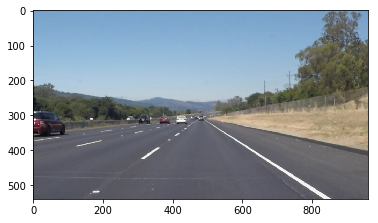

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [6]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def robust_white_yellow_detection(image):
    """ Robust White/Yellow line detector using HLS colorspace
    
    Takes an RGB image as input and returns an RGB
    image masking out everything except white and 
    yellow regions.
    """
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
      
    # Range for yellow (HLS)
    yellow_min = np.array([10, 0, 100], dtype=np.uint8)
    yellow_max = np.array([40, 255, 255], dtype=np.uint8)
    yellow_range = cv2.inRange(hls, yellow_min, yellow_max)
    
    # Range for white (HLS)
    white_min = np.array([0, 200, 0], dtype=np.uint8)
    white_max = np.array([255, 255, 255], dtype=np.uint8)
    white_range = cv2.inRange(hls, white_min, white_max)
    white_or_yellow = cv2.bitwise_or(yellow_range, white_range)
    
    final = cv2.bitwise_and(image, image, mask=white_or_yellow)
    return final

def auto_canny(image, sigma=0.33):
    """ Automatically detects Canny thresholds
    based on pixel intensities of input 
    grayscale image.
    """
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def draw_lines(img, lines, global_store, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #print(img.shape)
    x_max_left = 0 # int(img.shape[1])   # Bottom of image to extrapolate lane marking
    y_min = int(img.shape[0]/2 + 75)   # Horizon line to extrapolate lane marking (based on RoI)
    y_max_right = int(img.shape[0])
    x_right = []
    y_right = []
    x_left = []
    y_left = []

    right_lane_lines = [line for line in lines if ((line[0,3] - line[0,1])/(line[0,2] - line[0,0]) > 0 )]
    for line in right_lane_lines:
        for x1, y1, x2, y2 in line:
            x_right += [x1, x2]
            y_right += [y1, y2]
    #print("x_right: {0}".format(x_right))
    
    if x_right != [] and y_right != []:
        z_right = np.polyfit(x_right,y_right,1)
        f_right = np.poly1d(z_right)
        x_new = np.linspace(min(x_right), max(x_right), 2).astype(int)
        y_new = f_right(x_new).astype(int)
        points = list(zip(x_new, y_new))
        x_top, y_top = points[0]
        x_bottom, y_bottom = points[-1]  
        x_max = int((y_max_right - z_right[1] )/ z_right[0])     
        y_right_top = int((y_min - z_right[1] )/ z_right[0]) #f_right(y_min).astype(int)
        slope_right = (y_max_right - y_min)/(x_max - y_right_top)
        print("slope_right: {0}   z_right[0]: {1}".format(slope_right, z_right[0]))
        if len(global_store.qr) > 0:
            if abs(z_right[0] - global_store.qr_avg[0]) < 0.45:
                global_store.append_r(z_right)
                cv2.line(img, (y_right_top, y_min), (x_max, y_max_right), color, thickness)
            else: # Line is wayward
                z_right = global_store.qr_avg
                f_right = np.poly1d(z_right)
                x_max = int((y_max_right - z_right[1] )/ z_right[0])     
                y_right_top = int((y_min - z_right[1] )/ z_right[0]) #f_right(y_min).astype(int)
                cv2.line(img, (y_right_top, y_min), (x_max, y_max_right), color, thickness)
        else:
            global_store.append_r(z_right)
            cv2.line(img, (y_right_top, y_min), (x_max, y_max_right), color, thickness)
    else:
        print("ERROR: No right lane detected!!!")

                
        #print("Right lane points: " + str((y_right_top, y_min)) + " and " + str((x_max, y_max_right)))
        #cv2.line(img, (y_right_top, y_min), (x_max, y_max_right), color, thickness)

    left_lane_lines = [line for line in lines if ((line[0,3] - line[0,1])/(line[0,2] - line[0,0]) < 0 )]
    for line in left_lane_lines:
        for x1, y1, x2, y2 in line:
            x_left += [x1, x2]
            y_left += [y1, y2]
    if x_left != [] and y_left != []:  
        z_left = np.polyfit(x_left,y_left,1)
        f_left = np.poly1d(z_left)
        x_new = np.linspace(min(x_left), max(x_left), 2).astype(int)
        y_new = f_left(x_new).astype(int)
        points = list(zip(x_new, y_new))
        x_min = int((y_min - z_left[1] )/ z_left[0])
        y_left_bottom_ex = f_left(x_max_left).astype(int)
        slope_left = (y_left_bottom_ex - y_min)/(x_max_left - x_min)
        print("slope_left: {0}   z_left[0]: {1}".format(slope_left, z_left[0]))
        
        if len(global_store.ql) > 0:
            if abs(z_left[0] - global_store.ql_avg[0]) < 0.45:
                global_store.append_l(z_left)
                cv2.line(img, (x_min, y_min), (x_max_left, y_left_bottom_ex), color, thickness)
            else: # Line is wayward
                z_left = global_store.ql_avg
                f_left = np.poly1d(z_left)
                x_min = int((y_min - z_left[1] )/ z_left[0])
                y_left_bottom_ex = f_left(x_max_left).astype(int)
                cv2.line(img, (x_min, y_min), (x_max_left, y_left_bottom_ex), color, thickness)
        else:
            global_store.append_l(z_left)
            cv2.line(img, (x_min, y_min), (x_max_left, y_left_bottom_ex), color, thickness)
    else:
        print("ERROR: No left lane detected!!!")
        
    #return [x_left, y_left, x_right, y_right]     

def hough_lines(img, global_store, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #print(*lines, sep = ", ")  
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, global_store)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

class AveragingBuffer:
    def __init__(self, maxlen):
        assert( maxlen>1)
        self.ql=collections.deque(maxlen=maxlen)
        self.qr=collections.deque(maxlen=maxlen)
        self.ql_avg= [0.0, 0.0]
        self.qr_avg= [0.0, 0.0]
    def append_l(self, x):
        if len(self.ql)==self.ql.maxlen:
            # remove first item, update running average
            d=self.ql.popleft()
            self.ql_avg=self.ql_avg+(self.ql_avg-d)/float(len(self.ql))
        # append new item, update running average
        self.ql.append(x)
        self.ql_avg=self.ql_avg+(x-self.ql_avg)/float(len(self.ql))
    def append_r(self, x):
        if len(self.qr)==self.qr.maxlen:
            # remove first item, update running average
            d=self.qr.popleft()
            self.qr_avg=self.qr_avg+(self.qr_avg-d)/float(len(self.qr))
        # append new item, update running average
        self.qr.append(x)
        self.qr_avg=self.qr_avg+(x-self.qr_avg)/float(len(self.qr))



## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [7]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [8]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

#os.mkdir("test_images_output/")

plt.figure(figsize=(135, 240)) 
listImages = os.listdir("test_images/")
elems = len(listImages)
idx = 0

# Algorithm parameters
# Canny
low_threshold = 50
high_threshold = 150
# Hough
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20    # minimum number of votes (intersections in Hough grid cell)
min_line_len = 20  # minimum number of pixels making up a line
max_line_gap = 300  # maximum gap in pixels between connectable line segments

slope_avg = []    # Avg slope of left and right lanes across images
slope_current = []

for imag in listImages:
    if imag[0:6] != "output":
        # Read images from the test_images/ directory
        imagOrig = cv2.imread('test_images/' + imag)
        finalImage = np.copy(imagOrig)
        assert(imagOrig is not None)
        idx = idx +  1
        global_store1 = AveragingBuffer(10)

        imagInput = cv2.cvtColor(imagOrig, cv2.COLOR_BGR2RGB)
        #cv2.imwrite('samples/orig_'+imag, imagOrig)

        white_yellow = robust_white_yellow_detection(imagInput)
        #cv2.imwrite('samples/wy_'+imag, cv2.cvtColor(white_yellow, cv2.COLOR_RGB2BGR))

        
        # Define a kernel size and apply Gaussian smoothing    
        kernel_size = 13
        imagBlur = gaussian_blur(white_yellow, kernel_size)
        #cv2.imwrite('samples/blur_'+imag, cv2.cvtColor(imagBlur, cv2.COLOR_RGB2BGR))
        
        # Grayscaling the image
        imagGray = grayscale(imagBlur)
        plt.subplot(len(listImages), 3, 3*idx - 2)
        plt.imshow(imagGray, 'gray') # , cmap="gray")
        plt.show
        #cv2.imwrite('samples/gray_'+imag, imagGray)
                
        # Apply Canny edge detection with automatic parameter tuning
        edges = canny(imagGray, low_threshold=50, high_threshold=150)
        plt.subplot(len(listImages), 3, 3*idx - 1)
        plt.imshow(edges, 'gray')
        plt.show
        #cv2.imwrite('samples/canny_'+imag, edges)

        # This time we are defining a four sided polygon to mask
        imshape = imagOrig.shape
        #print(imshape)
        vertices = np.array([[(imshape[1], imshape[0]),(0, imshape[0]), (imshape[1]/2 - 20, imshape[0]/2 + 75), (imshape[1]/2 + 20, imshape[0]/2 + 75)]], dtype=np.int32)
        #print(*vertices, sep=", ")
        masked_edges = region_of_interest(edges, vertices)
        
        #masked_edges = cv2.cvtColor(masked_edges, cv2.COLOR_GRAY2RGB)
        #cv2.line(masked_edges, (imshape[1], imshape[0]), (0, imshape[0]), color=[255, 0, 0], thickness=5)
        #cv2.line(masked_edges, (imshape[1], imshape[0]), (int(imshape[1]/2 + 50), int(imshape[0]/2 + 75)), color=[255, 0, 0], thickness=5)
        #cv2.line(masked_edges, (int(imshape[1]/2 + 50), int(imshape[0]/2 + 75)), (int(imshape[1]/2 - 50), int(imshape[0]/2 + 75)), color=[255, 0, 0], thickness=5)
        #cv2.line(masked_edges, (int(imshape[1]/2 - 50), int(imshape[0]/2 + 75)), (0, imshape[0]), color=[255, 0, 0], thickness=5)

        #cv2.imwrite('samples/roi_'+imag, masked_edges)

        # Plot grayscaled images
        plt.subplot(len(listImages), 3, 3*idx)
        plt.imshow(masked_edges, 'gray')
        plt.show

        # Run Hough on edge detected image
        line_image = hough_lines(masked_edges, global_store1, rho, theta, threshold, min_line_len, max_line_gap)
        #cv2.imwrite('samples/hough_'+imag, cv2.cvtColor(line_image, cv2.COLOR_RGB2BGR))

        # Create a "color" binary image to combine with line image
        #color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

        # Draw the lines on the edge image
        cv2.addWeighted(line_image, 0.8, cv2.cvtColor(imagOrig, cv2.COLOR_BGR2RGB), 1, 0, finalImage) 
        plt.subplot(len(listImages), 3, 3*idx)
        plt.imshow(finalImage)
        plt.show
        cv2.imwrite('test_images_output/'+imag, cv2.cvtColor(finalImage, cv2.COLOR_BGR2RGB))


slope_right: 0.5603448275862069   z_right[0]: 0.5596215145162681
slope_left: -0.7875288683602771   z_left[0]: -0.7875123558484348
slope_right: 0.6372549019607843   z_right[0]: 0.6367551674130264
slope_left: -0.6885245901639344   z_left[0]: -0.688700892980565
slope_right: 0.5909090909090909   z_right[0]: 0.5907093462931641
slope_left: -0.7149425287356321   z_left[0]: -0.7144747685100624
slope_right: 0.5803571428571429   z_right[0]: 0.5794552862963758
slope_left: -0.7384259259259259   z_left[0]: -0.7397315973626803
slope_right: 0.6132075471698113   z_right[0]: 0.6129619515747323
slope_left: -0.6955503512880562   z_left[0]: -0.6945260988206639
slope_right: 0.5769230769230769   z_right[0]: 0.5761629728834674
slope_left: -0.7636363636363637   z_left[0]: -0.7632778205347472


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
# Buffer size of 10 frames created for memory filter
global_store = AveragingBuffer(10)

def process_image(image, global_store):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    finalImage = np.copy(image)
    
    white_yellow = robust_white_yellow_detection(image)

    # Define a kernel size and apply Gaussian smoothing
    imagBlur = gaussian_blur(white_yellow, kernel_size=13)

    # Grayscaling the image
    imagGray = grayscale(imagBlur)
    
    # Define our parameters for Canny and apply
    edges = auto_canny(imagGray)  

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(imshape[1], imshape[0]),(0, imshape[0]), (imshape[1]/2 - 10, imshape[0]/2 + 75), (imshape[1]/2 + 10, imshape[0]/2 + 75)]], dtype=np.int32)

    # Obtain RoI
    masked_edges = region_of_interest(edges, vertices)

    # Run Hough on edge detected image
    line_image = hough_lines(masked_edges, global_store, rho, theta, threshold, min_line_len, max_line_gap)

    # Draw the lines on the edge image
    cv2.addWeighted(line_image, 0.8, image, 1, 0, finalImage)
    
    return finalImage

def image_memory_filter(image):
    """
    Function that processes current frame
    based on previous N frames output
    
    """
    # here process the image using im and global_store
    #processed_frame  = 
    #global_store.append((processed_frame, data))
    return process_image(image, global_store)
#new_clip = my_clip.fl_image(my_memorizing_image_filter)

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'test_videos_output/output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
#print(clip1.shape)
white_clip = clip1.fl_image(image_memory_filter)
#white_clip = clip1.fl_image(process_image(slope_avg)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

slope_right: 0.6   z_right[0]: 0.599624709714038
slope_left: -0.731764705882353   z_left[0]: -0.7328580821865973
[MoviePy] >>>> Building video test_videos_output/output.mp4
[MoviePy] Writing video test_videos_output/output.mp4


  0%|                                                                                          | 0/222 [00:00<?, ?it/s]

slope_right: 0.6   z_right[0]: 0.599624709714038
slope_left: -0.731764705882353   z_left[0]: -0.7328580821865973
slope_right: 0.625   z_right[0]: 0.623997551442178
slope_left: -0.7315914489311164   z_left[0]: -0.7308870318492539
slope_right: 0.6310679611650486   z_right[0]: 0.6318481713502379
slope_left: -0.7210401891252955   z_left[0]: -0.7223742326463195
slope_right: 0.6074766355140186   z_right[0]: 0.6059776549595206
slope_left: -0.713953488372093   z_left[0]: -0.7139009242656259


  2%|█▍                                                                                | 4/222 [00:00<00:06, 33.42it/s]

slope_right: 0.6037151702786377   z_right[0]: 0.6044672031850592
ERROR: No left lane detected!!!
slope_right: 0.6074766355140186   z_right[0]: 0.6077472199570869
slope_left: -0.7523584905660378   z_left[0]: -0.7532467532467532
slope_right: 0.6190476190476191   z_right[0]: 0.6201709340139138
slope_left: -0.7547169811320755   z_left[0]: -0.7549019607843125
slope_right: 0.5963302752293578   z_right[0]: 0.5949006486079432
slope_left: -0.7268408551068883   z_left[0]: -0.7269801778429891
slope_right: 0.6055900621118012   z_right[0]: 0.6073068149522642
slope_left: -0.7304964539007093   z_left[0]: -0.7299681110885959


  4%|███▎                                                                              | 9/222 [00:00<00:05, 35.78it/s]

slope_right: 0.6132075471698113   z_right[0]: 0.6135406730181109
slope_left: -0.7206572769953051   z_left[0]: -0.7219367832627724
slope_right: 0.6055900621118012   z_right[0]: 0.6064344176568623
slope_left: -0.7089201877934272   z_left[0]: -0.7096342700449217
slope_right: 0.6151419558359621   z_right[0]: 0.6165242048545627
slope_left: -0.7046511627906977   z_left[0]: -0.7059132594573929
slope_right: 0.6331168831168831   z_right[0]: 0.6337124628552098
slope_left: -0.7183098591549296   z_left[0]: -0.7177502483273048
slope_right: 0.6230031948881789   z_right[0]: 0.6240798424007546
slope_left: -0.719047619047619   z_left[0]: -0.7201944009754601


  6%|█████                                                                            | 14/222 [00:00<00:05, 37.23it/s]

slope_right: 0.6230031948881789   z_right[0]: 0.6246912338391423
slope_left: -0.706855791962175   z_left[0]: -0.7063316878099476
slope_right: 0.6372549019607843   z_right[0]: 0.6378471762681746
slope_left: -0.7088305489260143   z_left[0]: -0.7082427479967696
slope_right: 0.6270096463022508   z_right[0]: 0.6274319984063357
slope_left: -0.6474654377880185   z_left[0]: -0.6477272727272726
slope_right: 0.6210191082802548   z_right[0]: 0.6201658903602937
ERROR: No left lane detected!!!
slope_right: 0.625   z_right[0]: 0.625288902687226
slope_left: -0.672093023255814   z_left[0]: -0.6725703807571995


  9%|██████▉                                                                          | 19/222 [00:00<00:05, 38.31it/s]

slope_right: 0.6351791530944625   z_right[0]: 0.6366337183474007
slope_left: -0.7018779342723005   z_left[0]: -0.7022642945485676
slope_right: 0.6372549019607843   z_right[0]: 0.6366097641265424
slope_left: -0.6853146853146853   z_left[0]: -0.6847688505816403
slope_right: 0.6372549019607843   z_right[0]: 0.637378754693367
slope_left: -0.665893271461717   z_left[0]: -0.6663901040880975
slope_right: 0.6372549019607843   z_right[0]: 0.6362415764101117
slope_left: -0.679814385150812   z_left[0]: -0.6808337214718224
slope_right: 0.6310679611650486   z_right[0]: 0.6307838908551069
slope_left: -0.6712962962962963   z_left[0]: -0.6723818785133634


 11%|████████▊                                                                        | 24/222 [00:00<00:05, 38.83it/s]

slope_right: 0.6270096463022508   z_right[0]: 0.6278268161686921
slope_left: -0.6892523364485982   z_left[0]: -0.6903370779590069
slope_right: 0.6435643564356436   z_right[0]: 0.6455125120307988
slope_left: -0.7058823529411765   z_left[0]: -0.7059817910527775
slope_right: 0.6290322580645161   z_right[0]: 0.6285162080139577
slope_left: -0.7018779342723005   z_left[0]: -0.7015930240705229
slope_right: 0.6331168831168831   z_right[0]: 0.632211518550117
slope_left: -0.7203791469194313   z_left[0]: -0.7207133106996612


 13%|██████████▏                                                                      | 28/222 [00:00<00:04, 39.09it/s]

slope_right: 0.6331168831168831   z_right[0]: 0.6318762293227193
slope_left: -0.6937354988399071   z_left[0]: -0.693793823661048
slope_right: 0.6310679611650486   z_right[0]: 0.6316927235247825
slope_left: -0.7086247086247086   z_left[0]: -0.7095963442498106
slope_right: 0.6331168831168831   z_right[0]: 0.6339544415914817
slope_left: -0.6697459584295612   z_left[0]: -0.6698113207547164
slope_right: 0.6270096463022508   z_right[0]: 0.6264833527306741
slope_left: -0.7328605200945626   z_left[0]: -0.7342838626053142
slope_right: 0.6290322580645161   z_right[0]: 0.6296036182824395
slope_left: -0.7129411764705882   z_left[0]: -0.7134235114166196


 15%|████████████                                                                     | 33/222 [00:00<00:04, 40.24it/s]

slope_right: 0.6290322580645161   z_right[0]: 0.6287111200950047
slope_left: -0.686046511627907   z_left[0]: -0.6863250707037106
slope_right: 0.625   z_right[0]: 0.6256782941054249
slope_left: -0.7016317016317016   z_left[0]: -0.7014215341308919
slope_right: 0.6310679611650486   z_right[0]: 0.6316235061821005
slope_left: -0.6946386946386947   z_left[0]: -0.6942954656265232
slope_right: 0.6132075471698113   z_right[0]: 0.6132174383603343
slope_left: -0.7016317016317016   z_left[0]: -0.7025792573496193


 17%|█████████████▌                                                                   | 37/222 [00:00<00:04, 40.08it/s]

slope_right: 0.625   z_right[0]: 0.6258728291543767
slope_left: -0.704225352112676   z_left[0]: -0.7052685687785821
slope_right: 0.6210191082802548   z_right[0]: 0.6205030428796307
slope_left: -0.6962616822429907   z_left[0]: -0.6972809224126284
slope_right: 0.6290322580645161   z_right[0]: 0.628885396397745
slope_left: -0.7049180327868853   z_left[0]: -0.7063825027708008
slope_right: 0.6290322580645161   z_right[0]: 0.6287393966772075
slope_left: -0.6844547563805105   z_left[0]: -0.6832531806749665
slope_right: 0.6331168831168831   z_right[0]: 0.6326590127168512
ERROR: No left lane detected!!!


 19%|███████████████▎                                                                 | 42/222 [00:01<00:04, 40.68it/s]

slope_right: 0.6351791530944625   z_right[0]: 0.6340573917148231
slope_left: -0.672093023255814   z_left[0]: -0.6728971962616831
slope_right: 0.6372549019607843   z_right[0]: 0.6390019470524637
slope_left: -0.7223529411764706   z_left[0]: -0.7230769230769238
slope_right: 0.6351791530944625   z_right[0]: 0.6360170789542358
slope_left: -0.7296650717703349   z_left[0]: -0.729193632436248
slope_right: 0.6435643564356436   z_right[0]: 0.6426849898434387
slope_left: -0.7163120567375887   z_left[0]: -0.7161582459485213


 21%|████████████████▊                                                                | 46/222 [00:01<00:04, 38.85it/s]

slope_right: 0.6310679611650486   z_right[0]: 0.6314765378807286
slope_left: -0.7102137767220903   z_left[0]: -0.7114019054397223
slope_right: 0.6331168831168831   z_right[0]: 0.6334353309346937
slope_left: -0.7115839243498818   z_left[0]: -0.712285055841161
slope_right: 0.6478405315614618   z_right[0]: 0.6467894282621856
slope_left: -0.6924882629107981   z_left[0]: -0.6940650406504075
slope_right: 0.639344262295082   z_right[0]: 0.6380803643278231
slope_left: -0.7051886792452831   z_left[0]: -0.706278208843263


 23%|██████████████████▏                                                              | 50/222 [00:01<00:04, 37.25it/s]

slope_right: 0.6610169491525424   z_right[0]: 0.6619166651997113
slope_left: -0.7183770883054893   z_left[0]: -0.7188261566095433
slope_right: 0.6435643564356436   z_right[0]: 0.6423106315027916
slope_left: -0.71875   z_left[0]: -0.7208466201773148
slope_right: 0.6521739130434783   z_right[0]: 0.6521724534816805
slope_left: -0.6966824644549763   z_left[0]: -0.6961257044776904
slope_right: 0.65   z_right[0]: 0.650467068700485
ERROR: No left lane detected!!!


 24%|███████████████████▋                                                             | 54/222 [00:01<00:04, 36.31it/s]

slope_right: 0.6543624161073825   z_right[0]: 0.6555477554882374
slope_left: -0.6022988505747127   z_left[0]: -0.6021505376344074
slope_right: 0.6331168831168831   z_right[0]: 0.6335088499589813
slope_left: -0.6941176470588235   z_left[0]: -0.6953125000000002
slope_right: 0.639344262295082   z_right[0]: 0.6404569892473116
slope_left: -0.7129186602870813   z_left[0]: -0.7135968360226592
slope_right: 0.6310679611650486   z_right[0]: 0.6297072246390352
slope_left: -0.6847058823529412   z_left[0]: -0.6845832806374107


 26%|█████████████████████▏                                                           | 58/222 [00:01<00:04, 35.20it/s]

slope_right: 0.6351791530944625   z_right[0]: 0.6357756031986588
slope_left: -0.6721698113207547   z_left[0]: -0.6720173041894356
slope_right: 0.6478405315614618   z_right[0]: 0.6466091461514492
slope_left: -0.6904761904761905   z_left[0]: -0.6906723465820029
slope_right: 0.6587837837837838   z_right[0]: 0.6585547785547783
slope_left: -0.6824644549763034   z_left[0]: -0.6824270386556434
slope_right: 0.6521739130434783   z_right[0]: 0.6527029115483137
slope_left: -0.6761229314420804   z_left[0]: -0.6767164017365515


 28%|██████████████████████▌                                                          | 62/222 [00:01<00:04, 33.69it/s]

slope_right: 0.6565656565656566   z_right[0]: 0.6566761561282186
slope_left: -0.6697892271662763   z_left[0]: -0.66879422611573
slope_right: 0.6587837837837838   z_right[0]: 0.6586728703546239
slope_left: -0.6904761904761905   z_left[0]: -0.6919511818322256
slope_right: 0.6565656565656566   z_right[0]: 0.6552316753708307
slope_left: -0.754950495049505   z_left[0]: -0.7548387096774202
slope_right: 0.6521739130434783   z_right[0]: 0.6523005185460965
ERROR: No left lane detected!!!


 30%|████████████████████████                                                         | 66/222 [00:01<00:04, 33.44it/s]

slope_right: 0.6331168831168831   z_right[0]: 0.6323777340275473
ERROR: No left lane detected!!!
slope_right: 0.6610169491525424   z_right[0]: 0.6615063389799
slope_left: -0.6737588652482269   z_left[0]: -0.6746031746031738
slope_right: 0.6456953642384106   z_right[0]: 0.6469956226593566
slope_left: -0.6619385342789598   z_left[0]: -0.6613445768938621
slope_right: 0.6435643564356436   z_right[0]: 0.6446325104234504
slope_left: -0.633177570093458   z_left[0]: -0.6337630942788101


 32%|█████████████████████████▌                                                       | 70/222 [00:01<00:04, 34.21it/s]

slope_right: 0.6587837837837838   z_right[0]: 0.6582715238871535
slope_left: -0.669047619047619   z_left[0]: -0.6686713353645887
slope_right: 0.6543624161073825   z_right[0]: 0.6535639781318083
slope_left: -0.669047619047619   z_left[0]: -0.6692126909518206
slope_right: 0.6521739130434783   z_right[0]: 0.6517189373138947
slope_left: -0.6533018867924528   z_left[0]: -0.653285769544849
slope_right: 0.6521739130434783   z_right[0]: 0.651240635710884
slope_left: -0.672209026128266   z_left[0]: -0.6735242199262768


 33%|███████████████████████████                                                      | 74/222 [00:01<00:04, 34.23it/s]

slope_right: 0.65   z_right[0]: 0.651069953020358
slope_left: -0.669047619047619   z_left[0]: -0.670434010324475
slope_right: 0.6521739130434783   z_right[0]: 0.6531811624430773
slope_left: -0.6619047619047619   z_left[0]: -0.6623731794684801
slope_right: 0.65   z_right[0]: 0.6499761001146044
slope_left: -0.6698795180722892   z_left[0]: -0.6696661141368696
slope_right: 0.6587837837837838   z_right[0]: 0.6585328556448793
ERROR: No left lane detected!!!


 35%|████████████████████████████▍                                                    | 78/222 [00:02<00:04, 33.81it/s]

slope_right: 0.6610169491525424   z_right[0]: 0.6597677262161231
ERROR: No left lane detected!!!
slope_right: 0.6632653061224489   z_right[0]: 0.6636127852184757
slope_left: -0.5949074074074074   z_left[0]: -0.5954198473282449
slope_right: 0.6818181818181818   z_right[0]: 0.6816665308430695
slope_left: -0.697841726618705   z_left[0]: -0.6987179487179491
slope_right: 0.6794425087108014   z_right[0]: 0.6798261139985506
slope_left: -0.5944055944055944   z_left[0]: -0.5934326865998062


 37%|█████████████████████████████▉                                                   | 82/222 [00:02<00:04, 33.36it/s]

slope_right: 0.6842105263157895   z_right[0]: 0.6824572161212997
slope_left: -0.6226415094339622   z_left[0]: -0.6221071814472562
slope_right: 0.6747404844290658   z_right[0]: 0.6735009034499181
slope_left: -0.6297169811320755   z_left[0]: -0.6311464306678096
slope_right: 0.6632653061224489   z_right[0]: 0.6633892123475776
slope_left: -0.6484560570071259   z_left[0]: -0.6496701691054807
slope_right: 0.6655290102389079   z_right[0]: 0.6662751404676387
slope_left: -0.6508313539192399   z_left[0]: -0.652821817392667


 39%|███████████████████████████████▍                                                 | 86/222 [00:02<00:04, 33.21it/s]

slope_right: 0.6724137931034483   z_right[0]: 0.6728606107644326
slope_left: -0.6508313539192399   z_left[0]: -0.6508092771843151
slope_right: 0.6818181818181818   z_right[0]: 0.6832450251212181
slope_left: -0.6762589928057554   z_left[0]: -0.6770263730946054
slope_right: 0.6655290102389079   z_right[0]: 0.664695145399693
slope_left: -0.667458432304038   z_left[0]: -0.6674446166469131
slope_right: 0.6724137931034483   z_right[0]: 0.6729885997116481
ERROR: No left lane detected!!!


 41%|████████████████████████████████▊                                                | 90/222 [00:02<00:03, 33.69it/s]

slope_right: 0.6770833333333334   z_right[0]: 0.6769514641693034
slope_left: -0.593103448275862   z_left[0]: -0.5943396226415083
slope_right: 0.6794425087108014   z_right[0]: 0.680114462202858
slope_left: -0.6448598130841121   z_left[0]: -0.646278846696383
slope_right: 0.6818181818181818   z_right[0]: 0.6830399095010528
slope_left: -0.6470588235294118   z_left[0]: -0.6464170979832233
slope_right: 0.6842105263157895   z_right[0]: 0.6821826882407248
slope_left: -0.6370023419203747   z_left[0]: -0.63669214732453


 42%|██████████████████████████████████▎                                              | 94/222 [00:02<00:03, 33.78it/s]

slope_right: 0.6866197183098591   z_right[0]: 0.6844948932439159
slope_left: -0.6469194312796208   z_left[0]: -0.6471260303038535
slope_right: 0.6842105263157895   z_right[0]: 0.6838328167987253
slope_left: -0.6462264150943396   z_left[0]: -0.647436208519765
slope_right: 0.6818181818181818   z_right[0]: 0.6811443444349659
slope_left: -0.6516587677725119   z_left[0]: -0.6514665273527881
slope_right: 0.6914893617021277   z_right[0]: 0.6906029803611957
slope_left: -0.6516587677725119   z_left[0]: -0.652894980962925


 44%|███████████████████████████████████▊                                             | 98/222 [00:02<00:03, 33.67it/s]

slope_right: 0.703971119133574   z_right[0]: 0.703304854741729
slope_left: -0.6516587677725119   z_left[0]: -0.6513774050707319
slope_right: 0.703971119133574   z_right[0]: 0.7050709689337727
slope_left: -0.6532066508313539   z_left[0]: -0.6529417203119305
slope_right: 0.6964285714285714   z_right[0]: 0.6954226309376419
slope_left: -0.6477541371158393   z_left[0]: -0.6495235912864142
slope_right: 0.6818181818181818   z_right[0]: 0.6837099892480172
ERROR: No left lane detected!!!


 46%|████████████████████████████████████▊                                           | 102/222 [00:02<00:03, 33.77it/s]

slope_right: 0.6794425087108014   z_right[0]: 0.6802476003208194
slope_left: -0.5981735159817352   z_left[0]: -0.6000000000000006
slope_right: 0.6890459363957597   z_right[0]: 0.6887852742198124
slope_left: -0.6511627906976745   z_left[0]: -0.6500955179088196
slope_right: 0.6842105263157895   z_right[0]: 0.6830372924970451
slope_left: -0.6596736596736597   z_left[0]: -0.6611819127303201
slope_right: 0.6818181818181818   z_right[0]: 0.6813929606832684
slope_left: -0.6557377049180327   z_left[0]: -0.6549994882816492


 48%|██████████████████████████████████████▏                                         | 106/222 [00:02<00:03, 32.68it/s]

slope_right: 0.6842105263157895   z_right[0]: 0.6833853925671577
slope_left: -0.6558139534883721   z_left[0]: -0.6551966292134834
slope_right: 0.6678082191780822   z_right[0]: 0.6681257319128272
slope_left: -0.6503496503496503   z_left[0]: -0.6508902929350957
slope_right: 0.6818181818181818   z_right[0]: 0.6813580575839134
slope_left: -0.6768149882903981   z_left[0]: -0.6771725742438758
slope_right: 0.6842105263157895   z_right[0]: 0.6843022465235774
slope_left: -0.6729411764705883   z_left[0]: -0.6737590089907495


 50%|███████████████████████████████████████▋                                        | 110/222 [00:03<00:03, 33.14it/s]

slope_right: 0.6794425087108014   z_right[0]: 0.6799396754345856
slope_left: -0.6879432624113475   z_left[0]: -0.6877485890542089
slope_right: 0.6818181818181818   z_right[0]: 0.6796426119932029
slope_left: -0.6903073286052009   z_left[0]: -0.6889111873574877
slope_right: 0.6632653061224489   z_right[0]: 0.6639393844581414
slope_left: -0.6658878504672897   z_left[0]: -0.6672972860183337
slope_right: 0.6890459363957597   z_right[0]: 0.68770497405641
ERROR: No left lane detected!!!


 51%|█████████████████████████████████████████                                       | 114/222 [00:03<00:03, 32.98it/s]

slope_right: 0.6701030927835051   z_right[0]: 0.6703559420642341
slope_left: -0.6744730679156908   z_left[0]: -0.6739130434782599
slope_right: 0.6747404844290658   z_right[0]: 0.6738716706988374
slope_left: -0.6941176470588235   z_left[0]: -0.6942148760330581
slope_right: 0.6747404844290658   z_right[0]: 0.6738219323673649
slope_left: -0.7007125890736342   z_left[0]: -0.7026145473094066
slope_right: 0.6701030927835051   z_right[0]: 0.6699483303159649
slope_left: -0.6777251184834123   z_left[0]: -0.6796891906513757


 53%|██████████████████████████████████████████▌                                     | 118/222 [00:03<00:03, 32.71it/s]

slope_right: 0.6521739130434783   z_right[0]: 0.6539403328169511
slope_left: -0.6548463356973995   z_left[0]: -0.6553549190535513
slope_right: 0.6478405315614618   z_right[0]: 0.6475359252402364
slope_left: -0.6945107398568019   z_left[0]: -0.6943461014741573
slope_right: 0.65   z_right[0]: 0.6494253889501039
slope_left: -0.6791569086651054   z_left[0]: -0.6809345679769423
slope_right: 0.65   z_right[0]: 0.6493529026519259
slope_left: -0.6776470588235294   z_left[0]: -0.6773481111845158


 55%|███████████████████████████████████████████▉                                    | 122/222 [00:03<00:03, 32.76it/s]

slope_right: 0.65   z_right[0]: 0.6488274739144256
slope_left: -0.6792452830188679   z_left[0]: -0.6790318001135711
slope_right: 0.6521739130434783   z_right[0]: 0.6511905118355237
slope_left: -0.667447306791569   z_left[0]: -0.6690138930426041
slope_right: 0.6414473684210527   z_right[0]: 0.6412171008671552
slope_left: -0.6620370370370371   z_left[0]: -0.6635087125697859
slope_right: 0.6456953642384106   z_right[0]: 0.6466134331527973
ERROR: No left lane detected!!!


 57%|█████████████████████████████████████████████▍                                  | 126/222 [00:03<00:02, 32.55it/s]

slope_right: 0.6351791530944625   z_right[0]: 0.6336107961616104
slope_left: -0.6505747126436782   z_left[0]: -0.6504854368932034
slope_right: 0.6351791530944625   z_right[0]: 0.6355284758176536
slope_left: -0.6605080831408776   z_left[0]: -0.6620185788589601
slope_right: 0.625   z_right[0]: 0.6264573840793357
slope_left: -0.702576112412178   z_left[0]: -0.7032386525254981
slope_right: 0.6331168831168831   z_right[0]: 0.6314963063769864
slope_left: -0.7089201877934272   z_left[0]: -0.7099930897661664


 59%|██████████████████████████████████████████████▊                                 | 130/222 [00:03<00:02, 32.33it/s]

slope_right: 0.6230031948881789   z_right[0]: 0.6222667909716947
slope_left: -0.663594470046083   z_left[0]: -0.6642375168690968
slope_right: 0.6230031948881789   z_right[0]: 0.6239618230757198
slope_left: -0.6953488372093023   z_left[0]: -0.694585448392556
slope_right: 0.6190476190476191   z_right[0]: 0.619716579485798
slope_left: -0.6983758700696056   z_left[0]: -0.6984097582123081
slope_right: 0.6331168831168831   z_right[0]: 0.6337782103106319
slope_left: -0.7032710280373832   z_left[0]: -0.7041007281628348


 60%|████████████████████████████████████████████████▎                               | 134/222 [00:03<00:02, 32.18it/s]

slope_right: 0.6290322580645161   z_right[0]: 0.6288331258046131
slope_left: -0.6985981308411215   z_left[0]: -0.6991792753056776
slope_right: 0.6270096463022508   z_right[0]: 0.6275893932836605
slope_left: -0.7061611374407583   z_left[0]: -0.7081420535116021
slope_right: 0.6270096463022508   z_right[0]: 0.6269710579325104
slope_left: -0.7169811320754716   z_left[0]: -0.7165180209490164
slope_right: 0.6310679611650486   z_right[0]: 0.6295177048562216
ERROR: No left lane detected!!!


 62%|█████████████████████████████████████████████████▋                              | 138/222 [00:03<00:02, 32.54it/s]

slope_right: 0.6230031948881789   z_right[0]: 0.6232799880346995
slope_left: -0.7023255813953488   z_left[0]: -0.7021276595744659
slope_right: 0.6230031948881789   z_right[0]: 0.6235078244546273
slope_left: -0.7411764705882353   z_left[0]: -0.7410806927927213
slope_right: 0.6210191082802548   z_right[0]: 0.6221587475269269
slope_left: -0.7142857142857143   z_left[0]: -0.7136069154795464
slope_right: 0.6331168831168831   z_right[0]: 0.6330470268390969
slope_left: -0.7162790697674418   z_left[0]: -0.7154427630023035


 64%|███████████████████████████████████████████████████▏                            | 142/222 [00:04<00:02, 31.79it/s]

slope_right: 0.6290322580645161   z_right[0]: 0.6289494374736562
slope_left: -0.6912442396313364   z_left[0]: -0.6917092360988785
slope_right: 0.6372549019607843   z_right[0]: 0.6369306511512471
slope_left: -0.7006960556844548   z_left[0]: -0.700640982389851
slope_right: 0.6310679611650486   z_right[0]: 0.6316293477981442
slope_left: -0.7232558139534884   z_left[0]: -0.7241181554566534
slope_right: 0.6310679611650486   z_right[0]: 0.6308855357808618
slope_left: -0.7283372365339579   z_left[0]: -0.7279694479949609


 66%|████████████████████████████████████████████████████▌                           | 146/222 [00:04<00:02, 31.50it/s]

slope_right: 0.6290322580645161   z_right[0]: 0.6295582329317272
slope_left: -0.7253521126760564   z_left[0]: -0.7264509979204554
slope_right: 0.6151419558359621   z_right[0]: 0.6141765074745466
slope_left: -0.7172897196261683   z_left[0]: -0.7175171182729723
slope_right: 0.6190476190476191   z_right[0]: 0.6185919146591626
slope_left: -0.731764705882353   z_left[0]: -0.7303477873224693
slope_right: 0.6037151702786377   z_right[0]: 0.603518419748995
slope_left: -0.716589861751152   z_left[0]: -0.717948717948715


 68%|██████████████████████████████████████████████████████                          | 150/222 [00:04<00:02, 30.94it/s]

slope_right: 0.5945121951219512   z_right[0]: 0.5947179646917626
slope_left: -0.7053364269141531   z_left[0]: -0.7054658110201364
slope_right: 0.6132075471698113   z_right[0]: 0.612941902231774
slope_left: -0.7226107226107226   z_left[0]: -0.7231042513717268
slope_right: 0.6132075471698113   z_right[0]: 0.61228799925116
slope_left: -0.7262180974477959   z_left[0]: -0.7246476550962764
slope_right: 0.625   z_right[0]: 0.6249434581024538
slope_left: -0.7313084112149533   z_left[0]: -0.7307667093669553


 69%|███████████████████████████████████████████████████████▍                        | 154/222 [00:04<00:02, 31.06it/s]

slope_right: 0.6190476190476191   z_right[0]: 0.6199321660057543
slope_left: -0.7099767981438515   z_left[0]: -0.7098319912516156
slope_right: 0.625   z_right[0]: 0.6240975605939894
slope_left: -0.7186046511627907   z_left[0]: -0.718600953895071
slope_right: 0.625   z_right[0]: 0.62504607002644
slope_left: -0.7226107226107226   z_left[0]: -0.7234576271186453
slope_right: 0.609375   z_right[0]: 0.6087796107317954
slope_left: -0.7389277389277389   z_left[0]: -0.740431098801139


 71%|████████████████████████████████████████████████████████▉                       | 158/222 [00:04<00:02, 31.21it/s]

slope_right: 0.609375   z_right[0]: 0.6106314603921471
slope_left: -0.7313084112149533   z_left[0]: -0.7302556540200321
slope_right: 0.6037151702786377   z_right[0]: 0.6050673113843746
slope_left: -0.7377049180327869   z_left[0]: -0.7388515675655988
slope_right: 0.6037151702786377   z_right[0]: 0.604867398702883
slope_left: -0.74364896073903   z_left[0]: -0.7442193625771683
slope_right: 0.6037151702786377   z_right[0]: 0.6033484525833579
slope_left: -0.728310502283105   z_left[0]: -0.7283950617283961


 73%|██████████████████████████████████████████████████████████▍                     | 162/222 [00:04<00:01, 30.96it/s]

slope_right: 0.6037151702786377   z_right[0]: 0.6028679875263807
slope_left: -0.7064220183486238   z_left[0]: -0.7069727154612392
slope_right: 0.6055900621118012   z_right[0]: 0.6064869803563269
slope_left: -0.7528868360277137   z_left[0]: -0.7516827760761513
slope_right: 0.582089552238806   z_right[0]: 0.5820537009737922
slope_left: -0.7090909090909091   z_left[0]: -0.7104914061598802
slope_right: 0.5838323353293413   z_right[0]: 0.5831111721863406
slope_left: -0.7431192660550459   z_left[0]: -0.7429244621469258


 75%|███████████████████████████████████████████████████████████▊                    | 166/222 [00:04<00:01, 31.36it/s]

slope_right: 0.5891238670694864   z_right[0]: 0.5888170182152968
slope_left: -0.7214611872146118   z_left[0]: -0.7226582494454858
slope_right: 0.5855855855855856   z_right[0]: 0.5852888086642595
slope_left: -0.7649769585253456   z_left[0]: -0.7650231694768196
slope_right: 0.5769230769230769   z_right[0]: 0.5766662802828327
slope_left: -0.7477064220183486   z_left[0]: -0.7488686843525555
slope_right: 0.582089552238806   z_right[0]: 0.5820077724096844
slope_left: -0.7655172413793103   z_left[0]: -0.766781411359724


 77%|█████████████████████████████████████████████████████████████▎                  | 170/222 [00:04<00:01, 31.43it/s]

slope_right: 0.5803571428571429   z_right[0]: 0.5817234752705579
slope_left: -0.768348623853211   z_left[0]: -0.7685287237654108
slope_right: 0.582089552238806   z_right[0]: 0.5813010685103707
slope_left: -0.7522727272727273   z_left[0]: -0.7520069078439853
slope_right: 0.5769230769230769   z_right[0]: 0.5771132594404267
slope_left: -0.759090909090909   z_left[0]: -0.7578283546901585
slope_right: 0.582089552238806   z_right[0]: 0.5825746446642989
slope_left: -0.7780320366132724   z_left[0]: -0.7777777777777788


 78%|██████████████████████████████████████████████████████████████▋                 | 174/222 [00:05<00:01, 31.25it/s]

slope_right: 0.5786350148367952   z_right[0]: 0.579290447565123
slope_left: -0.7842227378190255   z_left[0]: -0.784213297592265
slope_right: 0.5786350148367952   z_right[0]: 0.57854860886105
slope_left: -0.8051044083526682   z_left[0]: -0.8057116716769045
slope_right: 0.5803571428571429   z_right[0]: 0.5810338046245883
slope_left: -0.7672811059907834   z_left[0]: -0.7674124999282675
slope_right: 0.5803571428571429   z_right[0]: 0.5796510050303697
slope_left: -0.7620137299771167   z_left[0]: -0.763838071113613


 80%|████████████████████████████████████████████████████████████████▏               | 178/222 [00:05<00:01, 31.42it/s]

slope_right: 0.5838323353293413   z_right[0]: 0.5835082249168075
slope_left: -0.7757437070938215   z_left[0]: -0.7757099827882955
slope_right: 0.5803571428571429   z_right[0]: 0.5811299691976928
slope_left: -0.7875288683602771   z_left[0]: -0.7889144934480216
slope_right: 0.5873493975903614   z_right[0]: 0.5874739660815226
slope_left: -0.8036951501154734   z_left[0]: -0.8018932638221973
slope_right: 0.582089552238806   z_right[0]: 0.5819443396937928
slope_left: -0.7990762124711316   z_left[0]: -0.799342396127735


 82%|█████████████████████████████████████████████████████████████████▌              | 182/222 [00:05<00:01, 31.85it/s]

slope_right: 0.5769230769230769   z_right[0]: 0.5768910863638461
slope_left: -0.7962962962962963   z_left[0]: -0.7966145207907186
slope_right: 0.5873493975903614   z_right[0]: 0.586655904788283
slope_left: -0.789838337182448   z_left[0]: -0.7896649108332809
slope_right: 0.5803571428571429   z_right[0]: 0.5797100029871355
slope_left: -0.7788018433179723   z_left[0]: -0.7788077179316353
slope_right: 0.5855855855855856   z_right[0]: 0.5858844470744309
slope_left: -0.7793103448275862   z_left[0]: -0.7788461538461532


 84%|███████████████████████████████████████████████████████████████████             | 186/222 [00:05<00:01, 31.99it/s]

slope_right: 0.5803571428571429   z_right[0]: 0.5803663653232659
slope_left: -0.8022988505747126   z_left[0]: -0.8023255813953487
slope_right: 0.582089552238806   z_right[0]: 0.5816949856181237
slope_left: -0.8023255813953488   z_left[0]: -0.803056899430577
slope_right: 0.5701754385964912   z_right[0]: 0.5693916922219125
slope_left: -0.7668997668997669   z_left[0]: -0.7657391635389268
slope_right: 0.5635838150289018   z_right[0]: 0.5648819605826176
slope_left: -0.7877358490566038   z_left[0]: -0.7878717547950523


 86%|████████████████████████████████████████████████████████████████████▍           | 190/222 [00:05<00:01, 31.79it/s]

slope_right: 0.5571428571428572   z_right[0]: 0.5572597551218818
slope_left: -0.780373831775701   z_left[0]: -0.7813290052748217
slope_right: 0.5539772727272727   z_right[0]: 0.5546635177854414
slope_left: -0.7697674418604651   z_left[0]: -0.7687719775416236
slope_right: 0.5603448275862069   z_right[0]: 0.5598463654613999
slope_left: -0.7880184331797235   z_left[0]: -0.7892589538829446
slope_right: 0.5873493975903614   z_right[0]: 0.5880756956436209
slope_left: -0.7770114942528735   z_left[0]: -0.7762995551231335


 87%|█████████████████████████████████████████████████████████████████████▉          | 194/222 [00:05<00:00, 31.80it/s]

slope_right: 0.5752212389380531   z_right[0]: 0.5755041081748878
slope_left: -0.7620137299771167   z_left[0]: -0.7627086371129791
slope_right: 0.5945121951219512   z_right[0]: 0.594547689637718
slope_left: -0.7885057471264367   z_left[0]: -0.7883991759780027
slope_right: 0.5838323353293413   z_right[0]: 0.5840138941191676
slope_left: -0.7816091954022989   z_left[0]: -0.7817408219148718
slope_right: 0.582089552238806   z_right[0]: 0.5808765085499693
slope_left: -0.7505720823798627   z_left[0]: -0.7499999999999988


 89%|███████████████████████████████████████████████████████████████████████▎        | 198/222 [00:05<00:00, 31.44it/s]

slope_right: 0.5786350148367952   z_right[0]: 0.5794545673221476
slope_left: -0.7888631090487239   z_left[0]: -0.7893533035747214
slope_right: 0.5873493975903614   z_right[0]: 0.58659742230449
slope_left: -0.7930232558139535   z_left[0]: -0.7933995327102792
slope_right: 0.5838323353293413   z_right[0]: 0.5842292151340761
slope_left: -0.7736720554272517   z_left[0]: -0.7728986471501441
slope_right: 0.5635838150289018   z_right[0]: 0.5629438743653056
slope_left: -0.7697674418604651   z_left[0]: -0.7706588097229697


 91%|████████████████████████████████████████████████████████████████████████▊       | 202/222 [00:05<00:00, 31.04it/s]

slope_right: 0.5652173913043478   z_right[0]: 0.5648716047718547
slope_left: -0.7312072892938497   z_left[0]: -0.730820472965471
slope_right: 0.5718475073313783   z_right[0]: 0.5718228164543624
slope_left: -0.7986111111111112   z_left[0]: -0.7982963820378106
slope_right: 0.5524079320113314   z_right[0]: 0.5520776061398026
slope_left: -0.7806004618937644   z_left[0]: -0.780187840046339
slope_right: 0.5701754385964912   z_right[0]: 0.5703709149726129
slope_left: -0.76905311778291   z_left[0]: -0.7706831697732578


 93%|██████████████████████████████████████████████████████████████████████████▏     | 206/222 [00:06<00:00, 30.91it/s]

slope_right: 0.5803571428571429   z_right[0]: 0.5811310295998011
slope_left: -0.7806004618937644   z_left[0]: -0.7805105994985188
slope_right: 0.5635838150289018   z_right[0]: 0.5650934636245828
slope_left: -0.8037383177570093   z_left[0]: -0.8038341202571249
slope_right: 0.5524079320113314   z_right[0]: 0.5517006932095891
slope_left: -0.7953488372093023   z_left[0]: -0.7962731816353926
slope_right: 0.5555555555555556   z_right[0]: 0.5559852456156386
ERROR: No left lane detected!!!


 95%|███████████████████████████████████████████████████████████████████████████▋    | 210/222 [00:06<00:00, 30.40it/s]

slope_right: 0.5386740331491713   z_right[0]: 0.5388449372424445
slope_left: -0.7563218390804598   z_left[0]: -0.7555555555555552
slope_right: 0.547752808988764   z_right[0]: 0.5486204887961701
slope_left: -0.8093023255813954   z_left[0]: -0.8088102433097595
slope_right: 0.5524079320113314   z_right[0]: 0.5518766953086139
slope_left: -0.8079625292740047   z_left[0]: -0.8077193225265115
slope_right: 0.5718475073313783   z_right[0]: 0.5711867356123799
slope_left: -0.8135198135198135   z_left[0]: -0.814395468523782


 96%|█████████████████████████████████████████████████████████████████████████████   | 214/222 [00:06<00:00, 31.32it/s]

slope_right: 0.5652173913043478   z_right[0]: 0.5656035551440242
slope_left: -0.7708333333333334   z_left[0]: -0.770525192764654
slope_right: 0.5462184873949579   z_right[0]: 0.5476052772291267
slope_left: -0.7962962962962963   z_left[0]: -0.7966196903861095
slope_right: 0.5555555555555556   z_right[0]: 0.5556561340204582
slope_left: -0.7976744186046512   z_left[0]: -0.7979706741336212
slope_right: 0.5539772727272727   z_right[0]: 0.5547581408324354
slope_left: -0.8135198135198135   z_left[0]: -0.8132549318850016


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 218/222 [00:06<00:00, 32.79it/s]

slope_right: 0.5587392550143266   z_right[0]: 0.5590353194565528
slope_left: -0.8014018691588785   z_left[0]: -0.8013169183523208
slope_right: 0.5635838150289018   z_right[0]: 0.5627355239207686
slope_left: -0.7708333333333334   z_left[0]: -0.7711603033597985
slope_right: 0.5635838150289018   z_right[0]: 0.5638301449080455
slope_left: -0.7777777777777778   z_left[0]: -0.7779698344901239


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:06<00:00, 33.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/output.mp4 

Wall time: 7.05 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [14]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,3)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(image_memory_filter)
%time yellow_clip.write_videofile(yellow_output, audio=False)
clip2.reader.close()
clip2.audio.reader.close_proc()

slope_right: 0.6587837837837838   z_right[0]: 0.6591102612748541
slope_left: -0.6064814814814815   z_left[0]: -0.6065001896736003
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                                                          | 0/682 [00:00<?, ?it/s]

slope_right: 0.6587837837837838   z_right[0]: 0.6591102612748541
slope_left: -0.6064814814814815   z_left[0]: -0.6065001896736003
slope_right: 0.6724137931034483   z_right[0]: 0.6708782428681128
slope_left: -0.6111111111111112   z_left[0]: -0.6125031956028496
slope_right: 0.6587837837837838   z_right[0]: 0.6589011769580623
slope_left: -0.6223776223776224   z_left[0]: -0.6225991531098404
slope_right: 0.6655290102389079   z_right[0]: 0.6642330142567454
slope_left: -0.6285046728971962   z_left[0]: -0.6278911777295734


  1%|▍                                                                                 | 4/682 [00:00<00:19, 35.19it/s]

slope_right: 0.693950177935943   z_right[0]: 0.6934786054801827
slope_left: -0.6334106728538283   z_left[0]: -0.6346730955261415
ERROR: No right lane detected!!!
slope_left: -0.6319444444444444   z_left[0]: -0.6326969333743254
ERROR: No right lane detected!!!
slope_left: -0.6336405529953917   z_left[0]: -0.6343143603165635
ERROR: No right lane detected!!!
slope_left: -0.6412037037037037   z_left[0]: -0.6412259457528467
slope_right: 0.6478405315614618   z_right[0]: 0.6482758620689661
slope_left: -0.6496519721577726   z_left[0]: -0.6494566379096592


  1%|█                                                                                 | 9/682 [00:00<00:18, 37.02it/s]

slope_right: 0.6521739130434783   z_right[0]: 0.6527606718901496
slope_left: -0.655011655011655   z_left[0]: -0.6548880376393038
slope_right: 0.5838323353293413   z_right[0]: 0.5844081942336841
slope_left: -0.6534883720930232   z_left[0]: -0.6550497437443473
slope_right: 0.609375   z_right[0]: 0.6095846645367413
slope_left: -0.6275862068965518   z_left[0]: -0.6287619108758743
slope_right: 0.6190476190476191   z_right[0]: 0.6187088274044796
slope_left: -0.6542056074766355   z_left[0]: -0.6559477388970482
slope_right: 0.65   z_right[0]: 0.6502202183693879
slope_left: -0.6589327146171694   z_left[0]: -0.6594635949293982


  2%|█▋                                                                               | 14/682 [00:00<00:17, 38.59it/s]

slope_right: 0.6310679611650486   z_right[0]: 0.6321100917431186
slope_left: -0.6612903225806451   z_left[0]: -0.661539486016372
slope_right: 0.6132075471698113   z_right[0]: 0.6134162832276039
slope_left: -0.6620370370370371   z_left[0]: -0.6637323112650939
slope_right: 0.6230031948881789   z_right[0]: 0.6214081703306209
slope_left: -0.6861826697892272   z_left[0]: -0.6865937678937553
ERROR: No right lane detected!!!
slope_left: -0.6736596736596736   z_left[0]: -0.674182174034608
ERROR: No right lane detected!!!
slope_left: -0.6736596736596736   z_left[0]: -0.6742582776145303


  3%|██▎                                                                              | 19/682 [00:00<00:16, 39.50it/s]

ERROR: No right lane detected!!!
slope_left: -0.6822429906542056   z_left[0]: -0.6824682324763025
ERROR: No right lane detected!!!
slope_left: -0.6838407494145199   z_left[0]: -0.6842225636993874
slope_right: 0.6   z_right[0]: 0.5999999999999991
slope_left: -0.6830985915492958   z_left[0]: -0.6822614705317731
slope_right: 0.5342465753424658   z_right[0]: 0.5340033118254994
slope_left: -0.6737089201877934   z_left[0]: -0.6750343971726877
slope_right: 0.5803571428571429   z_right[0]: 0.5789861102221104
slope_left: -0.6713615023474179   z_left[0]: -0.671753336942827


  4%|██▊                                                                              | 24/682 [00:00<00:15, 41.14it/s]

slope_right: 0.6037151702786377   z_right[0]: 0.6039864291772681
slope_left: -0.6822429906542056   z_left[0]: -0.6816201890893078
slope_right: 0.609375   z_right[0]: 0.608706186790981
slope_left: -0.6728538283062645   z_left[0]: -0.6734385152790663
slope_right: 0.6018518518518519   z_right[0]: 0.6024792812869977
slope_left: -0.6867749419953596   z_left[0]: -0.6882206522932758
slope_right: 0.6   z_right[0]: 0.5994670677281717
slope_left: -0.6867749419953596   z_left[0]: -0.6879333952894993
slope_right: 0.5891238670694864   z_right[0]: 0.5893743683562142
slope_left: -0.6939252336448598   z_left[0]: -0.6940234973608039


  4%|███▍                                                                             | 29/682 [00:00<00:15, 41.85it/s]

slope_right: 0.5927051671732523   z_right[0]: 0.5928672554439431
slope_left: -0.7065727699530516   z_left[0]: -0.7075821505195317
ERROR: No right lane detected!!!
slope_left: -0.714622641509434   z_left[0]: -0.7164105065489748
ERROR: No right lane detected!!!
slope_left: -0.704225352112676   z_left[0]: -0.7046203331494287
ERROR: No right lane detected!!!
slope_left: -0.6955503512880562   z_left[0]: -0.6947884647826753
ERROR: No right lane detected!!!
slope_left: -0.6923076923076923   z_left[0]: -0.6930705801696652


  5%|████                                                                             | 34/682 [00:00<00:15, 42.68it/s]

slope_right: 0.5524079320113314   z_right[0]: 0.5529953917050694
slope_left: -0.7089201877934272   z_left[0]: -0.7079843685463173
slope_right: 0.6132075471698113   z_right[0]: 0.6138870863075935
slope_left: -0.7206572769953051   z_left[0]: -0.7202440144660631
slope_right: 0.5668604651162791   z_right[0]: 0.5660031096270989
slope_left: -0.7363420427553444   z_left[0]: -0.7367372353673722
slope_right: 0.5927051671732523   z_right[0]: 0.593487423895976
slope_left: -0.7309523809523809   z_left[0]: -0.7320122592137728
slope_right: 0.5927051671732523   z_right[0]: 0.5931160842821622
slope_left: -0.7197149643705463   z_left[0]: -0.7213830729642692


  6%|████▋                                                                            | 39/682 [00:00<00:15, 42.30it/s]

slope_right: 0.6074766355140186   z_right[0]: 0.608239645690369
slope_left: -0.7227488151658767   z_left[0]: -0.7231600295260181
slope_right: 0.5855855855855856   z_right[0]: 0.5854502633802566
slope_left: -0.7303102625298329   z_left[0]: -0.7315808172292674
slope_right: 0.5587392550143266   z_right[0]: 0.5574290355015854
slope_left: -0.7156398104265402   z_left[0]: -0.715965137194839
ERROR: No right lane detected!!!
slope_left: -0.7149643705463183   z_left[0]: -0.7157526746534506
ERROR: No right lane detected!!!
slope_left: -0.7274881516587678   z_left[0]: -0.7261559043299507


  6%|█████▏                                                                           | 44/682 [00:01<00:15, 41.00it/s]

ERROR: No right lane detected!!!
slope_left: -0.723404255319149   z_left[0]: -0.7229104524260972
ERROR: No right lane detected!!!
slope_left: -0.7303102625298329   z_left[0]: -0.7316191530186187
slope_right: 0.5752212389380531   z_right[0]: 0.5754189944134074
slope_left: -0.7285714285714285   z_left[0]: -0.7280315667089001
slope_right: 0.5945121951219512   z_right[0]: 0.5952380952380977
slope_left: -0.7326968973747017   z_left[0]: -0.7324754070240078


  7%|█████▋                                                                           | 48/682 [00:01<00:15, 39.88it/s]

slope_right: 0.5571428571428572   z_right[0]: 0.556096741686261
slope_left: -0.7434052757793765   z_left[0]: -0.7442695035460997
slope_right: 0.5803571428571429   z_right[0]: 0.5811338943748193
slope_left: -0.7296650717703349   z_left[0]: -0.7288884731414146
slope_right: 0.5963302752293578   z_right[0]: 0.596824952793902
slope_left: -0.7309523809523809   z_left[0]: -0.7314456950130165
slope_right: 0.6132075471698113   z_right[0]: 0.6124903284137437
slope_left: -0.7338129496402878   z_left[0]: -0.7331953613400922


  8%|██████▏                                                                          | 52/682 [00:01<00:16, 39.24it/s]

slope_right: 0.6112852664576802   z_right[0]: 0.6116250109328077
slope_left: -0.714622641509434   z_left[0]: -0.7151606674490041
slope_right: 0.5927051671732523   z_right[0]: 0.5932331654696058
slope_left: -0.7183098591549296   z_left[0]: -0.7205631277515435
slope_right: 0.598159509202454   z_right[0]: 0.5985897243552138
slope_left: -0.7193396226415094   z_left[0]: -0.7185644191348253
ERROR: No right lane detected!!!
slope_left: -0.7156398104265402   z_left[0]: -0.7156127978273149


  8%|██████▋                                                                          | 56/682 [00:01<00:16, 38.04it/s]

ERROR: No right lane detected!!!
slope_left: -0.7142857142857143   z_left[0]: -0.7156719662955565
ERROR: No right lane detected!!!
slope_left: -0.7197149643705463   z_left[0]: -0.719609904190893
slope_right: 0.5555555555555556   z_right[0]: 0.5555555555555552
slope_left: -0.7261904761904762   z_left[0]: -0.7274864391556497
slope_right: 0.6   z_right[0]: 0.5994581871474883
slope_left: -0.7203791469194313   z_left[0]: -0.7213065733232483


  9%|███████▏                                                                         | 60/682 [00:01<00:16, 36.93it/s]

slope_right: 0.5735294117647058   z_right[0]: 0.5726978683605459
slope_left: -0.7085308056872038   z_left[0]: -0.7071164919226653
slope_right: 0.5718475073313783   z_right[0]: 0.570890592969403
slope_left: -0.6983372921615202   z_left[0]: -0.7002706251172263
slope_right: 0.5963302752293578   z_right[0]: 0.5974493941427911
slope_left: -0.7040572792362768   z_left[0]: -0.703780032097405
slope_right: 0.6018518518518519   z_right[0]: 0.600968600961894
slope_left: -0.6895734597156398   z_left[0]: -0.6898893592030122


  9%|███████▌                                                                         | 64/682 [00:01<00:17, 35.61it/s]

slope_right: 0.5873493975903614   z_right[0]: 0.5879720862979818
slope_left: -0.7242206235011991   z_left[0]: -0.7242201388683508
slope_right: 0.5752212389380531   z_right[0]: 0.5746201175522393
slope_left: -0.6966824644549763   z_left[0]: -0.6963873457465164
slope_right: 0.6037151702786377   z_right[0]: 0.6054806437581551
slope_left: -0.7054631828978623   z_left[0]: -0.705417869898928
slope_right: 0.65   z_right[0]: 0.6500000000000009
slope_left: -0.7115839243498818   z_left[0]: -0.7128935605157816


 10%|████████                                                                         | 68/682 [00:01<00:17, 34.21it/s]

ERROR: No right lane detected!!!
slope_left: -0.6950354609929078   z_left[0]: -0.6954724464430369
ERROR: No right lane detected!!!
slope_left: -0.7044917257683215   z_left[0]: -0.7046913631547244
slope_right: 0.5492957746478874   z_right[0]: 0.5481481481481484
slope_left: -0.7011764705882353   z_left[0]: -0.7007670204356059
slope_right: 0.6210191082802548   z_right[0]: 0.6206896551724144
slope_left: -0.6751740139211136   z_left[0]: -0.6759500788321119


 11%|████████▌                                                                        | 72/682 [00:01<00:17, 34.67it/s]

slope_right: 0.5386740331491713   z_right[0]: 0.5395296270383734
slope_left: -0.6869158878504673   z_left[0]: -0.6861302561341669
slope_right: 0.5685131195335277   z_right[0]: 0.5695408435664705
slope_left: -0.6899766899766899   z_left[0]: -0.6904785051340481
slope_right: 0.6310679611650486   z_right[0]: 0.6306523990334836
slope_left: -0.7002341920374707   z_left[0]: -0.6994694320511281
slope_right: 0.6074766355140186   z_right[0]: 0.6074769109482816
slope_left: -0.6971830985915493   z_left[0]: -0.6977398520391627


 11%|█████████                                                                        | 76/682 [00:01<00:17, 34.47it/s]

slope_right: 0.6055900621118012   z_right[0]: 0.6050719795905974
slope_left: -0.7002341920374707   z_left[0]: -0.700210493624803
slope_right: 0.609375   z_right[0]: 0.6103661198777517
slope_left: -0.7021276595744681   z_left[0]: -0.7023419819645241
slope_right: 0.6230031948881789   z_right[0]: 0.6224266042878627
slope_left: -0.706855791962175   z_left[0]: -0.7062986962894396
slope_right: 0.5909090909090909   z_right[0]: 0.5907780330675296
slope_left: -0.6901408450704225   z_left[0]: -0.6915833017007226


 12%|█████████▌                                                                       | 80/682 [00:02<00:17, 34.50it/s]

ERROR: No right lane detected!!!
slope_left: -0.6978922716627635   z_left[0]: -0.69937878822996
ERROR: No right lane detected!!!
slope_left: -0.6933962264150944   z_left[0]: -0.6947738649589453
ERROR: No right lane detected!!!
slope_left: -0.6964705882352941   z_left[0]: -0.6961260217343653
slope_right: 0.6210191082802548   z_right[0]: 0.6201550387596901
slope_left: -0.6894117647058824   z_left[0]: -0.6894945996898612


 12%|█████████▉                                                                       | 84/682 [00:02<00:17, 34.61it/s]

slope_right: 0.6210191082802548   z_right[0]: 0.6214811899004665
slope_left: -0.6976190476190476   z_left[0]: -0.6963618015790252
slope_right: 0.5735294117647058   z_right[0]: 0.5741320220533463
slope_left: -0.7014218009478673   z_left[0]: -0.7016768562821194
slope_right: 0.6037151702786377   z_right[0]: 0.6028629304523978
slope_left: -0.6855791962174941   z_left[0]: -0.6866430641505031
slope_right: 0.625   z_right[0]: 0.6235621101905647
slope_left: -0.6761229314420804   z_left[0]: -0.6755033054370837


 13%|██████████▍                                                                      | 88/682 [00:02<00:17, 34.42it/s]

slope_right: 0.6372549019607843   z_right[0]: 0.6371572472954595
slope_left: -0.6855791962174941   z_left[0]: -0.6843673641892788
slope_right: 0.6270096463022508   z_right[0]: 0.6281205429975677
slope_left: -0.6886792452830188   z_left[0]: -0.687688616122931
slope_right: 0.6037151702786377   z_right[0]: 0.6040117776099125
slope_left: -0.6839622641509434   z_left[0]: -0.6837661352451353
slope_right: 0.6190476190476191   z_right[0]: 0.6189269891720945
slope_left: -0.6807511737089202   z_left[0]: -0.6805176408446492


 13%|██████████▉                                                                      | 92/682 [00:02<00:17, 34.38it/s]

slope_right: 0.6310679611650486   z_right[0]: 0.6311072231156467
slope_left: -0.6822429906542056   z_left[0]: -0.6836935343395624
ERROR: No right lane detected!!!
slope_left: -0.682983682983683   z_left[0]: -0.6826060700946076
slope_right: 0.6018518518518519   z_right[0]: 0.6022727272727278
slope_left: -0.6705336426914154   z_left[0]: -0.6709946855360637
slope_right: 0.5963302752293578   z_right[0]: 0.5967741935483866
slope_left: -0.6853146853146853   z_left[0]: -0.6840878416746627


 14%|███████████▍                                                                     | 96/682 [00:02<00:17, 34.17it/s]

slope_right: 0.6310679611650486   z_right[0]: 0.630204588535198
slope_left: -0.6953488372093023   z_left[0]: -0.6955668999680583
slope_right: 0.6210191082802548   z_right[0]: 0.621841197082806
slope_left: -0.6892523364485982   z_left[0]: -0.6893099066227308
slope_right: 0.5873493975903614   z_right[0]: 0.586453512831302
slope_left: -0.6995305164319249   z_left[0]: -0.6996940634486285
slope_right: 0.6037151702786377   z_right[0]: 0.6040453570334059
slope_left: -0.6813953488372093   z_left[0]: -0.6813627836470595


 15%|███████████▋                                                                    | 100/682 [00:02<00:16, 34.38it/s]

slope_right: 0.6230031948881789   z_right[0]: 0.6232414524500021
slope_left: -0.6876456876456877   z_left[0]: -0.6881914510620489
slope_right: 0.6230031948881789   z_right[0]: 0.6238389471208194
slope_left: -0.6853146853146853   z_left[0]: -0.6855399604912218
slope_right: 0.6270096463022508   z_right[0]: 0.6271238619244109
slope_left: -0.6822429906542056   z_left[0]: -0.6837996261961468
slope_right: 0.625   z_right[0]: 0.6249778418362698
slope_left: -0.6791569086651054   z_left[0]: -0.6796495985575046


 15%|████████████▏                                                                   | 104/682 [00:02<00:17, 33.66it/s]

slope_right: 0.6190476190476191   z_right[0]: 0.6182245203568367
slope_left: -0.6784037558685446   z_left[0]: -0.6776641076659006
slope_right: 0.625   z_right[0]: 0.6244162622470474
slope_left: -0.6705607476635514   z_left[0]: -0.6723584568086048
ERROR: No right lane detected!!!
slope_left: -0.6705607476635514   z_left[0]: -0.6720081069056999
ERROR: No right lane detected!!!
slope_left: -0.6721311475409836   z_left[0]: -0.6731472502307542


 16%|████████████▋                                                                   | 108/682 [00:02<00:16, 34.10it/s]

slope_right: 0.5587392550143266   z_right[0]: 0.5581395348837214
slope_left: -0.6799065420560748   z_left[0]: -0.679326333015137
slope_right: 0.598159509202454   z_right[0]: 0.5988023952095808
slope_left: -0.6767441860465117   z_left[0]: -0.6754945980075766
slope_right: 0.6210191082802548   z_right[0]: 0.6211817462410972
slope_left: -0.6705336426914154   z_left[0]: -0.6700962748628614
slope_right: 0.5803571428571429   z_right[0]: 0.5802577856056365
slope_left: -0.6821345707656613   z_left[0]: -0.6819043882022102


 16%|█████████████▏                                                                  | 112/682 [00:03<00:16, 33.89it/s]

slope_right: 0.6112852664576802   z_right[0]: 0.6114207656937971
slope_left: -0.6821345707656613   z_left[0]: -0.6831636458866114
slope_right: 0.6112852664576802   z_right[0]: 0.6113140802598005
slope_left: -0.6651270207852193   z_left[0]: -0.6659936127636326
slope_right: 0.6151419558359621   z_right[0]: 0.6150582970325766
slope_left: -0.6813953488372093   z_left[0]: -0.682809875178089
slope_right: 0.6230031948881789   z_right[0]: 0.6223928336604392
slope_left: -0.6813953488372093   z_left[0]: -0.6818671166158582


 17%|█████████████▌                                                                  | 116/682 [00:03<00:16, 34.27it/s]

slope_right: 0.6112852664576802   z_right[0]: 0.612401728167718
slope_left: -0.6712962962962963   z_left[0]: -0.6712088680322401
slope_right: 0.625   z_right[0]: 0.6252792782097705
slope_left: -0.686046511627907   z_left[0]: -0.6865147765510491
slope_right: 0.6132075471698113   z_right[0]: 0.6127172865303371
slope_left: -0.6821345707656613   z_left[0]: -0.6831247608034535
ERROR: No right lane detected!!!
slope_left: -0.6844547563805105   z_left[0]: -0.6835462921717104


 18%|██████████████                                                                  | 120/682 [00:03<00:16, 33.93it/s]

ERROR: No right lane detected!!!
slope_left: -0.6875   z_left[0]: -0.6874678270980256
slope_right: 0.6055900621118012   z_right[0]: 0.6056537435994249
slope_left: -0.6993006993006993   z_left[0]: -0.7001389292060889
slope_right: 0.6372549019607843   z_right[0]: 0.6356265013814751
slope_left: -0.6985981308411215   z_left[0]: -0.6985741347822634
slope_right: 0.5786350148367952   z_right[0]: 0.5779782036828279
slope_left: -0.6937354988399071   z_left[0]: -0.695319554711148


 18%|██████████████▌                                                                 | 124/682 [00:03<00:16, 33.60it/s]

slope_right: 0.6132075471698113   z_right[0]: 0.6132031066133201
slope_left: -0.6955503512880562   z_left[0]: -0.6952153199614374
slope_right: 0.625   z_right[0]: 0.6250502075244334
slope_left: -0.702576112412178   z_left[0]: -0.7017309558858207
slope_right: 0.6190476190476191   z_right[0]: 0.618441746629203
slope_left: -0.6955503512880562   z_left[0]: -0.6956704493134368
slope_right: 0.6   z_right[0]: 0.5989706992112767
slope_left: -0.696969696969697   z_left[0]: -0.6979368244927618


 19%|███████████████                                                                 | 128/682 [00:03<00:16, 33.80it/s]

slope_right: 0.5909090909090909   z_right[0]: 0.5911945874987375
slope_left: -0.7   z_left[0]: -0.699770981850742
slope_right: 0.6190476190476191   z_right[0]: 0.6203778014685624
slope_left: -0.7062937062937062   z_left[0]: -0.7066445481401479
slope_right: 0.6372549019607843   z_right[0]: 0.6378027618033173
slope_left: -0.703962703962704   z_left[0]: -0.7055937497234988
ERROR: No right lane detected!!!
slope_left: -0.6960556844547564   z_left[0]: -0.6957053639329588


 19%|███████████████▍                                                                | 132/682 [00:03<00:15, 34.38it/s]

ERROR: No right lane detected!!!
slope_left: -0.7046511627906977   z_left[0]: -0.7049451107682608
slope_right: 0.5508474576271186   z_right[0]: 0.5520000000000004
slope_left: -0.6921296296296297   z_left[0]: -0.6930159774116373
slope_right: 0.6331168831168831   z_right[0]: 0.6343643760798079
slope_left: -0.6960556844547564   z_left[0]: -0.696268010666649
slope_right: 0.6210191082802548   z_right[0]: 0.6211451199529431
slope_left: -0.703962703962704   z_left[0]: -0.7045083015970983


 20%|███████████████▉                                                                | 136/682 [00:03<00:16, 33.74it/s]

slope_right: 0.5927051671732523   z_right[0]: 0.5922869829726229
slope_left: -0.6976744186046512   z_left[0]: -0.6969701195240493
slope_right: 0.6055900621118012   z_right[0]: 0.6047143251449079
slope_left: -0.6820276497695853   z_left[0]: -0.684077906705644
slope_right: 0.6132075471698113   z_right[0]: 0.6126713577240804
slope_left: -0.6836027713625866   z_left[0]: -0.6845842252256273
slope_right: 0.6037151702786377   z_right[0]: 0.6047290269147886
slope_left: -0.7   z_left[0]: -0.7004391078915381


 21%|████████████████▍                                                               | 140/682 [00:03<00:16, 33.82it/s]

slope_right: 0.6055900621118012   z_right[0]: 0.6053425705542331
slope_left: -0.6899766899766899   z_left[0]: -0.6910292367258146
slope_right: 0.6210191082802548   z_right[0]: 0.6206486507221082
slope_left: -0.6953488372093023   z_left[0]: -0.6953975773864334
slope_right: 0.6230031948881789   z_right[0]: 0.6220873762594787
slope_left: -0.6985981308411215   z_left[0]: -0.6994908901657437
slope_right: 0.5752212389380531   z_right[0]: 0.5751295336787563
slope_left: -0.6906976744186046   z_left[0]: -0.6903316591791424


 21%|████████████████▉                                                               | 144/682 [00:03<00:15, 33.95it/s]

ERROR: No right lane detected!!!
slope_left: -0.7072599531615925   z_left[0]: -0.7084355341374741
ERROR: No right lane detected!!!
slope_left: -0.6892523364485982   z_left[0]: -0.6905263391889551
slope_right: 0.5769230769230769   z_right[0]: 0.5765008025682186
slope_left: -0.702576112412178   z_left[0]: -0.7043642350503625
slope_right: 0.6230031948881789   z_right[0]: 0.6229508196721312
slope_left: -0.6885245901639344   z_left[0]: -0.6896316174676752


 22%|█████████████████▎                                                              | 148/682 [00:04<00:15, 33.96it/s]

slope_right: 0.5685131195335277   z_right[0]: 0.5672834314550063
slope_left: -0.6962616822429907   z_left[0]: -0.6967195615067461
slope_right: 0.5873493975903614   z_right[0]: 0.585944668211438
slope_left: -0.6985981308411215   z_left[0]: -0.698728779103911
slope_right: 0.6210191082802548   z_right[0]: 0.6199031837646608
slope_left: -0.6993006993006993   z_left[0]: -0.6997954100553505
slope_right: 0.609375   z_right[0]: 0.6098234583132409
slope_left: -0.6971830985915493   z_left[0]: -0.6975553915957249


 22%|█████████████████▊                                                              | 152/682 [00:04<00:15, 34.32it/s]

slope_right: 0.6151419558359621   z_right[0]: 0.6139555608874113
slope_left: -0.7009345794392523   z_left[0]: -0.7000922792986779
slope_right: 0.6   z_right[0]: 0.5997101189408881
slope_left: -0.6946386946386947   z_left[0]: -0.6955316803216675
slope_right: 0.598159509202454   z_right[0]: 0.5974264957381894
slope_left: -0.6937354988399071   z_left[0]: -0.6926044018545016
slope_right: 0.6210191082802548   z_right[0]: 0.6205284077624506
slope_left: -0.6974595842956121   z_left[0]: -0.6971099886154888


 23%|██████████████████▎                                                             | 156/682 [00:04<00:15, 33.70it/s]

ERROR: No right lane detected!!!
slope_left: -0.7096774193548387   z_left[0]: -0.7096944956832103
ERROR: No right lane detected!!!
slope_left: -0.6909090909090909   z_left[0]: -0.6916966250652274
slope_right: 0.5891238670694864   z_right[0]: 0.5890509241207197
slope_left: -0.6963470319634704   z_left[0]: -0.6973875467701658
slope_right: 0.5555555555555556   z_right[0]: 0.5546534535251627
slope_left: -0.7009132420091324   z_left[0]: -0.7026043482327337


 23%|██████████████████▊                                                             | 160/682 [00:04<00:15, 33.87it/s]

slope_right: 0.5927051671732523   z_right[0]: 0.592704904603744
slope_left: -0.02843601895734597   z_left[0]: -0.02846336004702222
slope_right: 0.5635838150289018   z_right[0]: 0.5634961130954161
slope_left: -0.6954545454545454   z_left[0]: -0.6950065665726627
slope_right: 0.5718475073313783   z_right[0]: 0.5710746056868419
slope_left: -0.7123287671232876   z_left[0]: -0.7119384787329972
slope_right: 0.5803571428571429   z_right[0]: 0.5795864732441532
slope_left: -0.7   z_left[0]: -0.7004244214390187


 24%|███████████████████▏                                                            | 164/682 [00:04<00:15, 33.48it/s]

slope_right: 0.5769230769230769   z_right[0]: 0.5767057089032678
slope_left: -0.7009132420091324   z_left[0]: -0.7011771703973579
slope_right: 0.582089552238806   z_right[0]: 0.5832431933858241
slope_left: -0.6938775510204082   z_left[0]: -0.6958373685289897
slope_right: 0.5735294117647058   z_right[0]: 0.5723153893196385
slope_left: -0.7015945330296127   z_left[0]: -0.7024775046195875
slope_right: 0.5891238670694864   z_right[0]: 0.5888898411610104
slope_left: -0.7015945330296127   z_left[0]: -0.7016076147246973


 25%|███████████████████▋                                                            | 168/682 [00:04<00:15, 32.97it/s]

slope_right: 0.3463587921847247   z_right[0]: 0.3461538461538455
slope_left: -0.7120181405895691   z_left[0]: -0.7123955279905552
ERROR: No right lane detected!!!
slope_left: -0.7081447963800905   z_left[0]: -0.7070286157402212
ERROR: No right lane detected!!!
slope_left: -0.704954954954955   z_left[0]: -0.7046534952079114
ERROR: No right lane detected!!!
slope_left: -0.7178329571106095   z_left[0]: -0.7181985850744631


 25%|████████████████████▏                                                           | 172/682 [00:04<00:15, 32.78it/s]

slope_right: 0.5769230769230769   z_right[0]: 0.5777777777777783
slope_left: -0.7256235827664399   z_left[0]: -0.725540771297081
slope_right: 0.5855855855855856   z_right[0]: 0.5853658536585348
slope_left: -0.7210884353741497   z_left[0]: -0.7210520194154383
slope_right: 0.5186170212765957   z_right[0]: 0.518589205282848
slope_left: -0.728310502283105   z_left[0]: -0.7289337228689
slope_right: 0.5555555555555556   z_right[0]: 0.5549750467872746
slope_left: -0.7380410022779044   z_left[0]: -0.7372422348311126


 26%|████████████████████▋                                                           | 176/682 [00:04<00:15, 32.73it/s]

slope_right: 0.5701754385964912   z_right[0]: 0.570612562443699
slope_left: -0.7352941176470589   z_left[0]: -0.7358400538891903
slope_right: 0.5701754385964912   z_right[0]: 0.570749391718704
slope_left: -0.746031746031746   z_left[0]: -0.7466959337855155
slope_right: 0.5603448275862069   z_right[0]: 0.5608130314240685
slope_left: -0.746031746031746   z_left[0]: -0.7482224908236096
slope_right: 0.5652173913043478   z_right[0]: 0.5644946936574274
slope_left: -0.7660550458715596   z_left[0]: -0.7662250224423983


 26%|█████████████████████                                                           | 180/682 [00:05<00:15, 32.77it/s]

slope_right: 0.5555555555555556   z_right[0]: 0.555990030938467
slope_left: -0.7551487414187643   z_left[0]: -0.7553707345788926
ERROR: No right lane detected!!!
slope_left: -0.7620137299771167   z_left[0]: -0.762208780172954
ERROR: No right lane detected!!!
slope_left: -0.7574370709382151   z_left[0]: -0.75827765504607
ERROR: No right lane detected!!!
slope_left: -0.7579908675799086   z_left[0]: -0.7574688272620809


 27%|█████████████████████▌                                                          | 184/682 [00:05<00:15, 33.13it/s]

slope_right: 0.4875   z_right[0]: 0.4878048780487814
slope_left: -0.7701149425287356   z_left[0]: -0.7701136946824043
slope_right: 0.5213903743315508   z_right[0]: 0.5204487837583025
slope_left: -0.7637614678899083   z_left[0]: -0.7630163429764077
slope_right: 0.49242424242424243   z_right[0]: 0.49173116089612945
slope_left: -0.7625570776255708   z_left[0]: -0.7641220638038895
slope_right: 0.5327868852459017   z_right[0]: 0.5321336760925456
slope_left: -0.7562642369020501   z_left[0]: -0.7568576386733828


 28%|██████████████████████                                                          | 188/682 [00:05<00:14, 33.13it/s]

slope_right: 0.5371900826446281   z_right[0]: 0.5358798317103249
slope_left: -0.7665903890160183   z_left[0]: -0.766933517657409
slope_right: 0.5431754874651811   z_right[0]: 0.544124830393487
slope_left: -0.75   z_left[0]: -0.7509473810344052
slope_right: 0.5431754874651811   z_right[0]: 0.5442760631908766
slope_left: -0.776255707762557   z_left[0]: -0.7763362034587159
slope_right: 0.5603448275862069   z_right[0]: 0.5593874865414528
slope_left: -0.7597254004576659   z_left[0]: -0.7596679554891687


 28%|██████████████████████▌                                                         | 192/682 [00:05<00:14, 32.73it/s]

slope_right: 0.5186170212765957   z_right[0]: 0.5175438596491231
slope_left: -0.7574370709382151   z_left[0]: -0.7575322542078133
ERROR: No right lane detected!!!
slope_left: -0.7660550458715596   z_left[0]: -0.7677149669763533
ERROR: No right lane detected!!!
slope_left: -0.7701149425287356   z_left[0]: -0.770247687442925
ERROR: No right lane detected!!!
slope_left: -0.7568807339449541   z_left[0]: -0.7577290871563829


 29%|██████████████████████▉                                                         | 196/682 [00:05<00:14, 33.77it/s]

ERROR: No right lane detected!!!
slope_left: -0.766743648960739   z_left[0]: -0.766187509210272
slope_right: 0.5401662049861495   z_right[0]: 0.5413535657148403
slope_left: -0.7695852534562212   z_left[0]: -0.7691356882237851
slope_right: 0.4802955665024631   z_right[0]: 0.4811550151975686
slope_left: -0.7655172413793103   z_left[0]: -0.766145643927389
slope_right: 0.5284552845528455   z_right[0]: 0.5285296269202642
slope_left: -0.766743648960739   z_left[0]: -0.7676697867791715


 29%|███████████████████████▍                                                        | 200/682 [00:05<00:14, 33.66it/s]

slope_right: 0.5685131195335277   z_right[0]: 0.5680518923284664
slope_left: -0.7692307692307693   z_left[0]: -0.7702345568169361
slope_right: 0.5524079320113314   z_right[0]: 0.5529746678768873
slope_left: -0.765661252900232   z_left[0]: -0.7656357491693584
slope_right: 0.5492957746478874   z_right[0]: 0.549793758810937
slope_left: -0.7505773672055427   z_left[0]: -0.7513061780364005
slope_right: 0.5508474576271186   z_right[0]: 0.5498008321578439
slope_left: -0.7638888888888888   z_left[0]: -0.763846557975546


 30%|███████████████████████▉                                                        | 204/682 [00:05<00:15, 30.95it/s]

slope_right: 0.5803571428571429   z_right[0]: 0.5810577219878588
slope_left: -0.7517401392111369   z_left[0]: -0.7504502916686371
slope_right: 0.6112852664576802   z_right[0]: 0.6111785839188635
slope_left: -0.7517401392111369   z_left[0]: -0.7517915504782452
ERROR: No right lane detected!!!
slope_left: -0.7476851851851852   z_left[0]: -0.7483688208335137
slope_right: 0.527027027027027   z_right[0]: 0.526315789473684
slope_left: -0.7476851851851852   z_left[0]: -0.7473451876404376


 30%|████████████████████████▍                                                       | 208/682 [00:05<00:14, 32.58it/s]

slope_right: 0.5524079320113314   z_right[0]: 0.552447552447553
slope_left: -0.7344110854503464   z_left[0]: -0.7349407971737736
slope_right: 0.5652173913043478   z_right[0]: 0.5651095494005786
slope_left: -0.731651376146789   z_left[0]: -0.7333522411694503
slope_right: 0.5652173913043478   z_right[0]: 0.5651237324646667
slope_left: -0.7224770642201835   z_left[0]: -0.7237609638987643
slope_right: 0.5492957746478874   z_right[0]: 0.5495080594515391
slope_left: -0.7258064516129032   z_left[0]: -0.725755786592601


 31%|████████████████████████▊                                                       | 212/682 [00:06<00:13, 34.08it/s]

slope_right: 0.5652173913043478   z_right[0]: 0.5662908477028818
slope_left: -0.7297921478060047   z_left[0]: -0.7283285665255689
slope_right: 0.582089552238806   z_right[0]: 0.5816163612863989
slope_left: -0.7205542725173211   z_left[0]: -0.720936611219417
slope_right: 0.5769230769230769   z_right[0]: 0.5764013836235803
slope_left: -0.7209302325581395   z_left[0]: -0.7209782747726987
slope_right: 0.5769230769230769   z_right[0]: 0.5783097894757951
slope_left: -0.7262180974477959   z_left[0]: -0.7266057831524344


 32%|█████████████████████████▎                                                      | 216/682 [00:06<00:13, 35.13it/s]

slope_right: 0.5891238670694864   z_right[0]: 0.5895749121555572
slope_left: -0.7232558139534884   z_left[0]: -0.7238574316866737
slope_right: 0.6074766355140186   z_right[0]: 0.6087014243177115
slope_left: -0.7136258660508084   z_left[0]: -0.714578024352783
ERROR: No right lane detected!!!
slope_left: -0.7268518518518519   z_left[0]: -0.7264070959304088
slope_right: 0.5186170212765957   z_right[0]: 0.518181818181819
slope_left: -0.7268518518518519   z_left[0]: -0.7273112115704277


 32%|█████████████████████████▊                                                      | 220/682 [00:06<00:12, 36.19it/s]

slope_right: 0.5619596541786743   z_right[0]: 0.5619074692630237
slope_left: -0.7090069284064665   z_left[0]: -0.7084667532302973
slope_right: 0.5635838150289018   z_right[0]: 0.5648999282873722
slope_left: -0.7113163972286374   z_left[0]: -0.7121546289703552
slope_right: 0.5668604651162791   z_right[0]: 0.5664427475249822
slope_left: -0.7103448275862069   z_left[0]: -0.7110459665300988
slope_right: 0.5803571428571429   z_right[0]: 0.579866888519135
slope_left: -0.728538283062645   z_left[0]: -0.7281525390706981


 33%|██████████████████████████▎                                                     | 224/682 [00:06<00:12, 36.57it/s]

slope_right: 0.5873493975903614   z_right[0]: 0.5875486381322955
slope_left: -0.7255813953488373   z_left[0]: -0.7253825959957435
slope_right: 0.5909090909090909   z_right[0]: 0.591912195862278
slope_left: -0.7126436781609196   z_left[0]: -0.7126842576757088
slope_right: 0.5701754385964912   z_right[0]: 0.5694965576089118
slope_left: -0.7306791569086651   z_left[0]: -0.7311694180198485
slope_right: 0.6055900621118012   z_right[0]: 0.6056662579949483
slope_left: -0.7186046511627907   z_left[0]: -0.7195536024384716


 33%|██████████████████████████▋                                                     | 228/682 [00:06<00:13, 34.03it/s]

slope_right: 0.5963302752293578   z_right[0]: 0.5969144255085465
slope_left: -0.7146171693735499   z_left[0]: -0.7139806480523574
slope_right: 0.6037151702786377   z_right[0]: 0.6023734389687119
slope_left: -0.7242990654205608   z_left[0]: -0.7247332221282814
slope_right: 0.6132075471698113   z_right[0]: 0.6145251396648045
slope_left: -0.7186046511627907   z_left[0]: -0.7195033207044808
ERROR: No right lane detected!!!
slope_left: -0.7099767981438515   z_left[0]: -0.7102181042111287


 34%|███████████████████████████▏                                                    | 232/682 [00:06<00:13, 33.84it/s]

slope_right: 0.5118110236220472   z_right[0]: 0.5121951219512193
slope_left: -0.6960556844547564   z_left[0]: -0.6961376266857185
slope_right: 0.6018518518518519   z_right[0]: 0.6023713878450178
slope_left: -0.7062937062937062   z_left[0]: -0.7060697415284074
slope_right: 0.5927051671732523   z_right[0]: 0.5935845125444917
slope_left: -0.6937354988399071   z_left[0]: -0.6934813531343479
slope_right: 0.5652173913043478   z_right[0]: 0.5644111372463216
slope_left: -0.696969696969697   z_left[0]: -0.6967401770221363


 35%|███████████████████████████▋                                                    | 236/682 [00:06<00:13, 32.72it/s]

slope_right: 0.609375   z_right[0]: 0.6099052644201955
slope_left: -0.7032710280373832   z_left[0]: -0.7023669448976665
slope_right: 0.6112852664576802   z_right[0]: 0.6122072004714698
slope_left: -0.6995305164319249   z_left[0]: -0.7000566265773036
slope_right: 0.6132075471698113   z_right[0]: 0.6137316112503581
slope_left: -0.6985981308411215   z_left[0]: -0.6992301335305116
slope_right: 0.5927051671732523   z_right[0]: 0.5935552803962303
slope_left: -0.6899766899766899   z_left[0]: -0.6912909965365895


 35%|████████████████████████████▏                                                   | 240/682 [00:06<00:13, 31.83it/s]

slope_right: 0.6018518518518519   z_right[0]: 0.601086960621249
slope_left: -0.6955503512880562   z_left[0]: -0.6952529661808958
slope_right: 0.5963302752293578   z_right[0]: 0.597128725872106
slope_left: -0.6993006993006993   z_left[0]: -0.6998213480888585
slope_right: 0.609375   z_right[0]: 0.608681974226986
slope_left: -0.703962703962704   z_left[0]: -0.7045861605758961
ERROR: No right lane detected!!!
slope_left: -0.7142857142857143   z_left[0]: -0.7149900767148614


 36%|████████████████████████████▌                                                   | 244/682 [00:06<00:14, 31.09it/s]

ERROR: No right lane detected!!!
slope_left: -0.7032710280373832   z_left[0]: -0.7034189681569091
ERROR: No right lane detected!!!
slope_left: -0.6960556844547564   z_left[0]: -0.6955347707379294
slope_right: 0.5752212389380531   z_right[0]: 0.5751295336787573
slope_left: -0.6896551724137931   z_left[0]: -0.6894943037551299
slope_right: 0.6055900621118012   z_right[0]: 0.6060606060606074
slope_left: -0.6834862385321101   z_left[0]: -0.6843376306244825


 36%|█████████████████████████████                                                   | 248/682 [00:07<00:14, 30.88it/s]

slope_right: 0.5327868852459017   z_right[0]: 0.5332131822863021
slope_left: -0.6735159817351598   z_left[0]: -0.6735347903827623
slope_right: 0.5619596541786743   z_right[0]: 0.5615739706648802
slope_left: -0.6889400921658986   z_left[0]: -0.6898854078869507
slope_right: 0.5838323353293413   z_right[0]: 0.5824575586095397
slope_left: -0.6967592592592593   z_left[0]: -0.6967614064911595
slope_right: 0.5891238670694864   z_right[0]: 0.5887532548025041
slope_left: -0.7099767981438515   z_left[0]: -0.7093296812413423


 37%|█████████████████████████████▌                                                  | 252/682 [00:07<00:14, 29.44it/s]

slope_right: 0.6018518518518519   z_right[0]: 0.6014256914339927
slope_left: -0.6905311778290993   z_left[0]: -0.6916294564570884
slope_right: 0.5873493975903614   z_right[0]: 0.587825200255873
slope_left: -0.6983758700696056   z_left[0]: -0.6985481006742783
slope_right: 0.5963302752293578   z_right[0]: 0.5966085144965987
slope_left: -0.6981566820276498   z_left[0]: -0.6987860005421599


 37%|█████████████████████████████▉                                                  | 255/682 [00:07<00:14, 29.37it/s]

slope_right: 0.5945121951219512   z_right[0]: 0.5940364931019134
slope_left: -0.7060185185185185   z_left[0]: -0.7077564096675133
slope_right: 0.5873493975903614   z_right[0]: 0.5871945091834336
slope_left: -0.7232558139534884   z_left[0]: -0.7239549284336603
ERROR: No right lane detected!!!
slope_left: -0.7162790697674418   z_left[0]: -0.715876973568119


 38%|██████████████████████████████▎                                                 | 258/682 [00:07<00:14, 29.06it/s]

ERROR: No right lane detected!!!
slope_left: -0.713953488372093   z_left[0]: -0.7149162650571487
slope_right: 0.5587392550143266   z_right[0]: 0.5583333333333319
slope_left: -0.7186046511627907   z_left[0]: -0.7190948612194846
slope_right: 0.6210191082802548   z_right[0]: 0.6206896551724138
slope_left: -0.7272727272727273   z_left[0]: -0.7268496605160487
slope_right: 0.5909090909090909   z_right[0]: 0.5919083500178612
slope_left: -0.7146171693735499   z_left[0]: -0.7134853138650071


 38%|██████████████████████████████▋                                                 | 262/682 [00:07<00:14, 29.91it/s]

slope_right: 0.5685131195335277   z_right[0]: 0.5676621891969144
slope_left: -0.7175925925925926   z_left[0]: -0.717609684364665
slope_right: 0.5873493975903614   z_right[0]: 0.5877342419080057
slope_left: -0.7106481481481481   z_left[0]: -0.7105974728601019
slope_right: 0.6   z_right[0]: 0.5995137491616359
slope_left: -0.7122969837587007   z_left[0]: -0.711061696477309
slope_right: 0.6018518518518519   z_right[0]: 0.6029810225972149
slope_left: -0.7266355140186916   z_left[0]: -0.7269370021723377


 39%|███████████████████████████████▏                                                | 266/682 [00:07<00:13, 30.74it/s]

slope_right: 0.6055900621118012   z_right[0]: 0.6052168640426394
slope_left: -0.7060185185185185   z_left[0]: -0.7063474243845047
slope_right: 0.582089552238806   z_right[0]: 0.5820097681036808
slope_left: -0.7236533957845434   z_left[0]: -0.7239986568810864
slope_right: 0.6018518518518519   z_right[0]: 0.6002810503150766
slope_left: -0.6990740740740741   z_left[0]: -0.6980485575206785
slope_right: 0.6132075471698113   z_right[0]: 0.6122786204558934
slope_left: -0.7037037037037037   z_left[0]: -0.7036632997743956


 40%|███████████████████████████████▋                                                | 270/682 [00:07<00:13, 31.28it/s]

ERROR: No right lane detected!!!
slope_left: -0.6997690531177829   z_left[0]: -0.7011119371367818
ERROR: No right lane detected!!!
slope_left: -0.7027649769585254   z_left[0]: -0.7033434078204461
slope_right: 0.5587392550143266   z_right[0]: 0.5581395348837199
slope_left: -0.7011494252873564   z_left[0]: -0.7009201860032823
slope_right: 0.598159509202454   z_right[0]: 0.5977011494252868
slope_left: -0.7149425287356321   z_left[0]: -0.7159511546111988


 40%|████████████████████████████████▏                                               | 274/682 [00:07<00:12, 31.44it/s]

slope_right: 0.527027027027027   z_right[0]: 0.5276626161543969
slope_left: -0.7149425287356321   z_left[0]: -0.7158550241340835
slope_right: 0.5401662049861495   z_right[0]: 0.5402720550883329
slope_left: -0.7103448275862069   z_left[0]: -0.7109506747891546
slope_right: 0.5718475073313783   z_right[0]: 0.5708632844899072
slope_left: -0.7159353348729792   z_left[0]: -0.7163132047946507
slope_right: 0.5855855855855856   z_right[0]: 0.5854584435636946
slope_left: -0.6997690531177829   z_left[0]: -0.6996619571812428


 41%|████████████████████████████████▌                                               | 278/682 [00:08<00:12, 31.19it/s]

slope_right: 0.5891238670694864   z_right[0]: 0.589628241886209
slope_left: -0.7106481481481481   z_left[0]: -0.7112452726126701
slope_right: 0.582089552238806   z_right[0]: 0.5815350245004574
slope_left: -0.7142857142857143   z_left[0]: -0.7146725956815153
slope_right: 0.582089552238806   z_right[0]: 0.5826356628993535
slope_left: -0.7201834862385321   z_left[0]: -0.7186520031085285
slope_right: 0.5803571428571429   z_right[0]: 0.5803149590843695
slope_left: -0.716589861751152   z_left[0]: -0.715371567967271


 41%|█████████████████████████████████                                               | 282/682 [00:08<00:12, 31.16it/s]

ERROR: No right lane detected!!!
slope_left: -0.7384259259259259   z_left[0]: -0.7395759007207713
slope_right: 0.529891304347826   z_right[0]: 0.52991452991453
slope_left: -0.7435897435897436   z_left[0]: -0.7430957740380307
slope_right: 0.5769230769230769   z_right[0]: 0.5755395683453233
slope_left: -0.7272727272727273   z_left[0]: -0.7278112028356872
slope_right: 0.5769230769230769   z_right[0]: 0.5769230769230768
slope_left: -0.7232558139534884   z_left[0]: -0.7228991313192117


 42%|█████████████████████████████████▌                                              | 286/682 [00:08<00:12, 31.51it/s]

slope_right: 0.22674418604651161   z_right[0]: 0.2267961534542173
slope_left: -0.7226107226107226   z_left[0]: -0.7239157789576142
slope_right: 0.010766342756183746   z_right[0]: 0.010765438084152019
slope_left: -0.728538283062645   z_left[0]: -0.7298226642050616
slope_right: 0.004455004455004455   z_right[0]: 0.004454920627655551
slope_left: -0.6917808219178082   z_left[0]: -0.6916583584999658
slope_right: 0.003965671520377451   z_right[0]: 0.003965586795335971
slope_left: -0.66   z_left[0]: -0.6600609249347985


 43%|██████████████████████████████████                                              | 290/682 [00:08<00:12, 31.16it/s]

slope_right: -0.0030866640284922834   z_right[0]: -0.003086611742601163
slope_left: -0.6473214285714286   z_left[0]: -0.6490840065944296
slope_right: -0.050283651366683856   z_right[0]: -0.050271596500691254
slope_left: -0.7241379310344828   z_left[0]: -0.7245765073800065
slope_right: 0.5855855855855856   z_right[0]: 0.5853796154193376
slope_left: -0.728110599078341   z_left[0]: -0.7270606757465575
slope_right: 0.5838323353293413   z_right[0]: 0.5828229163547064
slope_left: -0.7110091743119266   z_left[0]: -0.712957632358899


 43%|██████████████████████████████████▍                                             | 294/682 [00:08<00:13, 29.56it/s]

slope_right: 0.5104712041884817   z_right[0]: 0.5106382978723395
slope_left: -0.7110091743119266   z_left[0]: -0.7111552483829512
slope_right: 0.5342465753424658   z_right[0]: 0.534482758620691
slope_left: -0.7149425287356321   z_left[0]: -0.717081022739962
slope_right: 0.5603448275862069   z_right[0]: 0.5602538614467041
slope_left: -0.7149425287356321   z_left[0]: -0.7144735257593737
slope_right: 0.5735294117647058   z_right[0]: 0.5724560345227605
slope_left: -0.7149425287356321   z_left[0]: -0.7140271453742953


 44%|██████████████████████████████████▉                                             | 298/682 [00:08<00:12, 29.93it/s]

slope_right: 0.5803571428571429   z_right[0]: 0.5792732477606424
slope_left: -0.716589861751152   z_left[0]: -0.7169722462733723
slope_right: 0.5652173913043478   z_right[0]: 0.5655237067128783
slope_left: -0.7093821510297483   z_left[0]: -0.7095021108073755
slope_right: 0.6   z_right[0]: 0.5987811963733163
slope_left: -0.7061503416856492   z_left[0]: -0.7071239294170787
slope_right: 0.5891238670694864   z_right[0]: 0.5893262361675302
slope_left: -0.7241379310344828   z_left[0]: -0.7240366900166499


 44%|███████████████████████████████████▍                                            | 302/682 [00:08<00:12, 30.83it/s]

slope_right: 0.5927051671732523   z_right[0]: 0.5915560480011535
slope_left: -0.7274826789838337   z_left[0]: -0.7260245970029704
slope_right: 0.6   z_right[0]: 0.5998972656867393
slope_left: -0.7255813953488373   z_left[0]: -0.7248946564153301
slope_right: 0.5927051671732523   z_right[0]: 0.5929936093829867
slope_left: -0.7262180974477959   z_left[0]: -0.7273891857269102
slope_right: 0.6   z_right[0]: 0.6009639568426565
slope_left: -0.7255813953488373   z_left[0]: -0.7260370959959224


 45%|███████████████████████████████████▉                                            | 306/682 [00:09<00:12, 31.12it/s]

ERROR: No right lane detected!!!
slope_left: -0.7202797202797203   z_left[0]: -0.7191010729521862
ERROR: No right lane detected!!!
slope_left: -0.7186046511627907   z_left[0]: -0.7178757877915828
slope_right: 0.5284552845528455   z_right[0]: 0.5289256198347114
slope_left: -0.7076566125290024   z_left[0]: -0.7087610277083864
slope_right: 0.6210191082802548   z_right[0]: 0.6206896551724145
slope_left: -0.7162790697674418   z_left[0]: -0.717113533615689


 45%|████████████████████████████████████▎                                           | 310/682 [00:09<00:12, 30.55it/s]

slope_right: 0.5963302752293578   z_right[0]: 0.5967165963282437
slope_left: -0.696969696969697   z_left[0]: -0.6967989375302536
slope_right: 0.5803571428571429   z_right[0]: 0.5799410299193154
slope_left: -0.6993006993006993   z_left[0]: -0.6983828227077429
slope_right: 0.6   z_right[0]: 0.5993437022386062
slope_left: -0.6955503512880562   z_left[0]: -0.695955704264517
slope_right: 0.6112852664576802   z_right[0]: 0.6122841196293171
slope_left: -0.702576112412178   z_left[0]: -0.7042758478860697


 46%|████████████████████████████████████▊                                           | 314/682 [00:09<00:12, 30.57it/s]

slope_right: 0.5927051671732523   z_right[0]: 0.593409569665965
slope_left: -0.6946386946386947   z_left[0]: -0.6955778057519113
slope_right: 0.6037151702786377   z_right[0]: 0.602235165281148
slope_left: -0.6953488372093023   z_left[0]: -0.6949905116347636
slope_right: 0.5963302752293578   z_right[0]: 0.5969229314122675
slope_left: -0.7053364269141531   z_left[0]: -0.7069468465811727
slope_right: 0.6112852664576802   z_right[0]: 0.6126050420168068
slope_left: -0.6960556844547564   z_left[0]: -0.6967995837620239


 47%|█████████████████████████████████████▎                                          | 318/682 [00:09<00:11, 30.94it/s]

slope_right: 0.5769230769230769   z_right[0]: 0.5770374958118001
slope_left: -0.7   z_left[0]: -0.6999452036805
ERROR: No right lane detected!!!
slope_left: -0.703962703962704   z_left[0]: -0.7045655827050592
slope_right: 0.5131578947368421   z_right[0]: 0.5137614678899078
slope_left: -0.6960556844547564   z_left[0]: -0.6970415421090613
slope_right: 0.5371900826446281   z_right[0]: 0.5369127516778527
slope_left: -0.7172897196261683   z_left[0]: -0.7179924904139997


 47%|█████████████████████████████████████▊                                          | 322/682 [00:09<00:11, 31.27it/s]

slope_right: 0.598159509202454   z_right[0]: 0.5999317459527479
slope_left: -0.7096018735362998   z_left[0]: -0.7090770562258201
slope_right: 0.5571428571428572   z_right[0]: 0.5578477937710746
slope_left: -0.7183098591549296   z_left[0]: -0.7194744717541993
slope_right: 0.5701754385964912   z_right[0]: 0.5693288824672404
slope_left: -0.7096018735362998   z_left[0]: -0.7108783921790478
slope_right: 0.5909090909090909   z_right[0]: 0.5909635484803836
slope_left: -0.7086247086247086   z_left[0]: -0.7102860545314705


 48%|██████████████████████████████████████▏                                         | 326/682 [00:09<00:11, 31.00it/s]

slope_right: 0.5873493975903614   z_right[0]: 0.5875067503912271
slope_left: -0.7062937062937062   z_left[0]: -0.7070210272745344
slope_right: 0.5909090909090909   z_right[0]: 0.5912446560345701
slope_left: -0.7086247086247086   z_left[0]: -0.7076819746187079
slope_right: 0.5963302752293578   z_right[0]: 0.5961710591115853
slope_left: -0.7062937062937062   z_left[0]: -0.7063470793056575
slope_right: 0.5786350148367952   z_right[0]: 0.5776938517966396
slope_left: -0.7023255813953488   z_left[0]: -0.7012849853977781


 48%|██████████████████████████████████████▋                                         | 330/682 [00:09<00:11, 30.88it/s]

slope_right: 0.5873493975903614   z_right[0]: 0.5882438739789969
slope_left: -0.7115839243498818   z_left[0]: -0.7117632379915007
ERROR: No right lane detected!!!
slope_left: -0.7051886792452831   z_left[0]: -0.7049444544031165
slope_right: 0.5769230769230769   z_right[0]: 0.5769230769230757
slope_left: -0.7018779342723005   z_left[0]: -0.7025874222994734
slope_right: 0.5668604651162791   z_right[0]: 0.5673756990071779
slope_left: -0.6939252336448598   z_left[0]: -0.694815920573791


 49%|███████████████████████████████████████▏                                        | 334/682 [00:09<00:11, 30.45it/s]

slope_right: 0.609375   z_right[0]: 0.6105704751992961
slope_left: -0.6960556844547564   z_left[0]: -0.6960440826984082
slope_right: 0.5701754385964912   z_right[0]: 0.5701660825841831
slope_left: -0.6837209302325581   z_left[0]: -0.6839687853647093
slope_right: 0.598159509202454   z_right[0]: 0.5986526618927009
slope_left: -0.6851851851851852   z_left[0]: -0.6855224538961349
slope_right: 0.5945121951219512   z_right[0]: 0.5935661343317798
slope_left: -0.6853146853146853   z_left[0]: -0.6859016167647687


 50%|███████████████████████████████████████▋                                        | 338/682 [00:10<00:11, 30.92it/s]

slope_right: 0.6   z_right[0]: 0.6005677210056779
slope_left: -0.6767441860465117   z_left[0]: -0.6764370344925031
slope_right: 0.5945121951219512   z_right[0]: 0.5944662455669109
slope_left: -0.6744186046511628   z_left[0]: -0.6757452842743547
slope_right: 0.6   z_right[0]: 0.5999288673688415
slope_left: -0.6783216783216783   z_left[0]: -0.677212098797043
slope_right: 0.6151419558359621   z_right[0]: 0.6161352793266313
slope_left: -0.672093023255814   z_left[0]: -0.6711021833114656


 50%|████████████████████████████████████████                                        | 342/682 [00:10<00:10, 31.19it/s]

slope_right: 0.6112852664576802   z_right[0]: 0.6113201922718635
slope_left: -0.6813953488372093   z_left[0]: -0.6812277348446497
ERROR: No right lane detected!!!
slope_left: -0.672093023255814   z_left[0]: -0.6719002123805077
slope_right: 0.5752212389380531   z_right[0]: 0.5754716981132075
slope_left: -0.6728538283062645   z_left[0]: -0.6726355716181307
slope_right: 0.5555555555555556   z_right[0]: 0.5555555555555556
slope_left: -0.6728538283062645   z_left[0]: -0.6739507970749259


 51%|████████████████████████████████████████▌                                       | 346/682 [00:10<00:10, 31.60it/s]

slope_right: 0.5963302752293578   z_right[0]: 0.5966317501950569
slope_left: -0.6751740139211136   z_left[0]: -0.6742681107644047
slope_right: 0.5838323353293413   z_right[0]: 0.5842151554297337
slope_left: -0.6875   z_left[0]: -0.6876841529153316
slope_right: 0.5963302752293578   z_right[0]: 0.597607633795575
slope_left: -0.6766743648960739   z_left[0]: -0.6760659652370185
slope_right: 0.5909090909090909   z_right[0]: 0.5905499164846462
slope_left: -0.6828703703703703   z_left[0]: -0.6840226378935685


 51%|█████████████████████████████████████████                                       | 350/682 [00:10<00:10, 31.60it/s]

slope_right: 0.6018518518518519   z_right[0]: 0.6034630684033998
slope_left: -0.6658986175115207   z_left[0]: -0.6660722207435011
slope_right: 0.6190476190476191   z_right[0]: 0.6182959276222734
slope_left: -0.6875   z_left[0]: -0.6881156394722743
slope_right: 0.625   z_right[0]: 0.6247898366345087
slope_left: -0.6851851851851852   z_left[0]: -0.6863488472426377
slope_right: 0.6170886075949367   z_right[0]: 0.6178477355556757
slope_left: -0.6883720930232559   z_left[0]: -0.6876860654017457


 52%|█████████████████████████████████████████▌                                      | 354/682 [00:10<00:10, 31.37it/s]

slope_right: 0.6270096463022508   z_right[0]: 0.6260045736687353
slope_left: -0.6851851851851852   z_left[0]: -0.68573807709213
ERROR: No right lane detected!!!
slope_left: -0.6876456876456877   z_left[0]: -0.6874811853063995
slope_right: 0.5685131195335277   z_right[0]: 0.5686274509803912
slope_left: -0.6851851851851852   z_left[0]: -0.6849505529674577
slope_right: 0.5769230769230769   z_right[0]: 0.5777777777777768
slope_left: -0.682983682983683   z_left[0]: -0.6829677538610466


 52%|█████████████████████████████████████████▉                                      | 358/682 [00:10<00:10, 31.66it/s]

slope_right: 0.6018518518518519   z_right[0]: 0.6005222758566114
slope_left: -0.6767441860465117   z_left[0]: -0.67656665690244
slope_right: 0.5873493975903614   z_right[0]: 0.5869789339839858
slope_left: -0.6697674418604651   z_left[0]: -0.6696981228846284
slope_right: 0.6055900621118012   z_right[0]: 0.604903658993912
slope_left: -0.6744186046511628   z_left[0]: -0.6754136137628027
slope_right: 0.6037151702786377   z_right[0]: 0.6027569879334049
slope_left: -0.6790697674418604   z_left[0]: -0.6808761840689119


 53%|██████████████████████████████████████████▍                                     | 362/682 [00:10<00:10, 31.05it/s]

slope_right: 0.6290322580645161   z_right[0]: 0.6299562546537589
slope_left: -0.6828703703703703   z_left[0]: -0.6827978238631086
slope_right: 0.6310679611650486   z_right[0]: 0.6309653995888193
slope_left: -0.6805555555555556   z_left[0]: -0.6814705951362691
slope_right: 0.6170886075949367   z_right[0]: 0.6167320602169419
slope_left: -0.7   z_left[0]: -0.6987345361738324
slope_right: 0.6210191082802548   z_right[0]: 0.6205110682220618
slope_left: -0.6937354988399071   z_left[0]: -0.6941657217432229


 54%|██████████████████████████████████████████▉                                     | 366/682 [00:10<00:10, 30.49it/s]

slope_right: 0.65   z_right[0]: 0.6499465382114006
slope_left: -0.7062937062937062   z_left[0]: -0.7062569286416615
ERROR: No right lane detected!!!
slope_left: -0.703962703962704   z_left[0]: -0.7043317595888587
slope_right: 0.5701754385964912   z_right[0]: 0.5714285714285697
slope_left: -0.6976744186046512   z_left[0]: -0.6980501764537324
slope_right: 0.5769230769230769   z_right[0]: 0.5781250000000003
slope_left: -0.696969696969697   z_left[0]: -0.6970475139487697


 54%|███████████████████████████████████████████▍                                    | 370/682 [00:11<00:10, 29.98it/s]

slope_right: 0.4744525547445255   z_right[0]: 0.4746482896522172
slope_left: -0.7002341920374707   z_left[0]: -0.7010895750741737
slope_right: 0.5803571428571429   z_right[0]: 0.5812693429019964
slope_left: -0.02096   z_left[0]: -0.021037143995664573
slope_right: 0.6   z_right[0]: 0.5994664049802199
slope_left: -0.6962616822429907   z_left[0]: -0.6952795949457833
slope_right: 0.598159509202454   z_right[0]: 0.5975298445829268
slope_left: -0.7082352941176471   z_left[0]: -0.7096465280585632


 55%|███████████████████████████████████████████▊                                    | 374/682 [00:11<00:10, 30.17it/s]

slope_right: 0.6   z_right[0]: 0.6010213852537505
slope_left: -0.6985981308411215   z_left[0]: -0.698319501374415
slope_right: 0.6170886075949367   z_right[0]: 0.6173233326306212
slope_left: -0.704225352112676   z_left[0]: -0.7029931198714298
slope_right: 0.6112852664576802   z_right[0]: 0.6097567392758088
slope_left: -0.6948356807511737   z_left[0]: -0.6961812782613451
slope_right: 0.609375   z_right[0]: 0.6094523493044337
slope_left: -0.6943127962085308   z_left[0]: -0.6953324002799162


 55%|████████████████████████████████████████████▎                                   | 378/682 [00:11<00:10, 30.03it/s]

slope_right: 0.6230031948881789   z_right[0]: 0.6236940871116093
slope_left: -0.7007125890736342   z_left[0]: -0.7013955672846822
ERROR: No right lane detected!!!
slope_left: -0.6926713947990544   z_left[0]: -0.6922720278116605
slope_right: 0.5769230769230769   z_right[0]: 0.5773195876288658
slope_left: -0.6933962264150944   z_left[0]: -0.6952252733223467
slope_right: 0.5963302752293578   z_right[0]: 0.595238095238095
slope_left: -0.6995305164319249   z_left[0]: -0.6989595144059757


 56%|████████████████████████████████████████████▊                                   | 382/682 [00:11<00:10, 29.87it/s]

slope_right: 0.5855855855855856   z_right[0]: 0.5851268552721806
slope_left: -0.6845794392523364   z_left[0]: -0.6848098446461387
slope_right: 0.582089552238806   z_right[0]: 0.5819696135688646
slope_left: -0.6899766899766899   z_left[0]: -0.6891389435907843
slope_right: 0.5891238670694864   z_right[0]: 0.5890106662260636
slope_left: -0.6783216783216783   z_left[0]: -0.6786992719564526
slope_right: 0.5945121951219512   z_right[0]: 0.5958031366402171
slope_left: -0.6885245901639344   z_left[0]: -0.6889514140805584


 57%|█████████████████████████████████████████████▎                                  | 386/682 [00:11<00:09, 29.95it/s]

slope_right: 0.5963302752293578   z_right[0]: 0.5947846723778637
slope_left: -0.6869158878504673   z_left[0]: -0.6870704671174882
slope_right: 0.6055900621118012   z_right[0]: 0.6047234685914945
slope_left: -0.6814988290398126   z_left[0]: -0.6815142356018068
slope_right: 0.6055900621118012   z_right[0]: 0.6055183946488293
slope_left: -0.6838407494145199   z_left[0]: -0.6835006569136695


 57%|█████████████████████████████████████████████▋                                  | 389/682 [00:11<00:09, 29.81it/s]

slope_right: 0.6074766355140186   z_right[0]: 0.6077434881772709
slope_left: -0.6768149882903981   z_left[0]: -0.6770804502069219
slope_right: 0.6210191082802548   z_right[0]: 0.6192257683686576
slope_left: -0.6728971962616822   z_left[0]: -0.6730749125884283
slope_right: 0.6074766355140186   z_right[0]: 0.6074693292131164
slope_left: -0.6752941176470588   z_left[0]: -0.6758143358390192


 57%|█████████████████████████████████████████████▉                                  | 392/682 [00:11<00:09, 29.63it/s]

slope_right: 0.6190476190476191   z_right[0]: 0.6179775280898873
slope_left: -0.6705607476635514   z_left[0]: -0.6708015052775373
slope_right: 0.6074766355140186   z_right[0]: 0.6075142104533484
slope_left: -0.6728971962616822   z_left[0]: -0.6730882919825694
slope_right: 0.5635838150289018   z_right[0]: 0.5640322077037342
slope_left: -0.6838407494145199   z_left[0]: -0.6848554791081193


 58%|██████████████████████████████████████████████▎                                 | 395/682 [00:11<00:10, 28.66it/s]

slope_right: 0.6210191082802548   z_right[0]: 0.6215815050166633
slope_left: -0.6830985915492958   z_left[0]: -0.6839224533182466
slope_right: 0.6190476190476191   z_right[0]: 0.6187454822905795
slope_left: -0.6854460093896714   z_left[0]: -0.6857358544278864
slope_right: 0.6   z_right[0]: 0.5993103825734767
slope_left: -0.6830985915492958   z_left[0]: -0.6827439961146036


 58%|██████████████████████████████████████████████▋                                 | 398/682 [00:12<00:10, 27.55it/s]

slope_right: 0.6170886075949367   z_right[0]: 0.6178126922530877
slope_left: -0.6807511737089202   z_left[0]: -0.6802118624812555
slope_right: 0.6290322580645161   z_right[0]: 0.6289570823806049
slope_left: -0.6808510638297872   z_left[0]: -0.6822039731778607
slope_right: 0.6372549019607843   z_right[0]: 0.637753363764634
slope_left: -0.6658878504672897   z_left[0]: -0.6655361768027542


 59%|███████████████████████████████████████████████                                 | 401/682 [00:12<00:10, 26.61it/s]

slope_right: 0.639344262295082   z_right[0]: 0.6383513463871141
slope_left: -0.6551724137931034   z_left[0]: -0.6557514015607614
slope_right: 0.625   z_right[0]: 0.6253919583535835
slope_left: -0.6589327146171694   z_left[0]: -0.6604231384076221
slope_right: 0.6270096463022508   z_right[0]: 0.6276830164041459
slope_left: -0.6597222222222222   z_left[0]: -0.660295608626539


 59%|███████████████████████████████████████████████▍                                | 404/682 [00:12<00:10, 26.62it/s]

slope_right: 0.6190476190476191   z_right[0]: 0.6195652173913038
slope_left: -0.6689814814814815   z_left[0]: -0.6683453868676509
slope_right: 0.6230031948881789   z_right[0]: 0.6218487394957978
slope_left: -0.6612529002320185   z_left[0]: -0.6616526680027318
slope_right: 0.609375   z_right[0]: 0.6102951584311239
slope_left: -0.6705336426914154   z_left[0]: -0.671445341979485


 60%|███████████████████████████████████████████████▋                                | 407/682 [00:12<00:10, 26.41it/s]

slope_right: 0.6372549019607843   z_right[0]: 0.6380030167035996
slope_left: -0.6589327146171694   z_left[0]: -0.659224957862846
slope_right: 0.6543624161073825   z_right[0]: 0.6542914905348292
slope_left: -0.6697674418604651   z_left[0]: -0.6698360304697649
slope_right: 0.6456953642384106   z_right[0]: 0.6453778619383711
slope_left: -0.6737089201877934   z_left[0]: -0.6748169420208654


 60%|████████████████████████████████████████████████                                | 410/682 [00:12<00:09, 27.26it/s]

slope_right: 0.6543624161073825   z_right[0]: 0.6538011155280252
slope_left: -0.6791569086651054   z_left[0]: -0.6800968965311832
slope_right: 0.6456953642384106   z_right[0]: 0.6436157477335804
slope_left: -0.6697892271662763   z_left[0]: -0.6718166579255487
slope_right: 0.6478405315614618   z_right[0]: 0.6496226157795809
slope_left: -0.6643192488262911   z_left[0]: -0.6637050105900115


 61%|████████████████████████████████████████████████▍                               | 413/682 [00:12<00:09, 27.36it/s]

slope_right: 0.6435643564356436   z_right[0]: 0.6438630514181062
slope_left: -0.6697892271662763   z_left[0]: -0.6707770751814182
slope_right: 0.6331168831168831   z_right[0]: 0.6343757176241746
slope_left: -0.6744730679156908   z_left[0]: -0.6761234635030787
slope_right: 0.6210191082802548   z_right[0]: 0.6214335882111293
slope_left: -0.6784037558685446   z_left[0]: -0.6780687313802671


 61%|████████████████████████████████████████████████▊                               | 416/682 [00:12<00:10, 26.14it/s]

ERROR: No right lane detected!!!
slope_left: -0.6799065420560748   z_left[0]: -0.6800695051667928
slope_right: 0.5927051671732523   z_right[0]: 0.5922330097087383
slope_left: -0.6814988290398126   z_left[0]: -0.6824203506778989
slope_right: 0.6   z_right[0]: 0.6000000000000009
slope_left: -0.6774941995359629   z_left[0]: -0.6776261012009317


 61%|█████████████████████████████████████████████████▏                              | 419/682 [00:12<00:09, 26.70it/s]

slope_right: 0.6112852664576802   z_right[0]: 0.6109928893963769
slope_left: -0.6799065420560748   z_left[0]: -0.681572882475064
slope_right: 0.6190476190476191   z_right[0]: 0.6207537370360153
slope_left: -0.6705336426914154   z_left[0]: -0.6697275283622635
slope_right: 0.6055900621118012   z_right[0]: 0.6059387986399701
slope_left: -0.6697674418604651   z_left[0]: -0.6707973301598791


 62%|█████████████████████████████████████████████████▌                              | 422/682 [00:12<00:09, 26.97it/s]

slope_right: 0.6037151702786377   z_right[0]: 0.6030797874403636
slope_left: -0.6885245901639344   z_left[0]: -0.6879088899334085
slope_right: 0.6   z_right[0]: 0.6013306060214718
slope_left: -0.6705607476635514   z_left[0]: -0.6709802537741404
slope_right: 0.6132075471698113   z_right[0]: 0.6132548012786629
slope_left: -0.6713286713286714   z_left[0]: -0.670809523922105


 62%|█████████████████████████████████████████████████▊                              | 425/682 [00:13<00:09, 27.45it/s]

slope_right: 0.6190476190476191   z_right[0]: 0.6187457931343953
slope_left: -0.6712962962962963   z_left[0]: -0.6715673550090302
slope_right: 0.6190476190476191   z_right[0]: 0.617876160990712
slope_left: -0.6806526806526807   z_left[0]: -0.6815216518957599
slope_right: 0.6210191082802548   z_right[0]: 0.6204659006399849
slope_left: -0.6774941995359629   z_left[0]: -0.6775892782054918


 63%|██████████████████████████████████████████████████▏                             | 428/682 [00:13<00:09, 27.88it/s]

ERROR: No right lane detected!!!
slope_left: -0.6751740139211136   z_left[0]: -0.6741115765131045
slope_right: 0.6018518518518519   z_right[0]: 0.6022727272727278
slope_left: -0.6813953488372093   z_left[0]: -0.6820800326849296
slope_right: 0.6331168831168831   z_right[0]: 0.6325483599663578
slope_left: -0.6908665105386417   z_left[0]: -0.6924441104144831


 63%|██████████████████████████████████████████████████▌                             | 431/682 [00:13<00:08, 28.10it/s]

slope_right: 0.5945121951219512   z_right[0]: 0.5951767025633247
slope_left: -0.6736596736596736   z_left[0]: -0.6745429175302162
slope_right: 0.6351791530944625   z_right[0]: 0.6345296149107126
slope_left: -0.677570093457944   z_left[0]: -0.6770866083482838
slope_right: 0.6190476190476191   z_right[0]: 0.6195005527964477
slope_left: -0.6768149882903981   z_left[0]: -0.6771026398837848


 64%|██████████████████████████████████████████████████▉                             | 434/682 [00:13<00:08, 28.42it/s]

slope_right: 0.6565656565656566   z_right[0]: 0.6555712429056294
slope_left: -0.6847058823529412   z_left[0]: -0.6849980312376945
slope_right: 0.6478405315614618   z_right[0]: 0.6478172910522335
slope_left: -0.6705607476635514   z_left[0]: -0.6715690099087156
slope_right: 0.6456953642384106   z_right[0]: 0.6448887789646159
slope_left: -0.6705607476635514   z_left[0]: -0.6708642229777628


 64%|███████████████████████████████████████████████████▎                            | 437/682 [00:13<00:08, 28.09it/s]

slope_right: 0.6372549019607843   z_right[0]: 0.6363484593954437
slope_left: -0.6752336448598131   z_left[0]: -0.6757680152992729
slope_right: 0.6270096463022508   z_right[0]: 0.6283360115952988
slope_left: -0.68   z_left[0]: -0.680981986255996
slope_right: 0.609375   z_right[0]: 0.6097130092832453
slope_left: -0.68   z_left[0]: -0.6810872409256004


 65%|███████████████████████████████████████████████████▌                            | 440/682 [00:13<00:08, 28.26it/s]

ERROR: No right lane detected!!!
slope_left: -0.6784869976359338   z_left[0]: -0.6786059283375969
ERROR: No right lane detected!!!
slope_left: -0.6792452830188679   z_left[0]: -0.6797248113988059
ERROR: No right lane detected!!!
slope_left: -0.6643356643356644   z_left[0]: -0.664402762767376
slope_right: 0.5927051671732523   z_right[0]: 0.5934959349593505
slope_left: -0.668235294117647   z_left[0]: -0.6676947773487688


 65%|████████████████████████████████████████████████████                            | 444/682 [00:13<00:08, 29.05it/s]

slope_right: 0.6210191082802548   z_right[0]: 0.61963190184049
slope_left: -0.676056338028169   z_left[0]: -0.6764040253569658
slope_right: 0.6132075471698113   z_right[0]: 0.6143188383761594
slope_left: -0.6697674418604651   z_left[0]: -0.670257598609758
slope_right: 0.6055900621118012   z_right[0]: 0.6040327293980101
slope_left: -0.6705607476635514   z_left[0]: -0.6715620952185699


 66%|████████████████████████████████████████████████████▍                           | 447/682 [00:13<00:08, 29.18it/s]

slope_right: 0.6190476190476191   z_right[0]: 0.6183527083848628
slope_left: -0.676056338028169   z_left[0]: -0.6766977351954193
slope_right: 0.5963302752293578   z_right[0]: 0.5960988683740324
slope_left: -0.6855791962174941   z_left[0]: -0.6843189141779495
slope_right: 0.625   z_right[0]: 0.6245956393277978
slope_left: -0.6674528301886793   z_left[0]: -0.667583294962349


 66%|████████████████████████████████████████████████████▊                           | 450/682 [00:13<00:08, 28.85it/s]

slope_right: 0.6151419558359621   z_right[0]: 0.6149693412658173
slope_left: -0.6848341232227488   z_left[0]: -0.6852715268493452
slope_right: 0.6112852664576802   z_right[0]: 0.612146068117254
slope_left: -0.6832151300236406   z_left[0]: -0.6847211618470831
slope_right: 0.6230031948881789   z_right[0]: 0.6213796517864512
slope_left: -0.672209026128266   z_left[0]: -0.6738119394444139


 66%|█████████████████████████████████████████████████████▏                          | 453/682 [00:14<00:07, 28.71it/s]

slope_right: 0.6270096463022508   z_right[0]: 0.6279051507537692
slope_left: -0.669833729216152   z_left[0]: -0.6716089236306786
ERROR: No right lane detected!!!
slope_left: -0.6572104018912529   z_left[0]: -0.6571403353390362
ERROR: No right lane detected!!!
slope_left: -0.6580188679245284   z_left[0]: -0.6594112624403345
slope_right: 0.6037151702786377   z_right[0]: 0.6029411764705882
slope_left: -0.6611764705882353   z_left[0]: -0.6606312163979817


 67%|█████████████████████████████████████████████████████▌                          | 457/682 [00:14<00:07, 29.19it/s]

slope_right: 0.6270096463022508   z_right[0]: 0.6264830898019669
slope_left: -0.6588785046728972   z_left[0]: -0.6597997452299083
slope_right: 0.5873493975903614   z_right[0]: 0.5875036869531015
slope_left: -0.6596736596736597   z_left[0]: -0.660838820843333
slope_right: 0.6112852664576802   z_right[0]: 0.6110147378241659
slope_left: -0.6542056074766355   z_left[0]: -0.6528029661149644


 67%|█████████████████████████████████████████████████████▉                          | 460/682 [00:14<00:07, 29.37it/s]

slope_right: 0.6190476190476191   z_right[0]: 0.6192285768573057
slope_left: -0.6441860465116279   z_left[0]: -0.6458315005985868
slope_right: 0.6331168831168831   z_right[0]: 0.6328765927736076
slope_left: -0.6611764705882353   z_left[0]: -0.6619751295287007
slope_right: 0.6230031948881789   z_right[0]: 0.621953945897608
slope_left: -0.6745283018867925   z_left[0]: -0.674390932605761


 68%|██████████████████████████████████████████████████████▎                         | 463/682 [00:14<00:07, 29.23it/s]

slope_right: 0.6210191082802548   z_right[0]: 0.6203494483223083
slope_left: -0.6807511737089202   z_left[0]: -0.6821540134025675
slope_right: 0.6210191082802548   z_right[0]: 0.6228240475793774
slope_left: -0.6784869976359338   z_left[0]: -0.6802850696558385
slope_right: 0.6310679611650486   z_right[0]: 0.630398815743643
slope_left: -0.6705882352941176   z_left[0]: -0.6701297086701454


 68%|██████████████████████████████████████████████████████▋                         | 466/682 [00:14<00:07, 28.64it/s]

ERROR: No right lane detected!!!
slope_left: -0.6776470588235294   z_left[0]: -0.6786580889215201
ERROR: No right lane detected!!!
slope_left: -0.6721311475409836   z_left[0]: -0.6729703518980322
slope_right: 0.598159509202454   z_right[0]: 0.5984251968503942
slope_left: -0.6807511737089202   z_left[0]: -0.6823283820073844


 69%|███████████████████████████████████████████████████████                         | 469/682 [00:14<00:07, 28.97it/s]

slope_right: 0.6018518518518519   z_right[0]: 0.6027828103485762
slope_left: -0.675990675990676   z_left[0]: -0.6748780875252139
slope_right: 0.6190476190476191   z_right[0]: 0.6192659323493694
slope_left: -0.6744186046511628   z_left[0]: -0.6747265908286176
slope_right: 0.6074766355140186   z_right[0]: 0.6074721556464103
slope_left: -0.6605080831408776   z_left[0]: -0.6604132307128455
slope_right: 0.6   z_right[0]: 0.600365790224341
slope_left: -0.6605080831408776   z_left[0]: -0.6609862218999277


 69%|███████████████████████████████████████████████████████▍                        | 473/682 [00:14<00:07, 29.38it/s]

slope_right: 0.6210191082802548   z_right[0]: 0.6215043982739688
slope_left: -0.6643518518518519   z_left[0]: -0.6662685631855336
slope_right: 0.6230031948881789   z_right[0]: 0.6217624990981885
slope_left: -0.679814385150812   z_left[0]: -0.6786348907703575
slope_right: 0.6310679611650486   z_right[0]: 0.6311299612020148
slope_left: -0.6697459584295612   z_left[0]: -0.670463131354774
slope_right: 0.6310679611650486   z_right[0]: 0.6312870006467337
slope_left: -0.682983682983683   z_left[0]: -0.684013283507966


 70%|███████████████████████████████████████████████████████▉                        | 477/682 [00:14<00:06, 29.68it/s]

slope_right: 0.6055900621118012   z_right[0]: 0.6046829085301043
slope_left: -0.6805555555555556   z_left[0]: -0.6811075949150837
ERROR: No right lane detected!!!
slope_left: -0.6682027649769585   z_left[0]: -0.6694457461919342
slope_right: 0.5555555555555556   z_right[0]: 0.5555555555555555
slope_left: -0.6735632183908046   z_left[0]: -0.6741425489462056
slope_right: 0.6290322580645161   z_right[0]: 0.6287451794719671
slope_left: -0.6789838337182448   z_left[0]: -0.678886785226898


 71%|████████████████████████████████████████████████████████▍                       | 481/682 [00:14<00:06, 29.69it/s]

slope_right: 0.639344262295082   z_right[0]: 0.6404022797380821
slope_left: -0.674364896073903   z_left[0]: -0.6759642187751409
slope_right: 0.6456953642384106   z_right[0]: 0.6445504155035404
slope_left: -0.6751152073732719   z_left[0]: -0.6753208350582529
slope_right: 0.5945121951219512   z_right[0]: 0.593554018232367
slope_left: -0.6735632183908046   z_left[0]: -0.6746607494142286


 71%|████████████████████████████████████████████████████████▊                       | 484/682 [00:15<00:06, 29.71it/s]

slope_right: 0.6230031948881789   z_right[0]: 0.6239520958083828
slope_left: -0.6812933025404158   z_left[0]: -0.6824849170183906
slope_right: 0.6331168831168831   z_right[0]: 0.632881574965444
slope_left: -0.6736596736596736   z_left[0]: -0.6734540333191258
slope_right: 0.6230031948881789   z_right[0]: 0.6240880769463429
slope_left: -0.6705607476635514   z_left[0]: -0.6715412956350166


 71%|█████████████████████████████████████████████████████████▏                      | 487/682 [00:15<00:06, 29.22it/s]

slope_right: 0.625   z_right[0]: 0.6251978919668177
slope_left: -0.6705607476635514   z_left[0]: -0.6706381839539738
slope_right: 0.6230031948881789   z_right[0]: 0.6236482545095574
slope_left: -0.6822429906542056   z_left[0]: -0.6828746371745157
slope_right: 0.6170886075949367   z_right[0]: 0.6175896750904369
slope_left: -0.6806526806526807   z_left[0]: -0.6815546492300713
ERROR: No right lane detected!!!
slope_left: -0.6799065420560748   z_left[0]: -0.6792266161046593


 72%|█████████████████████████████████████████████████████████▌                      | 491/682 [00:15<00:06, 29.56it/s]

ERROR: No right lane detected!!!
slope_left: -0.682983682983683   z_left[0]: -0.6837000929813195
slope_right: 0.5786350148367952   z_right[0]: 0.5789473684210535
slope_left: -0.6822429906542056   z_left[0]: -0.6835815292203743
slope_right: 0.6435643564356436   z_right[0]: 0.6428571428571437
slope_left: -0.6783216783216783   z_left[0]: -0.6805428999630654


 72%|█████████████████████████████████████████████████████████▉                      | 494/682 [00:15<00:06, 29.19it/s]

slope_right: 0.6210191082802548   z_right[0]: 0.62085900940555
slope_left: -0.6635730858468677   z_left[0]: -0.6645730287629573
slope_right: 0.6151419558359621   z_right[0]: 0.614048811013769
slope_left: -0.6814988290398126   z_left[0]: -0.681289036643135
slope_right: 0.6170886075949367   z_right[0]: 0.6172558261324943
slope_left: -0.686046511627907   z_left[0]: -0.686751244506845


 73%|██████████████████████████████████████████████████████████▎                     | 497/682 [00:15<00:06, 29.37it/s]

slope_right: 0.6210191082802548   z_right[0]: 0.6207997361306624
slope_left: -0.6899766899766899   z_left[0]: -0.6914532727087869
slope_right: 0.6310679611650486   z_right[0]: 0.6294140959055544
slope_left: -0.7065727699530516   z_left[0]: -0.7084167769613422
slope_right: 0.609375   z_right[0]: 0.6089881170496771
slope_left: -0.6915887850467289   z_left[0]: -0.6911053439194135


 73%|██████████████████████████████████████████████████████████▋                     | 500/682 [00:15<00:06, 27.62it/s]

slope_right: 0.6074766355140186   z_right[0]: 0.6069883047656461
slope_left: -0.7092198581560284   z_left[0]: -0.7094799149418488
slope_right: 0.6132075471698113   z_right[0]: 0.6128932261500487
slope_left: -0.6899766899766899   z_left[0]: -0.6889098589017714
slope_right: 0.6351791530944625   z_right[0]: 0.6348185415620944
slope_left: -0.6946386946386947   z_left[0]: -0.6954719655362129


 74%|███████████████████████████████████████████████████████████                     | 503/682 [00:15<00:06, 28.08it/s]

ERROR: No right lane detected!!!
slope_left: -0.6844547563805105   z_left[0]: -0.6857077973180077
ERROR: No right lane detected!!!
slope_left: -0.686046511627907   z_left[0]: -0.6870180021992649
slope_right: 0.6210191082802548   z_right[0]: 0.62015503875969
slope_left: -0.7049180327868853   z_left[0]: -0.7046930068632908
slope_right: 0.598159509202454   z_right[0]: 0.598901098901099
slope_left: -0.6837209302325581   z_left[0]: -0.6850932967343588


 74%|███████████████████████████████████████████████████████████▍                    | 507/682 [00:15<00:06, 28.61it/s]

slope_right: 0.6310679611650486   z_right[0]: 0.6319256781431224
slope_left: -0.6790697674418604   z_left[0]: -0.6790241813138207
slope_right: 0.5927051671732523   z_right[0]: 0.5934658134051867
slope_left: -0.6728538283062645   z_left[0]: -0.6745885945566029
slope_right: 0.6   z_right[0]: 0.6009375160974606
slope_left: -0.6790697674418604   z_left[0]: -0.6795944037426076


 75%|███████████████████████████████████████████████████████████▊                    | 510/682 [00:15<00:05, 28.87it/s]

slope_right: 0.6074766355140186   z_right[0]: 0.6058475605541446
slope_left: -0.6899766899766899   z_left[0]: -0.6909598989598423
slope_right: 0.6210191082802548   z_right[0]: 0.621460524467637
slope_left: -0.6728538283062645   z_left[0]: -0.6749709289599889
slope_right: 0.6151419558359621   z_right[0]: 0.6143889081237608
slope_left: -0.6767441860465117   z_left[0]: -0.677355042365841


 75%|████████████████████████████████████████████████████████████▏                   | 513/682 [00:16<00:05, 29.05it/s]

slope_right: 0.6170886075949367   z_right[0]: 0.6170452873474555
slope_left: -0.6822429906542056   z_left[0]: -0.6825669581407359
slope_right: 0.6270096463022508   z_right[0]: 0.6253726089245292
slope_left: -0.6791569086651054   z_left[0]: -0.6781467316561125
ERROR: No right lane detected!!!
slope_left: -0.6823529411764706   z_left[0]: -0.6825665943002871


 76%|████████████████████████████████████████████████████████████▌                   | 516/682 [00:16<00:05, 29.10it/s]

slope_right: 0.598159509202454   z_right[0]: 0.598039215686275
slope_left: -0.6792452830188679   z_left[0]: -0.6794718479692485
slope_right: 0.6   z_right[0]: 0.6000000000000002
slope_left: -0.6885245901639344   z_left[0]: -0.688983675618746
slope_right: 0.6170886075949367   z_right[0]: 0.6165065752102403
slope_left: -0.6838407494145199   z_left[0]: -0.6833891396935934
slope_right: 0.625   z_right[0]: 0.6252544861921991
slope_left: -0.682983682983683   z_left[0]: -0.6830282302844242


 76%|████████████████████████████████████████████████████████████▉                   | 520/682 [00:16<00:05, 29.28it/s]

slope_right: 0.6018518518518519   z_right[0]: 0.6016322966346465
slope_left: -0.6814988290398126   z_left[0]: -0.6823514272846198
slope_right: 0.6037151702786377   z_right[0]: 0.6037075853966267
slope_left: -0.6744730679156908   z_left[0]: -0.6760658776233299
slope_right: 0.6074766355140186   z_right[0]: 0.6068450228970832
slope_left: -0.682983682983683   z_left[0]: -0.6851415349740466


 77%|█████████████████████████████████████████████████████████████▎                  | 523/682 [00:16<00:05, 28.35it/s]

slope_right: 0.6037151702786377   z_right[0]: 0.6037889575595652
slope_left: -0.679814385150812   z_left[0]: -0.6809155610227565
slope_right: 0.6151419558359621   z_right[0]: 0.6158963643114289
slope_left: -0.6814988290398126   z_left[0]: -0.6822260419160581
slope_right: 0.6170886075949367   z_right[0]: 0.6175158082632384
slope_left: -0.682983682983683   z_left[0]: -0.683343773696877


 77%|█████████████████████████████████████████████████████████████▋                  | 526/682 [00:16<00:05, 27.50it/s]

slope_right: 0.6190476190476191   z_right[0]: 0.6183696002208214
slope_left: -0.6674364896073903   z_left[0]: -0.6671736696872019
ERROR: No right lane detected!!!
slope_left: -0.6774941995359629   z_left[0]: -0.6777203560149283
ERROR: No right lane detected!!!
slope_left: -0.6735632183908046   z_left[0]: -0.6744663802260564


 78%|██████████████████████████████████████████████████████████████                  | 529/682 [00:16<00:05, 27.83it/s]

slope_right: 0.5735294117647058   z_right[0]: 0.5737704918032787
slope_left: -0.663594470046083   z_left[0]: -0.6646405134081041
slope_right: 0.6037151702786377   z_right[0]: 0.6038961038961034
slope_left: -0.6828703703703703   z_left[0]: -0.6822757458376634
slope_right: 0.6478405315614618   z_right[0]: 0.6474130755923151
slope_left: -0.6720554272517321   z_left[0]: -0.6738914912592107


 78%|██████████████████████████████████████████████████████████████▍                 | 532/682 [00:16<00:05, 28.07it/s]

slope_right: 0.5685131195335277   z_right[0]: 0.5676934097421226
slope_left: -0.6805555555555556   z_left[0]: -0.6792914841118696
slope_right: 0.6037151702786377   z_right[0]: 0.6044931039385765
slope_left: -0.6674418604651163   z_left[0]: -0.6680637759206111
slope_right: 0.6132075471698113   z_right[0]: 0.6134209528623792
slope_left: -0.679814385150812   z_left[0]: -0.6792864043858273
slope_right: 0.6132075471698113   z_right[0]: 0.6134658588059078
slope_left: -0.6892523364485982   z_left[0]: -0.6895490189706505


 79%|██████████████████████████████████████████████████████████████▊                 | 536/682 [00:16<00:05, 28.55it/s]

slope_right: 0.6190476190476191   z_right[0]: 0.6193970480187835
slope_left: -0.6728110599078341   z_left[0]: -0.6735359720241589
slope_right: 0.6170886075949367   z_right[0]: 0.6159794184344228
slope_left: -0.6704805491990846   z_left[0]: -0.6716631447720357
slope_right: 0.6456953642384106   z_right[0]: 0.6447504468269603
slope_left: -0.6834862385321101   z_left[0]: -0.6839380814846872
slope_right: 0.6230031948881789   z_right[0]: 0.624005466881437
slope_left: -0.6811926605504587   z_left[0]: -0.6825892778779435


 79%|███████████████████████████████████████████████████████████████▎                | 540/682 [00:17<00:04, 28.88it/s]

ERROR: No right lane detected!!!
slope_left: -0.6919540229885057   z_left[0]: -0.6916307517613361
ERROR: No right lane detected!!!
slope_left: -0.696551724137931   z_left[0]: -0.6963934426229506
slope_right: 0.6478405315614618   z_right[0]: 0.6475409836065572
slope_left: -0.6889400921658986   z_left[0]: -0.690027976670302
slope_right: 0.65   z_right[0]: 0.6494183128792373
slope_left: -0.6834862385321101   z_left[0]: -0.6836333979148018


 80%|███████████████████████████████████████████████████████████████▊                | 544/682 [00:17<00:04, 29.32it/s]

slope_right: 0.5855855855855856   z_right[0]: 0.5842580263352553
slope_left: -0.6896551724137931   z_left[0]: -0.6899198128544354
slope_right: 0.5963302752293578   z_right[0]: 0.5967824802517494
slope_left: -0.6933638443935927   z_left[0]: -0.6935571958868463
slope_right: 0.6018518518518519   z_right[0]: 0.6030184142251468
slope_left: -0.6880733944954128   z_left[0]: -0.6890799815071671


 80%|████████████████████████████████████████████████████████████████▏               | 547/682 [00:17<00:04, 28.62it/s]

slope_right: 0.598159509202454   z_right[0]: 0.5969034290362958
slope_left: -0.7004608294930875   z_left[0]: -0.7008423138034424
slope_right: 0.6190476190476191   z_right[0]: 0.6186604723190086
slope_left: -0.6864988558352403   z_left[0]: -0.6883561005857478
slope_right: 0.6112852664576802   z_right[0]: 0.6118151972562034
slope_left: -0.7093023255813954   z_left[0]: -0.7092663289484077


 81%|████████████████████████████████████████████████████████████████▌               | 550/682 [00:17<00:04, 27.91it/s]

slope_right: 0.5786350148367952   z_right[0]: 0.5778423051150327
slope_left: -0.7086247086247086   z_left[0]: -0.7083317268766641
slope_right: 0.6290322580645161   z_right[0]: 0.6277307657049656
slope_left: -0.6812933025404158   z_left[0]: -0.6819027497477299
ERROR: No right lane detected!!!
slope_left: -0.7062937062937062   z_left[0]: -0.705220739970428


 81%|████████████████████████████████████████████████████████████████▊               | 553/682 [00:17<00:04, 27.28it/s]

ERROR: No right lane detected!!!
slope_left: -0.6928406466512702   z_left[0]: -0.6934680849083819
slope_right: 0.5718475073313783   z_right[0]: 0.5725806451612896
slope_left: -0.7050691244239631   z_left[0]: -0.7049378836557888
slope_right: 0.609375   z_right[0]: 0.6107177923621523
slope_left: -0.7099767981438515   z_left[0]: -0.7098267939550206


 82%|█████████████████████████████████████████████████████████████████▏              | 556/682 [00:17<00:04, 26.65it/s]

slope_right: 0.6112852664576802   z_right[0]: 0.61039515234275
slope_left: -0.6967592592592593   z_left[0]: -0.696448714092345
slope_right: 0.5555555555555556   z_right[0]: 0.5554874888082524
slope_left: -0.7069767441860465   z_left[0]: -0.7078237732587217
slope_right: 0.5855855855855856   z_right[0]: 0.5849333855799373
slope_left: -0.7037037037037037   z_left[0]: -0.7037453610880179


 82%|█████████████████████████████████████████████████████████████████▌              | 559/682 [00:17<00:04, 26.02it/s]

slope_right: 0.598159509202454   z_right[0]: 0.5978260075000549
slope_left: -0.6983758700696056   z_left[0]: -0.6976196933195021
slope_right: 0.6018518518518519   z_right[0]: 0.6027866677074383
slope_left: -0.6983758700696056   z_left[0]: -0.6976901738549284
slope_right: 0.6018518518518519   z_right[0]: 0.6020606083883854
slope_left: -0.7020785219399538   z_left[0]: -0.7033835369131484


 82%|█████████████████████████████████████████████████████████████████▉              | 562/682 [00:17<00:04, 25.08it/s]

slope_right: 0.5927051671732523   z_right[0]: 0.5919771985924778
slope_left: -0.6951501154734411   z_left[0]: -0.6962876604080176
slope_right: 0.5891238670694864   z_right[0]: 0.5880158248560479
slope_left: -0.7027649769585254   z_left[0]: -0.7034038733731496
slope_right: 0.6037151702786377   z_right[0]: 0.603174603174604
slope_left: -0.6857798165137615   z_left[0]: -0.6861356379936134


 83%|██████████████████████████████████████████████████████████████████▎             | 565/682 [00:17<00:04, 25.92it/s]

ERROR: No right lane detected!!!
slope_left: -0.7073732718894009   z_left[0]: -0.7081572261760701
ERROR: No right lane detected!!!
slope_left: -0.7211981566820277   z_left[0]: -0.7218476756852231
ERROR: No right lane detected!!!
slope_left: -0.7218390804597701   z_left[0]: -0.7215259709522291


 83%|██████████████████████████████████████████████████████████████████▋             | 568/682 [00:18<00:04, 26.54it/s]

slope_right: 0.5855855855855856   z_right[0]: 0.585021052383977
slope_left: -0.7172413793103448   z_left[0]: -0.7172746262911975
slope_right: 0.5091383812010444   z_right[0]: 0.5094215497392048
slope_left: -0.728735632183908   z_left[0]: -0.7276266700233224
slope_right: 0.5431754874651811   z_right[0]: 0.5442917638924892
slope_left: -0.7274826789838337   z_left[0]: -0.7272215095855054


 84%|██████████████████████████████████████████████████████████████████▉             | 571/682 [00:18<00:04, 26.92it/s]

slope_right: 0.5786350148367952   z_right[0]: 0.5786105871776331
slope_left: -0.7314814814814815   z_left[0]: -0.7323889755251453
slope_right: 0.5769230769230769   z_right[0]: 0.5774851394604484
slope_left: -0.7264367816091954   z_left[0]: -0.7253027541793986
slope_right: 0.5769230769230769   z_right[0]: 0.5755708300965491
slope_left: -0.7204545454545455   z_left[0]: -0.7218875682679076


 84%|███████████████████████████████████████████████████████████████████▎            | 574/682 [00:18<00:03, 27.05it/s]

slope_right: 0.5701754385964912   z_right[0]: 0.5710271240610174
slope_left: -0.7437070938215103   z_left[0]: -0.7446439993873716
slope_right: 0.5603448275862069   z_right[0]: 0.5602292084685933
slope_left: -0.7414187643020596   z_left[0]: -0.7433980544709189
slope_right: 0.5752212389380531   z_right[0]: 0.5746397613220386
slope_left: -0.7448275862068966   z_left[0]: -0.7441406652082655


 85%|███████████████████████████████████████████████████████████████████▋            | 577/682 [00:18<00:03, 27.51it/s]

ERROR: No right lane detected!!!
slope_left: -0.7534562211981567   z_left[0]: -0.7531263884447444
ERROR: No right lane detected!!!
slope_left: -0.7482678983833718   z_left[0]: -0.749161832631846
ERROR: No right lane detected!!!
slope_left: -0.772093023255814   z_left[0]: -0.7725806625215723


 85%|████████████████████████████████████████████████████████████████████            | 580/682 [00:18<00:03, 27.76it/s]

ERROR: No right lane detected!!!
slope_left: -0.7540603248259861   z_left[0]: -0.7549621441338241
slope_right: 0.5752212389380531   z_right[0]: 0.5748792270531398
slope_left: -0.7453703703703703   z_left[0]: -0.7450687652188105
slope_right: 0.5909090909090909   z_right[0]: 0.5909090909090908
slope_left: -0.75   z_left[0]: -0.7489827087008298


 85%|████████████████████████████████████████████████████████████████████▍           | 583/682 [00:18<00:03, 27.71it/s]

slope_right: 0.5446927374301676   z_right[0]: 0.5451767014654064
slope_left: -0.7679814385150812   z_left[0]: -0.7684943099036808
slope_right: 0.5635838150289018   z_right[0]: 0.564533807022185
slope_left: -0.7649769585253456   z_left[0]: -0.7657574887075039
slope_right: 0.582089552238806   z_right[0]: 0.582156285645885
slope_left: -0.7580645161290323   z_left[0]: -0.7589391710988357


 86%|████████████████████████████████████████████████████████████████████▋           | 586/682 [00:18<00:03, 27.75it/s]

slope_right: 0.5803571428571429   z_right[0]: 0.5797039059417057
slope_left: -0.7569444444444444   z_left[0]: -0.7565457511744239
slope_right: 0.5685131195335277   z_right[0]: 0.5671213433661383
slope_left: -0.7407407407407407   z_left[0]: -0.7424104877609635
slope_right: 0.5313351498637602   z_right[0]: 0.5321080796561101
slope_left: -0.7476851851851852   z_left[0]: -0.7481224202089264


 86%|█████████████████████████████████████████████████████████████████████           | 589/682 [00:18<00:03, 28.25it/s]

ERROR: No right lane detected!!!
slope_left: -0.7586206896551724   z_left[0]: -0.7582483821474597
ERROR: No right lane detected!!!
slope_left: -0.7632183908045977   z_left[0]: -0.7642893319014916
ERROR: No right lane detected!!!
slope_left: -0.7420091324200914   z_left[0]: -0.7432723618204577


 87%|█████████████████████████████████████████████████████████████████████▍          | 592/682 [00:18<00:03, 27.59it/s]

slope_right: 0.5524079320113314   z_right[0]: 0.5526315789473678
slope_left: -0.7386363636363636   z_left[0]: -0.7386862866295801
slope_right: 0.5891238670694864   z_right[0]: 0.5877686659162783
slope_left: -0.7369614512471655   z_left[0]: -0.7380989819700176
slope_right: 0.5539772727272727   z_right[0]: 0.5535330810921367
slope_left: -0.7477272727272727   z_left[0]: -0.7474561210524656


 87%|█████████████████████████████████████████████████████████████████████▊          | 595/682 [00:19<00:03, 26.85it/s]

slope_right: 0.5685131195335277   z_right[0]: 0.5682031870077549
slope_left: -0.7630979498861048   z_left[0]: -0.7633152039345443
slope_right: 0.5769230769230769   z_right[0]: 0.576801025689082
slope_left: -0.7585421412300684   z_left[0]: -0.7583235825975962
slope_right: 0.5635838150289018   z_right[0]: 0.5643682902534484
slope_left: -0.7528344671201814   z_left[0]: -0.7536572803517757


 88%|██████████████████████████████████████████████████████████████████████▏         | 598/682 [00:19<00:03, 27.44it/s]

slope_right: 0.5855855855855856   z_right[0]: 0.5849597772043081
slope_left: -0.7613636363636364   z_left[0]: -0.7610331679131622
slope_right: 0.5701754385964912   z_right[0]: 0.569438180684163
slope_left: -0.7848970251716247   z_left[0]: -0.7848457643397094
slope_right: 0.5401662049861495   z_right[0]: 0.5414342716245352
slope_left: -0.7699316628701595   z_left[0]: -0.7686798810617375
slope_right: 0.5587392550143266   z_right[0]: 0.5595883882658883
slope_left: -0.7625570776255708   z_left[0]: -0.7635224417294872


 88%|██████████████████████████████████████████████████████████████████████▌         | 602/682 [00:19<00:02, 28.57it/s]

ERROR: No right lane detected!!!
slope_left: -0.7614678899082569   z_left[0]: -0.76115829658785
ERROR: No right lane detected!!!
slope_left: -0.7597254004576659   z_left[0]: -0.7614440630266255
ERROR: No right lane detected!!!
slope_left: -0.7517084282460137   z_left[0]: -0.7518769692642479
slope_right: 0.5104712041884817   z_right[0]: 0.5109890109890098
slope_left: -0.7392290249433107   z_left[0]: -0.7406516531617795


 89%|███████████████████████████████████████████████████████████████████████         | 606/682 [00:19<00:02, 29.80it/s]

slope_right: 0.5685131195335277   z_right[0]: 0.5681818181818203
slope_left: -0.7562642369020501   z_left[0]: -0.7568306311968183
slope_right: 0.5025773195876289   z_right[0]: 0.5022642759839471
slope_left: -0.7601809954751131   z_left[0]: -0.7609395178814153
slope_right: 0.5524079320113314   z_right[0]: 0.5527556056302272
slope_left: -0.7737556561085973   z_left[0]: -0.7728714965626651
slope_right: 0.5539772727272727   z_right[0]: 0.55547139810592
slope_left: -0.7697516930022573   z_left[0]: -0.7710064539861576


 89%|███████████████████████████████████████████████████████████████████████▌        | 610/682 [00:19<00:02, 30.45it/s]

slope_right: 0.5555555555555556   z_right[0]: 0.5562304863975092
slope_left: -0.7629796839729119   z_left[0]: -0.7646136455654126
slope_right: 0.5603448275862069   z_right[0]: 0.5591038811925345
slope_left: -0.7567567567567568   z_left[0]: -0.7576647497070391
slope_right: 0.5492957746478874   z_right[0]: 0.5488378644879564
slope_left: -0.7972665148063781   z_left[0]: -0.7989534808399819
slope_right: 0.547752808988764   z_right[0]: 0.5486965003546936
slope_left: -0.7725225225225225   z_left[0]: -0.7737372629529724


 90%|████████████████████████████████████████████████████████████████████████        | 614/682 [00:19<00:02, 28.31it/s]

ERROR: No right lane detected!!!
slope_left: -0.781038374717833   z_left[0]: -0.7802653937215297
ERROR: No right lane detected!!!
slope_left: -0.7886363636363637   z_left[0]: -0.7888647488417139
ERROR: No right lane detected!!!
slope_left: -0.7687074829931972   z_left[0]: -0.7696083376487699
ERROR: No right lane detected!!!
slope_left: -0.7767653758542141   z_left[0]: -0.7764575003615337


 91%|████████████████████████████████████████████████████████████████████████▍       | 618/682 [00:19<00:02, 28.77it/s]

slope_right: 0.5524079320113314   z_right[0]: 0.5522388059701495
slope_left: -0.775   z_left[0]: -0.7757074995827615
slope_right: 0.5462184873949579   z_right[0]: 0.5454545454545463
slope_left: -0.8041002277904328   z_left[0]: -0.8030487140834655
slope_right: 0.5241935483870968   z_right[0]: 0.5248993430811626
slope_left: -0.7913832199546486   z_left[0]: -0.7916708567980699


 91%|████████████████████████████████████████████████████████████████████████▊       | 621/682 [00:19<00:02, 28.49it/s]

slope_right: 0.547752808988764   z_right[0]: 0.547891592855251
slope_left: -0.8082191780821918   z_left[0]: -0.8071339873639463
slope_right: 0.5635838150289018   z_right[0]: 0.5630428284036095
slope_left: -0.7813211845102506   z_left[0]: -0.7806869855733624
slope_right: 0.5587392550143266   z_right[0]: 0.5578469723048033
slope_left: -0.7709750566893424   z_left[0]: -0.7710942158616598


 91%|█████████████████████████████████████████████████████████████████████████▏      | 624/682 [00:20<00:02, 28.70it/s]

slope_right: 0.5371900826446281   z_right[0]: 0.5380571428571436
slope_left: -0.8022988505747126   z_left[0]: -0.8041837067239709
slope_right: 0.5555555555555556   z_right[0]: 0.5554421936237424
slope_left: -0.7848970251716247   z_left[0]: -0.7857576818178827
slope_right: 0.32231404958677684   z_right[0]: 0.32213608957794915
slope_left: -0.7977011494252874   z_left[0]: -0.7975956409239734


 92%|█████████████████████████████████████████████████████████████████████████▌      | 627/682 [00:20<00:01, 28.52it/s]

ERROR: No right lane detected!!!
slope_left: -0.8   z_left[0]: -0.7992450621424508
ERROR: No right lane detected!!!
slope_left: -0.8073394495412844   z_left[0]: -0.8073254648244739
ERROR: No right lane detected!!!
slope_left: -0.8054919908466819   z_left[0]: -0.8051806432006282


 92%|█████████████████████████████████████████████████████████████████████████▉      | 630/682 [00:20<00:01, 28.72it/s]

slope_right: 0.529891304347826   z_right[0]: 0.5301665701785878
slope_left: -0.8165137614678899   z_left[0]: -0.816890738112989
slope_right: 0.5327868852459017   z_right[0]: 0.5319148936170195
slope_left: -0.8091954022988506   z_left[0]: -0.8107780289792808
slope_right: 0.5145118733509235   z_right[0]: 0.5148246546227433
slope_left: -0.7986270022883295   z_left[0]: -0.7980121133681842


 93%|██████████████████████████████████████████████████████████████████████████▎     | 633/682 [00:20<00:01, 28.54it/s]

slope_right: 0.5241935483870968   z_right[0]: 0.5251213592232991
slope_left: -0.815668202764977   z_left[0]: -0.8155142699572582
slope_right: 0.5492957746478874   z_right[0]: 0.5507970627922302
slope_left: -0.8110599078341014   z_left[0]: -0.8104339892106188
slope_right: 0.5555555555555556   z_right[0]: 0.5559239461397928
slope_left: -0.8036951501154734   z_left[0]: -0.8036492963528907


 93%|██████████████████████████████████████████████████████████████████████████▌     | 636/682 [00:20<00:01, 28.90it/s]

slope_right: 0.5327868852459017   z_right[0]: 0.5331564099419047
slope_left: -0.8083140877598153   z_left[0]: -0.8080600211106641
slope_right: 0.5492957746478874   z_right[0]: 0.5491734216566426
slope_left: -0.804147465437788   z_left[0]: -0.8041268319078094
slope_right: 0.5539772727272727   z_right[0]: 0.5552214965274389
slope_left: -0.8018433179723502   z_left[0]: -0.8014014716515679


 94%|██████████████████████████████████████████████████████████████████████████▉     | 639/682 [00:20<00:01, 28.50it/s]

ERROR: No right lane detected!!!
slope_left: -0.7862068965517242   z_left[0]: -0.7858104204650622
ERROR: No right lane detected!!!
slope_left: -0.7759815242494227   z_left[0]: -0.7753420471108178
ERROR: No right lane detected!!!
slope_left: -0.7754629629629629   z_left[0]: -0.7760094330739661


 94%|███████████████████████████████████████████████████████████████████████████▎    | 642/682 [00:20<00:01, 28.79it/s]

slope_right: 0.5104712041884817   z_right[0]: 0.5114942528735638
slope_left: -0.7806004618937644   z_left[0]: -0.7800276656124766
slope_right: 0.5508474576271186   z_right[0]: 0.5506607929515426
slope_left: -0.7819025522041764   z_left[0]: -0.7814330814665765
slope_right: 0.4875   z_right[0]: 0.48736957715540874
slope_left: -0.766743648960739   z_left[0]: -0.7664300828913392


 95%|███████████████████████████████████████████████████████████████████████████▋    | 645/682 [00:20<00:01, 28.75it/s]

slope_right: 0.5371900826446281   z_right[0]: 0.5382873686945543
slope_left: -0.7777777777777778   z_left[0]: -0.7770683270060158
slope_right: 0.5619596541786743   z_right[0]: 0.5629411764705885
slope_left: -0.7795823665893271   z_left[0]: -0.7789872185489907
slope_right: 0.5635838150289018   z_right[0]: 0.5636302916753928
slope_left: -0.7811059907834101   z_left[0]: -0.7816376897090384


 95%|████████████████████████████████████████████████████████████████████████████    | 648/682 [00:20<00:01, 28.72it/s]

slope_right: 0.5539772727272727   z_right[0]: 0.5548800009229584
slope_left: -0.7777777777777778   z_left[0]: -0.7772034137741094
slope_right: 0.5508474576271186   z_right[0]: 0.5501118937835122
slope_left: -0.7990654205607477   z_left[0]: -0.7987877980551491
slope_right: 0.5735294117647058   z_right[0]: 0.5728067353776238
slope_left: -0.7897196261682243   z_left[0]: -0.7894086074384234


 95%|████████████████████████████████████████████████████████████████████████████▎   | 651/682 [00:21<00:01, 27.97it/s]

ERROR: No right lane detected!!!
slope_left: -0.7726218097447796   z_left[0]: -0.7726238623333491
ERROR: No right lane detected!!!
slope_left: -0.7610208816705336   z_left[0]: -0.7616134235777362
ERROR: No right lane detected!!!
slope_left: -0.7599067599067599   z_left[0]: -0.7603677602803771


 96%|████████████████████████████████████████████████████████████████████████████▋   | 654/682 [00:21<00:00, 28.41it/s]

slope_right: 0.5492957746478874   z_right[0]: 0.5496688741721848
slope_left: -0.7611241217798594   z_left[0]: -0.7621351445110081
slope_right: 0.5873493975903614   z_right[0]: 0.5871205028754852
slope_left: -0.7453271028037384   z_left[0]: -0.7462944733511452
slope_right: 0.5357142857142857   z_right[0]: 0.5347508001828999
slope_left: -0.7494145199063232   z_left[0]: -0.7488112274389854


 96%|█████████████████████████████████████████████████████████████████████████████   | 657/682 [00:21<00:00, 28.24it/s]

slope_right: 0.5492957746478874   z_right[0]: 0.5492067141871683
slope_left: -0.7336448598130841   z_left[0]: -0.7351716314701726
slope_right: 0.5769230769230769   z_right[0]: 0.5761735951272584
slope_left: -0.75   z_left[0]: -0.7489365905882381
slope_right: 0.5752212389380531   z_right[0]: 0.5762197656055185
slope_left: -0.7505827505827506   z_left[0]: -0.7517015746300515


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 660/682 [00:21<00:00, 25.54it/s]

slope_right: 0.5786350148367952   z_right[0]: 0.5802871515405572
slope_left: -0.7470997679814385   z_left[0]: -0.747034121138177
slope_right: 0.5735294117647058   z_right[0]: 0.5746205124086418
slope_left: -0.7268518518518519   z_left[0]: -0.7285311756079533
slope_right: 0.5945121951219512   z_right[0]: 0.5954170351799193
slope_left: -0.7238979118329466   z_left[0]: -0.7239880709624793


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 663/682 [00:21<00:00, 25.92it/s]

slope_right: 0.5945121951219512   z_right[0]: 0.5950579506633416
slope_left: -0.7226107226107226   z_left[0]: -0.7213193408529827
ERROR: No right lane detected!!!
slope_left: -0.7259953161592506   z_left[0]: -0.7267880662033205
ERROR: No right lane detected!!!
slope_left: -0.7093023255813954   z_left[0]: -0.7106244083950788


 98%|██████████████████████████████████████████████████████████████████████████████  | 666/682 [00:21<00:00, 24.12it/s]

ERROR: No right lane detected!!!
slope_left: -0.7313084112149533   z_left[0]: -0.7312133225583982
slope_right: 0.5855855855855856   z_right[0]: 0.5867934978504926
slope_left: -0.7129629629629629   z_left[0]: -0.7133813334522185
slope_right: 0.6018518518518519   z_right[0]: 0.6012848704997638
slope_left: -0.7142857142857143   z_left[0]: -0.715730042769931


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 669/682 [00:21<00:00, 25.45it/s]

slope_right: 0.5619596541786743   z_right[0]: 0.561487264455615
slope_left: -0.7066974595842956   z_left[0]: -0.7063624252832823
slope_right: 0.582089552238806   z_right[0]: 0.5819378292407896
slope_left: -0.7129629629629629   z_left[0]: -0.7140555615726205
slope_right: 0.5803571428571429   z_right[0]: 0.5806229920001625
slope_left: -0.7096774193548387   z_left[0]: -0.7105536300113054


 99%|██████████████████████████████████████████████████████████████████████████████▊ | 672/682 [00:21<00:00, 24.35it/s]

slope_right: 0.5838323353293413   z_right[0]: 0.5841102955762745
slope_left: -0.7027649769585254   z_left[0]: -0.7037210401016287
slope_right: 0.6037151702786377   z_right[0]: 0.6039880735278743
slope_left: -0.7126436781609196   z_left[0]: -0.7135615833225496
slope_right: 0.609375   z_right[0]: 0.6095091308206064
slope_left: -0.7205542725173211   z_left[0]: -0.7200920992524246


 99%|███████████████████████████████████████████████████████████████████████████████▏| 675/682 [00:21<00:00, 24.80it/s]

slope_right: 0.5963302752293578   z_right[0]: 0.5955246741123955
slope_left: -0.6995412844036697   z_left[0]: -0.7010130559618608
ERROR: No right lane detected!!!
slope_left: -0.7025171624713958   z_left[0]: -0.7022343845200335
ERROR: No right lane detected!!!
slope_left: -0.7367205542725174   z_left[0]: -0.7375424941850061


 99%|███████████████████████████████████████████████████████████████████████████████▌| 678/682 [00:22<00:00, 25.38it/s]

slope_right: 0.5313351498637602   z_right[0]: 0.5312499999999996
slope_left: -0.7211981566820277   z_left[0]: -0.7210550293162304
slope_right: 0.598159509202454   z_right[0]: 0.5988023952095805
slope_left: -0.728538283062645   z_left[0]: -0.7287985148078813
slope_right: 0.5909090909090909   z_right[0]: 0.5909462971320083
slope_left: -0.7365967365967366   z_left[0]: -0.7363623494286


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:22<00:00, 25.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 22.8 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(image_memory_filter)
%time challenge_clip.write_videofile(challenge_output, audio=False)
clip3.reader.close()

slope_right: 0.5925155925155925   z_right[0]: 0.5935533074649362
slope_left: -0.6867088607594937   z_left[0]: -0.687221831499004
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                                                          | 0/251 [00:00<?, ?it/s]

slope_right: 0.5925155925155925   z_right[0]: 0.5935533074649362
slope_left: -0.6867088607594937   z_left[0]: -0.687221831499004
slope_right: 0.5888429752066116   z_right[0]: 0.5884605463702692
slope_left: -0.6750788643533123   z_left[0]: -0.6751867772737086
slope_right: 0.5987394957983193   z_right[0]: 0.5988226666044214
slope_left: -0.6834645669291338   z_left[0]: -0.6842337651371753


  1%|▉                                                                                 | 3/251 [00:00<00:10, 23.87it/s]

slope_right: 0.6291390728476821   z_right[0]: 0.6296296296296324
slope_left: -0.673469387755102   z_left[0]: -0.6739018982511469
slope_right: 0.5555555555555556   z_right[0]: 0.5552924651349459
slope_left: -0.6739811912225705   z_left[0]: -0.6748537285361328
slope_right: 0.5734406438631791   z_right[0]: 0.5735245581925652
slope_left: -0.671875   z_left[0]: -0.6725613501851548


  2%|█▉                                                                                | 6/251 [00:00<00:09, 24.67it/s]

slope_right: 0.6129032258064516   z_right[0]: 0.613100849039822
slope_left: -0.6744913928012519   z_left[0]: -0.6742011310664904
slope_right: 0.6129032258064516   z_right[0]: 0.6131883436897364
slope_left: -0.6880877742946708   z_left[0]: -0.6877137438597216
slope_right: 0.6089743589743589   z_right[0]: 0.6087225340055167
slope_left: -0.7023622047244095   z_left[0]: -0.70200794673542


  4%|██▉                                                                               | 9/251 [00:00<00:09, 24.78it/s]

slope_right: 0.6115879828326181   z_right[0]: 0.611320424077806
slope_left: -0.6970172684458399   z_left[0]: -0.6976571680617014
slope_right: 0.6089743589743589   z_right[0]: 0.6085955187309777
slope_left: -0.6974921630094044   z_left[0]: -0.6970854655268056
slope_right: 0.5962343096234309   z_right[0]: 0.5971015416992176
slope_left: -0.7032967032967034   z_left[0]: -0.7045904679145774


  5%|███▊                                                                             | 12/251 [00:00<00:09, 25.02it/s]

slope_right: 0.6063829787234043   z_right[0]: 0.6070532703390089
slope_left: -0.7160883280757098   z_left[0]: -0.7157630686403423
slope_right: 0.59375   z_right[0]: 0.5938158434108616
slope_left: -0.7129337539432177   z_left[0]: -0.7133575999008763
slope_right: 0.5888429752066116   z_right[0]: 0.5891399764313013
slope_left: -0.7151898734177216   z_left[0]: -0.7158540973586978


  6%|████▊                                                                            | 15/251 [00:00<00:09, 24.73it/s]

slope_right: 0.5757575757575758   z_right[0]: 0.5762711864406767
slope_left: -0.7179080824088748   z_left[0]: -0.7171990212160682
slope_right: 0.5337078651685393   z_right[0]: 0.5329848360478675
slope_left: -0.7229299363057324   z_left[0]: -0.7228161375484286
slope_right: 0.5962343096234309   z_right[0]: 0.5957972398801087
slope_left: -0.7253968253968254   z_left[0]: -0.7265758177362399


  7%|█████▊                                                                           | 18/251 [00:00<00:09, 24.82it/s]

slope_right: 0.5804480651731161   z_right[0]: 0.5809439159012847
slope_left: -0.7297297297297297   z_left[0]: -0.7309339099073578
slope_right: 0.5757575757575758   z_right[0]: 0.5760660586640376
slope_left: -0.716323296354992   z_left[0]: -0.7163351182026118
slope_right: 0.5900621118012422   z_right[0]: 0.590499114911632
slope_left: -0.7301587301587301   z_left[0]: -0.7296167228354975


  8%|██████▊                                                                          | 21/251 [00:00<00:09, 25.12it/s]

slope_right: 0.5900621118012422   z_right[0]: 0.590243028449302
slope_left: -0.7170111287758346   z_left[0]: -0.7169330925256479
slope_right: 0.5987394957983193   z_right[0]: 0.5985807637328974
slope_left: -0.7124802527646129   z_left[0]: -0.7136641817167251
slope_right: 0.5925155925155925   z_right[0]: 0.5921540788114725
slope_left: -0.7158730158730159   z_left[0]: -0.7147985139567584


 10%|███████▋                                                                         | 24/251 [00:00<00:09, 24.98it/s]

slope_right: 0.5962343096234309   z_right[0]: 0.5973290782207983
slope_left: -0.722488038277512   z_left[0]: -0.7223423793210525
slope_right: 0.0609234715690466   z_right[0]: 0.06091110344189022
slope_left: -0.7115689381933439   z_left[0]: -0.7117263645451112
slope_right: 0.5912863070539419   z_right[0]: 0.5908306250090615
slope_left: -0.7344   z_left[0]: -0.73378497693559


 11%|████████▋                                                                        | 27/251 [00:01<00:08, 25.38it/s]

slope_right: 0.6263736263736264   z_right[0]: 0.627527405602923
slope_left: -0.7217806041335453   z_left[0]: -0.7213557743172581
slope_right: 0.6063829787234043   z_right[0]: 0.607051206127363
slope_left: -0.7090620031796503   z_left[0]: -0.7093393024134363
slope_right: 0.6129032258064516   z_right[0]: 0.6125386392441649
slope_left: -0.6988906497622821   z_left[0]: -0.6989703496489336


 12%|█████████▋                                                                       | 30/251 [00:01<00:08, 25.35it/s]

slope_right: 0.6319290465631929   z_right[0]: 0.632016506830343
slope_left: -0.6984126984126984   z_left[0]: -0.6987091267718356
slope_right: 0.6168831168831169   z_right[0]: 0.6169643537867603
slope_left: -0.6971608832807571   z_left[0]: -0.6983462004611177
slope_right: 0.6195652173913043   z_right[0]: 0.620239727542129
slope_left: -0.6990445859872612   z_left[0]: -0.6987164668105958


 13%|██████████▋                                                                      | 33/251 [00:01<00:08, 25.20it/s]

slope_right: 0.6155507559395248   z_right[0]: 0.6163445739769974
slope_left: -0.6713836477987422   z_left[0]: -0.6705306512941854
slope_right: 0.6025369978858351   z_right[0]: 0.6021084023996939
slope_left: -0.6845425867507886   z_left[0]: -0.6854702923768939
slope_right: 0.6089743589743589   z_right[0]: 0.6084927005863139
slope_left: -0.6834645669291338   z_left[0]: -0.6833458122533246


 14%|███████████▌                                                                     | 36/251 [00:01<00:08, 25.16it/s]

slope_right: 0.5962343096234309   z_right[0]: 0.5958032828491607
slope_left: -0.6802507836990596   z_left[0]: -0.6805013611466227
slope_right: 0.6142241379310345   z_right[0]: 0.6143200712461334
slope_left: -0.6776729559748428   z_left[0]: -0.6774717924345638
slope_right: 0.6089743589743589   z_right[0]: 0.6096602388855294
slope_left: -0.6793048973143759   z_left[0]: -0.6787562573544547


 16%|████████████▌                                                                    | 39/251 [00:01<00:08, 24.82it/s]

slope_right: 0.6155507559395248   z_right[0]: 0.6154601166272142
slope_left: -0.6656200941915228   z_left[0]: -0.6658257621771212
slope_right: 0.59375   z_right[0]: 0.5937965119581886
slope_left: -0.6677115987460815   z_left[0]: -0.6668694669447776
slope_right: 0.5888429752066116   z_right[0]: 0.5888830654896856
slope_left: -0.6755905511811023   z_left[0]: -0.6753320106974031


 17%|█████████████▌                                                                   | 42/251 [00:01<00:08, 25.01it/s]

slope_right: 0.6025369978858351   z_right[0]: 0.6027592927978991
slope_left: -0.6682316118935837   z_left[0]: -0.669180747659743
slope_right: 0.5900621118012422   z_right[0]: 0.5891092732196456
slope_left: -0.6755485893416928   z_left[0]: -0.6755674782621186
slope_right: 0.5925155925155925   z_right[0]: 0.5932693326551802
slope_left: -0.673469387755102   z_left[0]: -0.6730702792231896


 18%|██████████████▌                                                                  | 45/251 [00:01<00:08, 24.24it/s]

slope_right: 0.6012658227848101   z_right[0]: 0.6010420650596476
slope_left: -0.6728971962616822   z_left[0]: -0.6734398364363975
slope_right: 0.5852156057494866   z_right[0]: 0.5856893862948355
slope_left: -0.6744548286604362   z_left[0]: -0.6753411127627755
slope_right: 0.5757575757575758   z_right[0]: 0.5753585696705213
slope_left: -0.6890625   z_left[0]: -0.689379450773588


 19%|███████████████▍                                                                 | 48/251 [00:01<00:08, 23.15it/s]

slope_right: 0.5852156057494866   z_right[0]: 0.5850855842109794
slope_left: -0.6801872074882995   z_left[0]: -0.6806220940913787
slope_right: 0.5987394957983193   z_right[0]: 0.5989677864083669
slope_left: -0.6838810641627543   z_left[0]: -0.6845903285611283
slope_right: 0.5925155925155925   z_right[0]: 0.5928610354223421
slope_left: -0.6917057902973396   z_left[0]: -0.6919282384169033


 20%|████████████████▍                                                                | 51/251 [00:02<00:08, 22.75it/s]

slope_right: 0.5987394957983193   z_right[0]: 0.5984848161141054
slope_left: -0.6938775510204082   z_left[0]: -0.6936772723351059
slope_right: 0.5757575757575758   z_right[0]: 0.5761789738740069
slope_left: -0.6927899686520376   z_left[0]: -0.6928508726396405
slope_right: 0.6115879828326181   z_right[0]: 0.6118909248096832
slope_left: -0.6913385826771653   z_left[0]: -0.6910362968457668


 22%|█████████████████▍                                                               | 54/251 [00:02<00:09, 21.77it/s]

slope_right: 0.6102783725910065   z_right[0]: 0.6098560426472224
slope_left: -0.6938775510204082   z_left[0]: -0.6938532957947892
slope_right: 0.6063829787234043   z_right[0]: 0.6057678741856514
slope_left: -0.699685534591195   z_left[0]: -0.7001053314095184
slope_right: 0.6129032258064516   z_right[0]: 0.6133751595149947
slope_left: -0.6976377952755906   z_left[0]: -0.6974075172160078


 23%|██████████████████▍                                                              | 57/251 [00:02<00:09, 21.18it/s]

slope_right: 0.6076759061833689   z_right[0]: 0.6077795920856747
slope_left: -0.695447409733124   z_left[0]: -0.6957433693720749
slope_right: 0.5888429752066116   z_right[0]: 0.5892193358293037
slope_left: -0.7012578616352201   z_left[0]: -0.70191162798284
slope_right: 0.5912863070539419   z_right[0]: 0.5911016982345841
slope_left: -0.6860282574568289   z_left[0]: -0.6861754135629936


 24%|███████████████████▎                                                             | 60/251 [00:02<00:09, 20.70it/s]

slope_right: 0.6025369978858351   z_right[0]: 0.6024981083846589
slope_left: -0.6786833855799373   z_left[0]: -0.679339253818367
slope_right: 0.6038135593220338   z_right[0]: 0.6032159676973243
slope_left: -0.6813186813186813   z_left[0]: -0.6814593554081472
slope_right: 0.6705882352941176   z_right[0]: 0.6705882352941122
slope_left: -0.694488188976378   z_left[0]: -0.6954413703759231


 25%|████████████████████▎                                                            | 63/251 [00:02<00:09, 20.42it/s]

slope_right: 0.5480769230769231   z_right[0]: 0.5476119980868647
slope_left: -0.6844583987441131   z_left[0]: -0.6845163475122147
slope_right: 0.6050955414012739   z_right[0]: 0.6041005087097271
slope_left: -0.6791862284820032   z_left[0]: -0.6794043702731842
slope_right: 0.6209150326797386   z_right[0]: 0.6213157008218235
slope_left: -0.6875   z_left[0]: -0.6888679542162739


 26%|█████████████████████▎                                                           | 66/251 [00:02<00:09, 19.89it/s]

slope_right: 0.59375   z_right[0]: 0.5946815688852737
slope_left: -0.6918238993710691   z_left[0]: -0.6912384842921865
slope_right: 0.6   z_right[0]: 0.5991547464239261
slope_left: -0.690625   z_left[0]: -0.6907923117139647


 27%|█████████████████████▉                                                           | 68/251 [00:02<00:09, 19.67it/s]

slope_right: 0.5792682926829268   z_right[0]: 0.5786228888626435
slope_left: -0.6833073322932918   z_left[0]: -0.6835069997667113
slope_right: 0.5840163934426229   z_right[0]: 0.5831889937500409
slope_left: -0.6948356807511737   z_left[0]: -0.6948525950333839


 28%|██████████████████████▌                                                          | 70/251 [00:03<00:09, 19.61it/s]

slope_right: 0.5876288659793815   z_right[0]: 0.5882685739275809
slope_left: -0.6998444790046656   z_left[0]: -0.699999888812911
slope_right: 0.5876288659793815   z_right[0]: 0.587679351216469
slope_left: -0.7013996889580093   z_left[0]: -0.7019566809787926


 29%|███████████████████████▏                                                         | 72/251 [00:03<00:09, 19.31it/s]

slope_right: 0.5840163934426229   z_right[0]: 0.5837680923934493
slope_left: -0.6998444790046656   z_left[0]: -0.7003440438676909
slope_right: 0.57   z_right[0]: 0.5697690253229309
slope_left: -0.7236024844720497   z_left[0]: -0.7245741434820551


 29%|███████████████████████▉                                                         | 74/251 [00:03<00:09, 19.08it/s]

slope_right: 0.5544747081712063   z_right[0]: 0.5535714285714285
slope_left: -0.7107309486780715   z_left[0]: -0.711158302907609
slope_right: 0.5769230769230769   z_right[0]: 0.5774647887323948
slope_left: -0.7105263157894737   z_left[0]: -0.7103888410659764


 30%|████████████████████████▌                                                        | 76/251 [00:03<00:09, 19.19it/s]

slope_right: 0.57   z_right[0]: 0.5704986137546814
slope_left: -0.721183800623053   z_left[0]: -0.7205314419386261
slope_right: 0.572289156626506   z_right[0]: 0.5725715506193938
slope_left: -0.7094281298299846   z_left[0]: -0.7096760743884611


 31%|█████████████████████████▏                                                       | 78/251 [00:03<00:09, 18.73it/s]

slope_right: 0.5357142857142857   z_right[0]: 0.5358590081687784
slope_left: -0.7313664596273292   z_left[0]: -0.7310232547516967
slope_right: 0.5397727272727273   z_right[0]: 0.5398331215336282
slope_left: -0.7387247278382582   z_left[0]: -0.7387923670864716
slope_right: 0.5491329479768786   z_right[0]: 0.5484498224661603
slope_left: -0.7262830482115086   z_left[0]: -0.7258475228188275


 32%|██████████████████████████▏                                                      | 81/251 [00:03<00:08, 19.22it/s]

slope_right: 0.5512572533849129   z_right[0]: 0.5513047459802871
slope_left: -0.7320872274143302   z_left[0]: -0.7321448755727181
slope_right: 0.5491329479768786   z_right[0]: 0.5487213146439771
slope_left: -0.7441497659906396   z_left[0]: -0.7439606935559389


 33%|██████████████████████████▊                                                      | 83/251 [00:03<00:08, 19.24it/s]

slope_right: 0.5470249520153551   z_right[0]: 0.5473197080620988
slope_left: -0.7293934681181959   z_left[0]: -0.7300153307052129
slope_right: 0.5501930501930502   z_right[0]: 0.5496111037441461
slope_left: -0.7383177570093458   z_left[0]: -0.7379635742992793


 34%|███████████████████████████▍                                                     | 85/251 [00:03<00:08, 19.06it/s]

slope_right: 0.5533980582524272   z_right[0]: 0.5535168195718659
slope_left: -0.7633228840125392   z_left[0]: -0.7636668825335124
slope_right: 0.5974842767295597   z_right[0]: 0.5977417078334529
slope_left: -0.7414330218068536   z_left[0]: -0.7411284352215374


 35%|████████████████████████████                                                     | 87/251 [00:03<00:08, 19.13it/s]

slope_right: 0.5491329479768786   z_right[0]: 0.5494604092415818
slope_left: -0.7348837209302326   z_left[0]: -0.7353096833380055
slope_right: 0.5734406438631791   z_right[0]: 0.5734010347423559
slope_left: -0.7644305772230889   z_left[0]: -0.7641723834359928


 35%|████████████████████████████▋                                                    | 89/251 [00:04<00:08, 19.23it/s]

slope_right: 0.5377358490566038   z_right[0]: 0.5373827416429127
slope_left: -0.7676609105180534   z_left[0]: -0.7669059000264663
slope_right: 0.5599214145383105   z_right[0]: 0.560138386538764
slope_left: -0.7722308892355694   z_left[0]: -0.7721258574930596


 36%|█████████████████████████████▎                                                   | 91/251 [00:04<00:08, 19.02it/s]

slope_right: 0.5555555555555556   z_right[0]: 0.5559069034858594
slope_left: -0.786833855799373   z_left[0]: -0.7878086813557622
slope_right: 0.5621301775147929   z_right[0]: 0.5619997874479862
slope_left: -0.7783018867924528   z_left[0]: -0.777754743933509


 37%|██████████████████████████████                                                   | 93/251 [00:04<00:08, 19.18it/s]

slope_right: 0.5577299412915852   z_right[0]: 0.5572668811600586
slope_left: -0.7732283464566929   z_left[0]: -0.7727420386239862
slope_right: 0.5480769230769231   z_right[0]: 0.5478873723656619
slope_left: -0.8104265402843602   z_left[0]: -0.8111315160054129


 38%|██████████████████████████████▋                                                  | 95/251 [00:04<00:08, 19.07it/s]

slope_right: 0.5438931297709924   z_right[0]: 0.544372207009664
slope_left: -0.7251552795031055   z_left[0]: -0.7244600313812634
slope_right: 0.5387523629489603   z_right[0]: 0.5379258590352849
slope_left: -0.8126984126984127   z_left[0]: -0.8118863857211468


 39%|███████████████████████████████▎                                                 | 97/251 [00:04<00:08, 19.19it/s]

slope_right: 0.5053191489361702   z_right[0]: 0.5049504950495067
slope_left: -0.7939778129952456   z_left[0]: -0.7940823786745641
slope_right: 0.5268022181146026   z_right[0]: 0.5272727272727276
slope_left: -0.7936507936507936   z_left[0]: -0.7935255004723966


 39%|███████████████████████████████▉                                                 | 99/251 [00:04<00:08, 18.84it/s]

slope_right: 0.5172413793103449   z_right[0]: 0.5169491525423728
slope_left: -0.7821939586645469   z_left[0]: -0.7823345397275493
slope_right: 0.5418250950570342   z_right[0]: 0.5417693049159262
slope_left: -0.7714285714285715   z_left[0]: -0.7722156193218223


 40%|████████████████████████████████▏                                               | 101/251 [00:04<00:08, 18.60it/s]

slope_right: 0.5229357798165137   z_right[0]: 0.5233286059343629
slope_left: -0.765079365079365   z_left[0]: -0.7652971159702617
slope_right: 0.26413345690454126   z_right[0]: 0.26434156241097084
slope_left: -0.20531622364802934   z_left[0]: -0.2057353509725214


 41%|████████████████████████████████▊                                               | 103/251 [00:04<00:07, 18.59it/s]

slope_right: 0.08168529664660361   z_right[0]: 0.08167079201324119
slope_left: -0.7599364069952306   z_left[0]: -0.7603654114095288
slope_right: 0.512589928057554   z_right[0]: 0.5122459025232767
slope_left: -0.7361769352290679   z_left[0]: -0.7361018657638981


 42%|█████████████████████████████████▍                                              | 105/251 [00:04<00:07, 18.85it/s]

slope_right: 0.5533980582524272   z_right[0]: 0.5537379463812652
slope_left: -0.6504559270516718   z_left[0]: -0.6512395741364914
slope_right: 0.5327102803738317   z_right[0]: 0.5326937726858562
slope_left: -0.7365930599369085   z_left[0]: -0.7379223739178159


 43%|██████████████████████████████████                                              | 107/251 [00:05<00:07, 18.55it/s]

slope_right: 0.5200729927007299   z_right[0]: 0.519813080434033
slope_left: -0.6754658385093167   z_left[0]: -0.6757549422913455
slope_right: 0.515370705244123   z_right[0]: 0.5159939636863842
slope_left: -0.6871069182389937   z_left[0]: -0.6878750512855012


 43%|██████████████████████████████████▋                                             | 109/251 [00:05<00:07, 18.82it/s]

slope_right: 0.5949895615866388   z_right[0]: 0.5949028809803154
slope_left: -0.7328   z_left[0]: -0.7334754819012489
slope_right: 0.5769230769230769   z_right[0]: 0.5773379092718729
slope_left: -0.729903536977492   z_left[0]: -0.7294215853435811


 44%|███████████████████████████████████▍                                            | 111/251 [00:05<00:07, 19.12it/s]

slope_right: 0.5745967741935484   z_right[0]: 0.5746753246753253
slope_left: -0.7112903225806452   z_left[0]: -0.7123345248267823
slope_right: 0.510752688172043   z_right[0]: 0.511111111111111
slope_left: -0.6796116504854369   z_left[0]: -0.6792988444418946


 45%|████████████████████████████████████                                            | 113/251 [00:05<00:07, 18.58it/s]

slope_right: 0.5098389982110912   z_right[0]: 0.5092024539877303
slope_left: -0.6901639344262295   z_left[0]: -0.6902199462335049
slope_right: 0.5287569573283859   z_right[0]: 0.528506887825177
slope_left: -0.6872964169381107   z_left[0]: -0.6874079024761975


 46%|████████████████████████████████████▋                                           | 115/251 [00:05<00:07, 18.89it/s]

slope_right: 0.5544747081712063   z_right[0]: 0.5545822871490526
slope_left: -0.6821086261980831   z_left[0]: -0.6824154490694873
slope_right: 0.5470249520153551   z_right[0]: 0.5466063886740806
slope_left: -0.6875   z_left[0]: -0.6882499697562491


 47%|█████████████████████████████████████▎                                          | 117/251 [00:05<00:07, 18.79it/s]

slope_right: 0.5643564356435643   z_right[0]: 0.5651559620065382
slope_left: -0.6703645007923931   z_left[0]: -0.6708324588349777
slope_right: 0.5816326530612245   z_right[0]: 0.5810916396919302
slope_left: -0.6608557844690967   z_left[0]: -0.6613880295196918


 47%|█████████████████████████████████████▉                                          | 119/251 [00:05<00:06, 19.10it/s]

slope_right: 0.57   z_right[0]: 0.5704550385189658
slope_left: -0.6666666666666666   z_left[0]: -0.6672088703668905
slope_right: 0.5888429752066116   z_right[0]: 0.5888080106216768
slope_left: -0.6741214057507987   z_left[0]: -0.6746381072031978


 48%|██████████████████████████████████████▌                                         | 121/251 [00:05<00:06, 19.32it/s]

slope_right: 0.5876288659793815   z_right[0]: 0.587505282995519
slope_left: -0.6634460547504025   z_left[0]: -0.6643707916497873
slope_right: 0.5888429752066116   z_right[0]: 0.5893913564639971
slope_left: -0.6388443017656501   z_left[0]: -0.6403315776143265


 49%|███████████████████████████████████████▏                                        | 123/251 [00:05<00:06, 18.93it/s]

slope_right: 0.5876288659793815   z_right[0]: 0.5869778433186479
slope_left: -0.6580226904376013   z_left[0]: -0.6573807651138548
slope_right: 0.6089743589743589   z_right[0]: 0.6088207058537823
slope_left: -0.6462035541195477   z_left[0]: -0.6452813822375503


 50%|███████████████████████████████████████▊                                        | 125/251 [00:05<00:06, 18.82it/s]

slope_right: 0.6291390728476821   z_right[0]: 0.6293229840448469
slope_left: -0.6645161290322581   z_left[0]: -0.6641128944865198
slope_right: 0.6333333333333333   z_right[0]: 0.6334825174825192
slope_left: -0.6375404530744336   z_left[0]: -0.6371191071750855


 51%|████████████████████████████████████████▍                                       | 127/251 [00:06<00:06, 18.53it/s]

slope_right: 0.6155507559395248   z_right[0]: 0.6155860842063648
slope_left: -0.6672051696284329   z_left[0]: -0.6672444390999003
slope_right: 0.6089743589743589   z_right[0]: 0.6098180279305968
slope_left: -0.6564516129032258   z_left[0]: -0.6573904084857444


 51%|█████████████████████████████████████████                                       | 129/251 [00:06<00:06, 18.29it/s]

slope_right: 0.6155507559395248   z_right[0]: 0.6156992174631879
slope_left: -0.6521739130434783   z_left[0]: -0.6522322733708642
slope_right: 0.6115879828326181   z_right[0]: 0.6114653019161232
slope_left: -0.6473429951690821   z_left[0]: -0.6481858350005197


 52%|█████████████████████████████████████████▊                                      | 131/251 [00:06<00:06, 18.35it/s]

slope_right: 0.6168831168831169   z_right[0]: 0.6172297919755736
slope_left: -0.6462035541195477   z_left[0]: -0.6464805651439304
slope_right: 0.6263736263736264   z_right[0]: 0.6253851755788292
slope_left: -0.6440129449838188   z_left[0]: -0.6433080611959605


 53%|██████████████████████████████████████████▍                                     | 133/251 [00:06<00:06, 18.21it/s]

slope_right: 0.6115879828326181   z_right[0]: 0.6116380227500251
slope_left: -0.6338709677419355   z_left[0]: -0.6349863338634708
slope_right: 0.6115879828326181   z_right[0]: 0.6115654147709811
slope_left: -0.6320907617504052   z_left[0]: -0.6330078774094382


 54%|███████████████████████████████████████████                                     | 135/251 [00:06<00:06, 18.17it/s]

slope_right: 0.6115879828326181   z_right[0]: 0.6106161511137567
slope_left: -0.6233974358974359   z_left[0]: -0.6240163094277601
slope_right: 0.6063829787234043   z_right[0]: 0.6060501495284103
slope_left: -0.6274193548387097   z_left[0]: -0.6276588518231601


 55%|███████████████████████████████████████████▋                                    | 137/251 [00:06<00:06, 18.14it/s]

slope_right: 0.5962343096234309   z_right[0]: 0.5956974860925288
slope_left: -0.6272   z_left[0]: -0.6283816277387819
slope_right: 0.5828220858895705   z_right[0]: 0.5826757535701953
slope_left: -0.6330128205128205   z_left[0]: -0.6341274179863448


 55%|████████████████████████████████████████████▎                                   | 139/251 [00:06<00:06, 17.92it/s]

slope_right: 0.6168831168831169   z_right[0]: 0.6164268340639975
slope_left: -0.6188197767145136   z_left[0]: -0.6191336881710301
slope_right: 0.6209150326797386   z_right[0]: 0.6213180299450582
slope_left: -0.6272   z_left[0]: -0.6276569248788253


 56%|████████████████████████████████████████████▉                                   | 141/251 [00:06<00:06, 17.80it/s]

slope_right: 0.6222707423580786   z_right[0]: 0.6222435015432672
slope_left: -0.6198083067092651   z_left[0]: -0.6203583492375349
slope_right: 0.6089743589743589   z_right[0]: 0.6087822505978687
slope_left: -0.6092503987240829   z_left[0]: -0.6100450752178259


 57%|█████████████████████████████████████████████▌                                  | 143/251 [00:06<00:06, 17.92it/s]

slope_right: 0.6089743589743589   z_right[0]: 0.609143897157075
slope_left: -0.5729984301412873   z_left[0]: -0.5741721104451736
slope_right: 0.6   z_right[0]: 0.6005469264792989
slope_left: -0.6288   z_left[0]: -0.6294609734956969


 58%|██████████████████████████████████████████████▏                                 | 145/251 [00:07<00:05, 17.97it/s]

slope_right: 0.6076759061833689   z_right[0]: 0.6079480516341693
slope_left: -0.6277955271565495   z_left[0]: -0.628519416709317
slope_right: 0.1487473903966597   z_right[0]: 0.14860707941596968
slope_left: -0.5965189873417721   z_left[0]: -0.5972271965842826


 59%|██████████████████████████████████████████████▊                                 | 147/251 [00:07<00:05, 18.09it/s]

slope_right: -0.10618479880774963   z_right[0]: -0.10615211221361737
slope_left: -0.5855572998430141   z_left[0]: -0.5854109660975572
slope_right: -0.1417910447761194   z_right[0]: -0.14176681052538506
slope_left: -0.5865834633385335   z_left[0]: -0.5868555015917956


 59%|███████████████████████████████████████████████▍                                | 149/251 [00:07<00:05, 17.99it/s]

slope_right: 0.6089743589743589   z_right[0]: 0.608587257617729
slope_left: -0.6179245283018868   z_left[0]: -0.617638649896703
slope_right: 0.5397727272727273   z_right[0]: 0.539757994814175
slope_left: -0.6012558869701727   z_left[0]: -0.6011756782415786


 60%|████████████████████████████████████████████████▏                               | 151/251 [00:07<00:05, 17.72it/s]

slope_right: 0.6277533039647577   z_right[0]: 0.6282360280148599
slope_left: -0.6147798742138365   z_left[0]: -0.6147848627287211
slope_right: 0.5711422845691383   z_right[0]: 0.5716575232694325
slope_left: -0.6173228346456693   z_left[0]: -0.617714826352746


 61%|████████████████████████████████████████████████▊                               | 153/251 [00:07<00:05, 18.16it/s]

slope_right: 0.6142241379310345   z_right[0]: 0.6135917043903768
slope_left: -0.6125984251968504   z_left[0]: -0.6139468710721429
slope_right: 0.59375   z_right[0]: 0.5933734218367327
slope_left: -0.6299840510366826   z_left[0]: -0.6299238954542147


 62%|█████████████████████████████████████████████████▍                              | 155/251 [00:07<00:05, 18.23it/s]

slope_right: 0.6477272727272727   z_right[0]: 0.6475603590801642
slope_left: -0.6161137440758294   z_left[0]: -0.6165095644882956
slope_right: 0.6753554502369669   z_right[0]: 0.6754385964912282
slope_left: -0.6395534290271132   z_left[0]: -0.6388988678674381


 63%|██████████████████████████████████████████████████                              | 157/251 [00:07<00:05, 18.43it/s]

slope_right: 0.7620320855614974   z_right[0]: 0.7619047619047613
slope_left: -0.6172248803827751   z_left[0]: -0.6166721491300788
slope_right: 0.75   z_right[0]: 0.7499999999999948
slope_left: -0.6003159557661928   z_left[0]: -0.6007675389515891


 63%|██████████████████████████████████████████████████▋                             | 159/251 [00:07<00:04, 18.68it/s]

slope_right: 0.6063829787234043   z_right[0]: 0.6063397453264683
slope_left: -0.6151368760064412   z_left[0]: -0.6146047934936666
slope_right: 0.625   z_right[0]: 0.624741735537194
slope_left: -0.5839874411302983   z_left[0]: -0.5844634737439625
slope_right: 0.6462585034013606   z_right[0]: 0.6468904998092336
slope_left: -0.583596214511041   z_left[0]: -0.583527563203723


 65%|███████████████████████████████████████████████████▋                            | 162/251 [00:07<00:04, 19.07it/s]

slope_right: 0.6566820276497696   z_right[0]: 0.6577820788295291
slope_left: -0.5882352941176471   z_left[0]: -0.5887416960665405
slope_right: 0.6581986143187067   z_right[0]: 0.657930934041039
slope_left: -0.5692068429237948   z_left[0]: -0.5698807507630378


 65%|████████████████████████████████████████████████████▎                           | 164/251 [00:08<00:04, 18.92it/s]

slope_right: 0.6390134529147982   z_right[0]: 0.6382841316956247
slope_left: -0.5900621118012422   z_left[0]: -0.5899375971042603
slope_right: 0.6319290465631929   z_right[0]: 0.6315111395083324
slope_left: -0.5787037037037037   z_left[0]: -0.5786749503031305


 66%|████████████████████████████████████████████████████▉                           | 166/251 [00:08<00:04, 19.13it/s]

slope_right: 0.6277533039647577   z_right[0]: 0.6282819916801753
slope_left: -0.5837173579109063   z_left[0]: -0.5834857438786016
slope_right: 0.6347438752783965   z_right[0]: 0.6354565316206979
slope_left: -0.5972434915773354   z_left[0]: -0.5966709827366666


 67%|█████████████████████████████████████████████████████▌                          | 168/251 [00:08<00:04, 18.85it/s]

slope_right: 0.6390134529147982   z_right[0]: 0.6396393162970592
slope_left: -0.5932721712538226   z_left[0]: -0.593589234509001
slope_right: 0.6305309734513275   z_right[0]: 0.6299545909335794
slope_left: -0.6112804878048781   z_left[0]: -0.611960612720262


 68%|██████████████████████████████████████████████████████▏                         | 170/251 [00:08<00:04, 18.87it/s]

slope_right: 0.6319290465631929   z_right[0]: 0.6316323217853761
slope_left: -0.6274809160305344   z_left[0]: -0.6270386362111015
slope_right: 0.6390134529147982   z_right[0]: 0.6384194006214425
slope_left: -0.6396946564885496   z_left[0]: -0.6403442587854274


 69%|██████████████████████████████████████████████████████▊                         | 172/251 [00:08<00:04, 18.46it/s]

slope_right: 0.5925155925155925   z_right[0]: 0.5933575492283655
slope_left: -0.6470588235294118   z_left[0]: -0.647058708830252
slope_right: 0.6222707423580786   z_right[0]: 0.6228973104308082
slope_left: -0.6656298600311042   z_left[0]: -0.6665340715208626


 69%|███████████████████████████████████████████████████████▍                        | 174/251 [00:08<00:04, 18.26it/s]

slope_right: 0.6063829787234043   z_right[0]: 0.6070084100921107
slope_left: -0.6625   z_left[0]: -0.6637433130910061
slope_right: 0.5962343096234309   z_right[0]: 0.5961226567517736
slope_left: -0.6677165354330709   z_left[0]: -0.668199962920852


 70%|████████████████████████████████████████████████████████                        | 176/251 [00:08<00:04, 18.45it/s]

slope_right: 0.6129032258064516   z_right[0]: 0.6119800656805724
slope_left: -0.6692789968652038   z_left[0]: -0.6704064313375536
slope_right: 0.6   z_right[0]: 0.5998190755735793
slope_left: -0.6739811912225705   z_left[0]: -0.6746375682256558


 71%|████████████████████████████████████████████████████████▋                       | 178/251 [00:08<00:04, 17.89it/s]

slope_right: 0.042818509615384616   z_right[0]: 0.042815867579651744
slope_left: -0.673469387755102   z_left[0]: -0.6726436339088873
slope_right: 0.5962343096234309   z_right[0]: 0.5956382489575242
slope_left: -0.66875   z_left[0]: -0.6680397326385983


 72%|█████████████████████████████████████████████████████████▎                      | 180/251 [00:08<00:04, 17.35it/s]

slope_right: 0.59375   z_right[0]: 0.5940859492381539
slope_left: -0.6761006289308176   z_left[0]: -0.6758917477249264
slope_right: 0.5792682926829268   z_right[0]: 0.5789473684210534
slope_left: -0.6828885400313972   z_left[0]: -0.6825149437461057


 73%|██████████████████████████████████████████████████████████                      | 182/251 [00:09<00:03, 17.61it/s]

slope_right: 0.5816326530612245   z_right[0]: 0.5814395012751489
slope_left: -0.6875981161695447   z_left[0]: -0.6869767053023557
slope_right: 0.5745967741935484   z_right[0]: 0.5739332512683637
slope_left: -0.6744913928012519   z_left[0]: -0.675792671071312


 73%|██████████████████████████████████████████████████████████▋                     | 184/251 [00:09<00:03, 17.79it/s]

slope_right: 0.6050955414012739   z_right[0]: 0.6042403450575748
slope_left: -0.684375   z_left[0]: -0.6849946124814112
slope_right: 0.5974842767295597   z_right[0]: 0.5973303670745282
slope_left: -0.6885758998435054   z_left[0]: -0.6887544267294724


 74%|███████████████████████████████████████████████████████████▎                    | 186/251 [00:09<00:03, 18.11it/s]

slope_right: 0.5734406438631791   z_right[0]: 0.5734679521661759
slope_left: -0.6920684292379471   z_left[0]: -0.6923256206225367
slope_right: 0.6012658227848101   z_right[0]: 0.601889968037305
slope_left: -0.7107309486780715   z_left[0]: -0.7103130952700345


 75%|███████████████████████████████████████████████████████████▉                    | 188/251 [00:09<00:03, 17.99it/s]

slope_right: 0.5780933062880325   z_right[0]: 0.5773932055916545
slope_left: -0.7045101088646968   z_left[0]: -0.7046331428384265
slope_right: 0.5852156057494866   z_right[0]: 0.5852242995100136
slope_left: -0.719188767550702   z_left[0]: -0.7192072811627508


 76%|████████████████████████████████████████████████████████████▌                   | 190/251 [00:09<00:03, 18.21it/s]

slope_right: 0.5852156057494866   z_right[0]: 0.5852022362389941
slope_left: -0.719435736677116   z_left[0]: -0.719452302189849
slope_right: 0.6063829787234043   z_right[0]: 0.6058637114532621
slope_left: -0.7160686427457098   z_left[0]: -0.7157205180379406


 76%|█████████████████████████████████████████████████████████████▏                  | 192/251 [00:09<00:03, 16.55it/s]

slope_right: 0.5757575757575758   z_right[0]: 0.5765472312703578
slope_left: -0.7252747252747253   z_left[0]: -0.7255596979458211
slope_right: 0.5512572533849129   z_right[0]: 0.5520000000000017
slope_left: -0.728414442700157   z_left[0]: -0.7274271286826031


 77%|█████████████████████████████████████████████████████████████▊                  | 194/251 [00:09<00:03, 16.81it/s]

slope_right: 0.5888429752066116   z_right[0]: 0.58822767317326
slope_left: -0.7311320754716981   z_left[0]: -0.7323932510460055
slope_right: 0.5654761904761905   z_right[0]: 0.5661359658154855
slope_left: -0.7381703470031545   z_left[0]: -0.737789839670841


 78%|██████████████████████████████████████████████████████████████▍                 | 196/251 [00:09<00:03, 17.01it/s]

slope_right: 0.5745967741935484   z_right[0]: 0.5746107800873175
slope_left: -0.7279874213836478   z_left[0]: -0.7282455786328881
slope_right: 0.5745967741935484   z_right[0]: 0.5747448139611459
slope_left: -0.7109375   z_left[0]: -0.7116714403060393


 79%|███████████████████████████████████████████████████████████████                 | 198/251 [00:10<00:03, 17.26it/s]

slope_right: 0.5654761904761905   z_right[0]: 0.5655586834127334
slope_left: -0.7198748043818466   z_left[0]: -0.7206402141177981
slope_right: 0.5621301775147929   z_right[0]: 0.5629476539045879
slope_left: -0.7203125   z_left[0]: -0.7209209624007374


 80%|███████████████████████████████████████████████████████████████▋                | 200/251 [00:10<00:02, 17.47it/s]

slope_right: 0.5828220858895705   z_right[0]: 0.5826613786195834
slope_left: -0.7272727272727273   z_left[0]: -0.7273834323680964
slope_right: 0.5654761904761905   z_right[0]: 0.5653118505462841
slope_left: -0.7245696400625978   z_left[0]: -0.7253917519249227


 80%|████████████████████████████████████████████████████████████████▍               | 202/251 [00:10<00:02, 17.62it/s]

slope_right: 0.5792682926829268   z_right[0]: 0.5785966406571434
slope_left: -0.7405660377358491   z_left[0]: -0.7405038802784003
slope_right: 0.5804480651731161   z_right[0]: 0.5802871945644572
slope_left: -0.7385826771653543   z_left[0]: -0.7390071430877813


 81%|█████████████████████████████████████████████████████████████████               | 204/251 [00:10<00:02, 16.40it/s]

slope_right: 0.6209150326797386   z_right[0]: 0.6206896551724214
slope_left: -0.7405660377358491   z_left[0]: -0.7406053251302838
slope_right: 0.5337078651685393   z_right[0]: 0.5334257076532728
slope_left: -0.7437106918238994   z_left[0]: -0.743019740253651


 82%|█████████████████████████████████████████████████████████████████▋              | 206/251 [00:10<00:02, 17.08it/s]

slope_right: 0.5577299412915852   z_right[0]: 0.5571811964332096
slope_left: -0.731974921630094   z_left[0]: -0.733050166253349
slope_right: 0.5804480651731161   z_right[0]: 0.5812833455300572
slope_left: -0.7441130298273155   z_left[0]: -0.7430264928743934


 83%|██████████████████████████████████████████████████████████████████▎             | 208/251 [00:10<00:02, 16.75it/s]

slope_right: 0.5804480651731161   z_right[0]: 0.5796476862576077
slope_left: -0.7398119122257053   z_left[0]: -0.740151675820207
slope_right: 0.5677290836653387   z_right[0]: 0.5684729116970756
slope_left: -0.750392464678179   z_left[0]: -0.750656676291087


 84%|██████████████████████████████████████████████████████████████████▉             | 210/251 [00:10<00:02, 17.17it/s]

slope_right: 0.5632411067193676   z_right[0]: 0.563200506930882
slope_left: -0.7441497659906396   z_left[0]: -0.7444059916319398
slope_right: 0.5643564356435643   z_right[0]: 0.5643940923499364
slope_left: -0.750392464678179   z_left[0]: -0.7502249868957813


 84%|███████████████████████████████████████████████████████████████████▌            | 212/251 [00:10<00:02, 17.22it/s]

slope_right: 0.5666003976143141   z_right[0]: 0.5660758170687674
slope_left: -0.7578616352201258   z_left[0]: -0.7583228603201219
slope_right: 0.57   z_right[0]: 0.5705125595407727
slope_left: -0.7732283464566929   z_left[0]: -0.7728733969473442


 85%|████████████████████████████████████████████████████████████████████▏           | 214/251 [00:10<00:02, 17.24it/s]

slope_right: 0.5769230769230769   z_right[0]: 0.5774994957921565
slope_left: -0.7641509433962265   z_left[0]: -0.7639301052148165
slope_right: 0.5544747081712063   z_right[0]: 0.5543640132884472
slope_left: -0.7739403453689168   z_left[0]: -0.773227595173832


 86%|████████████████████████████████████████████████████████████████████▊           | 216/251 [00:11<00:02, 17.44it/s]

slope_right: 0.5745967741935484   z_right[0]: 0.5739130434782613
slope_left: -0.7744479495268138   z_left[0]: -0.7736725802173714
slope_right: 0.5501930501930502   z_right[0]: 0.550898203592814
slope_left: -0.7823343848580442   z_left[0]: -0.7831182044480688


 87%|█████████████████████████████████████████████████████████████████████▍          | 218/251 [00:11<00:01, 17.48it/s]

slope_right: 0.5512572533849129   z_right[0]: 0.5518867924528303
slope_left: -0.7879746835443038   z_left[0]: -0.7880016711238067
slope_right: 0.5438931297709924   z_right[0]: 0.5439045032972462
slope_left: -0.7908082408874801   z_left[0]: -0.790926787865042


 88%|██████████████████████████████████████████████████████████████████████          | 220/251 [00:11<00:01, 17.51it/s]

slope_right: 0.5268022181146026   z_right[0]: 0.5269245332813158
slope_left: -0.7914691943127962   z_left[0]: -0.792105139106057
slope_right: 0.5297397769516728   z_right[0]: 0.5296403391923064
slope_left: -0.7863924050632911   z_left[0]: -0.7862377016265013


 88%|██████████████████████████████████████████████████████████████████████▊         | 222/251 [00:11<00:01, 17.49it/s]

slope_right: 0.5418250950570342   z_right[0]: 0.5412697896687363
slope_left: -0.7939778129952456   z_left[0]: -0.7944577261021001
slope_right: 0.5470249520153551   z_right[0]: 0.5471773780294896
slope_left: -0.7800632911392406   z_left[0]: -0.779482333670421


 89%|███████████████████████████████████████████████████████████████████████▍        | 224/251 [00:11<00:01, 17.57it/s]

slope_right: 0.5428571428571428   z_right[0]: 0.5430628843789751
slope_left: -0.804140127388535   z_left[0]: -0.8043697975932141
slope_right: 0.5544747081712063   z_right[0]: 0.5545313523516695
slope_left: -0.7788309636650869   z_left[0]: -0.7788440755862338


 90%|████████████████████████████████████████████████████████████████████████        | 226/251 [00:11<00:01, 16.82it/s]

slope_right: 0.5610236220472441   z_right[0]: 0.5605088953759676
slope_left: -0.777602523659306   z_left[0]: -0.777754472521312
slope_right: 0.556640625   z_right[0]: 0.5564565511866555
slope_left: -0.7784810126582279   z_left[0]: -0.7781026898594718


 91%|████████████████████████████████████████████████████████████████████████▋       | 228/251 [00:11<00:01, 16.83it/s]

slope_right: 0.5962343096234309   z_right[0]: 0.5967493126656133
slope_left: -0.786053882725832   z_left[0]: -0.7871321146100572
slope_right: 0.5734406438631791   z_right[0]: 0.5731745843699411
slope_left: -0.30666666666666664   z_left[0]: -0.30731395654671595


 92%|█████████████████████████████████████████████████████████████████████████▎      | 230/251 [00:11<00:01, 16.84it/s]

slope_right: 0.5677290836653387   z_right[0]: 0.567861779236234
slope_left: -0.7725118483412322   z_left[0]: -0.7724311335568598
slope_right: 0.5666003976143141   z_right[0]: 0.56703275894717
slope_left: -0.7666666666666667   z_left[0]: -0.7672099436487004


 92%|█████████████████████████████████████████████████████████████████████████▉      | 232/251 [00:12<00:01, 16.67it/s]

slope_right: 0.556640625   z_right[0]: 0.5563809501526643
slope_left: -0.7746031746031746   z_left[0]: -0.7748910710386661
slope_right: 0.5688622754491018   z_right[0]: 0.5691765741963893
slope_left: -0.7658227848101266   z_left[0]: -0.7665678747741551


 93%|██████████████████████████████████████████████████████████████████████████▌     | 234/251 [00:12<00:01, 16.77it/s]

slope_right: 0.5666003976143141   z_right[0]: 0.567273407305822
slope_left: -0.7400950871632329   z_left[0]: -0.7414061381814465
slope_right: 0.5654761904761905   z_right[0]: 0.565305468331355
slope_left: -0.7615262321144675   z_left[0]: -0.7620010550490939


 94%|███████████████████████████████████████████████████████████████████████████▏    | 236/251 [00:12<00:00, 16.88it/s]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))